# MPC IMPLEMENTATION

In this notebook I wrote MPC everywhere. However, this is a small error I made in the definitions. In fact, in this case, it is just a formulation of an optimization problem to get the schedule of the compressor and fan operation. This is not related to MPC, where you calculate optimal control values several steps ahead in the process ($\tau[i + 5]$).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
import math

In [2]:
import cvxpy as cp

In [3]:
# updated for solving MPC with TES task to use TES all the time

def chargetime(time): # charge = 1, discharge = -1
    xp = [0, 7.999, 8, 25]
    fp = [1,1,0,0]
    f = interpolate.interp1d(xp, fp, "linear")
    return f(time)

def dischargetime(time): # charge = 1, discharge = -1
    xp = [0, 8.999, 9, 17.999, 18, 25]
    fp = [0,0,-1,-1,0,0]
    f = interpolate.interp1d(xp, fp, "linear")
    return f(time)

# def chargetime(time): # charge = 1, discharge = -1
#     xp = [0, 7.999, 8, 25]
#     fp = [1,1,0,0]
#     f = interpolate.interp1d(xp, fp, "linear")
#     return f(time)

# def dischargetime(time): # charge = 1, discharge = -1
#     xp = [0, 13.999, 14, 17.999, 18, 25]
#     fp = [0,0,-1,-1,0,0]
#     f = interpolate.interp1d(xp, fp, "linear")
#     return f(time)

In [4]:
# PRICES FOR ELECTRICITY
def price(time, type_price='individual_3'):
    if type_price == 'individual_2': 
        # индивидуальный тариф 2ставочный
        xp = [0, 7.999, 8 , 23.999, 24, 25]
        fp = [2.29, 2.29, 6.18, 6.18, 2.29, 2.29]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'individual_3': 
        # индивидуальный тариф 3ставочный
        xp = [0, 7.999, 8 , 10.999, 11, 17.999, 18, 21.999, 22, 23.999, 24, 25]
        fp = [2.29, 2.29, 7, 7, 5.38, 5.38, 7, 7, 5.38, 5.38, 2.29, 2.29]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'commercial_1':
        # коммерческий тариф 4к
        xp = [0, 0.999, 1, 1.999, 2, 2.999, 3, 3.999, 4, 4.999, 5, 5.999, 6, 6.999, 7, 7.999, 8, 8.999, 9, 9.999, 10, 10.999, 11, 11.999, 12, 12.999, 13, 13.999, 14, 14.999, 15, 15.999, 16, 16.999, 17, 17.999, 18, 18.999, 19, 19.999, 20, 20.999, 21, 21.999, 22, 22.999, 23, 23.999, 24, 24.999]
        fp = [4.41704, 4.41704, 4.25404, 4.25404, 4.14436, 4.14436, 4.05468, 4.05468, 4.01459, 4.01459, 4.02631, 4.02631, 4.16135, 4.16135, 4.24251, 4.24251, 4.49976, 4.49976, 4.59363, 4.59363, 4.77394, 4.77394, 4.80014, 4.80014, 4.78849, 4.78849, 4.75757, 4.75757, 4.77814, 4.77814, 4.79783, 4.79783, 4.7674, 4.7674, 4.73724, 4.73724, 4.72584, 4.72584, 4.73167, 4.73167, 4.73894, 4.73894, 4.7544, 4.7544, 4.75318, 4.75318, 4.61478, 4.61478, 4.41704, 4.41704]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'commercial_2':
        # коммерческий тариф 2к
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [0, 0, 1, 2, 3, 4, 4, 3, 3]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)

In [5]:
# OCCUPANCY PROFILE
def occup(time):
    xp = [0, 8.9, 9, 12, 12.1, 15, 15.1, 18, 18.1]
    fp = [0, 0,   20,20, 30,   30, 10,    10,  0]
    
    n_hum     = np.interp(time, xp, fp)
    part      = 1. / 10.
    noise_div = part * n_hum
#     return n_hum + np.int64(np.random.normal(loc = 0.0, scale=noise_div))
    return n_hum

In [6]:
# TEMPERATURE EXAMPLES
def outtemp_example(time, day='B'):
    # https://msk.nuipogoda.ru/25-июля-2018
    if day == 'A': 
        # зимний день 26.02.2018 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [-17, -19, -19, -18, -16, -14, -15, -19, -20]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'B':
        # летний день 25.07.2018 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [19, 17, 18, 20, 25, 23, 21, 19, 18]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'C':
        # осенний день 10.10.2015 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [0, 0, 1, 2, 3, 4, 4, 3, 3]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'D':
        # весенний день 20.03.2014 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [-5, -7, -9, -5, -4, -4, -3, -5, -8]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)

In [7]:
# DIFFERENT TES PARAMETERS FUNCTION

# ICE

# Heat of ice melting
L_ice = 333000 #J/kg 

# Heat capacity of ice 
Cp_ice = 2100 #J/kg*K 
ro_ice = 900 #kg/m3
T_ice_melting = 0 #C


# WATER

# Heat capacity of water 
Cp_water = 4200 #J/kg*K 
ro_water = 1000 #kg/m3
T_water_melting = 0 #C

# PCM1 - K2HPO4(H2O)6

# Heat of pcm melting
L_pcm1 = 108000 #J/kg 

# Heat capacity of pcm 
Cp_pcm_fluid1 = 950 #J/kg*K 
Cp_pcm_solid1 = 950 #J/kg*K # !CHECK!

# Density for pcm
ro_pcm1 = 1750 #kg/m3 

# Melting temperature
T_pcm_melting1 = 14 #C


# PCM2 - PCM Products Salt hydrate S13

# Heat of pcm melting
L_pcm2 = 160000 #J/kg 

# Heat capacity of pcm 
Cp_pcm_fluid2 = 1900 #J/kg*K 
Cp_pcm_solid2 = 1900 #J/kg*K # !CHECK!

# Density for pcm
ro_pcm2 = 1515 #kg/m3 

# Melting temperature
T_pcm_melting2 = 13 #C


# PRICES FOR 1 KG
def prices_tes(tes_type):
    
    price_water = 5 # rub/kg
    price_ice = 5 # rub/kg
    price_pcm1 = 91.5 # rub/kg
    price_pcm2 = 170 # rub/kg
    
    if tes_type == 'water':
        return (price_water)
    elif tes_type == 'ice':
        return (price_ice)
    elif tes_type == 'pcm1':
        return (price_pcm1)
    elif tes_type == 'pcm2':
        return (price_pcm2)

# TES VOLUMES

tes_height = 1 #m
tes_radius = 0.25 #m



# TES MELT TEMPS
def melt_temp_tes(tes_type):
        
    if tes_type == 'water':
        return T_water_melting
    elif tes_type == 'ice':
        return T_ice_melting
    elif tes_type == 'pcm1':
        return T_pcm_melting1
    elif tes_type == 'pcm2':
        return T_pcm_melting2



def tes_mass(tes_type, tes_height, tes_radius):
    V_total = tes_height*(tes_radius**2)*np.pi

    # WATER/ICE

    N_pipes_water = 4 # heat exchange pipes inside TES
    d_pipe = 0.008 # m, external pipe diameter

    V_dead_water = np.pi*(d_pipe**2)/4*(2*tes_height*N_pipes_water)

    V_free_water = V_total - V_dead_water

    m_water = ro_ice*V_free_water
    m_ice = ro_ice*V_free_water

    # PCM

    N_pipes_pcm = 2*N_pipes_water # heat exchange pipes inside TES

    V_dead_pcm = np.pi*(d_pipe**2)/4*(2*tes_radius*N_pipes_pcm)

    V_free_pcm = V_total - V_dead_pcm

    m_pcm1 = ro_pcm1*V_free_pcm
    m_pcm2 = ro_pcm2*V_free_pcm
    
    if tes_type == 'water':
        return (m_water)
    elif tes_type == 'ice':
        return (m_ice)
    elif tes_type == 'pcm1':
        return (m_pcm1)
    elif tes_type == 'pcm2':
        return (m_pcm2)


def tes_temp(tes_height, tes_radius, charge, tes_type, T_tes_initial=16):
    
    # calculating the coefficients/constants
    # PIPES INSIDE TES AND (FREE AND DEAD) VOLUME ARE DIFFERENT
    
#     #kostyl
#     T_out = 20

    m_water = tes_mass(tes_type, tes_height, tes_radius)
    m_ice = tes_mass(tes_type, tes_height, tes_radius)
    m_pcm1 = tes_mass(tes_type, tes_height, tes_radius)
    m_pcm2 = tes_mass(tes_type, tes_height, tes_radius)


    if tes_type == 'water':
        
        if charge < m_water*Cp_water*(T_tes_initial - T_water_melting):
            T_tes_next = T_tes_initial - charge/m_water/Cp_water
        
        elif charge >= m_water*Cp_water*(T_tes_initial - T_water_melting):
            T_tes_next = T_water_melting
        
        if charge > m_water*Cp_water*(T_tes_initial - T_water_melting) + m_water*L_ice:
            diff = charge - m_water*Cp_water*(T_tes_initial - T_water_melting) + m_water*L_ice
            T_tes_next = T_water_melting - diff/m_water/Cp_ice
            
    if tes_type == 'ice':
        
        if charge < m_ice*Cp_water*(T_tes_initial - T_ice_melting):
            T_tes_next = T_tes_initial - charge/m_ice/Cp_water
        
        elif charge >= m_ice*Cp_water*(T_tes_initial - T_ice_melting):
            T_tes_next = T_ice_melting
        
        if charge > m_water*Cp_water*(T_tes_initial - T_ice_melting) + m_ice*L_ice:
            diff = charge - m_ice*Cp_water*(T_tes_initial - T_ice_melting) + m_ice*L_ice
            T_tes_next = T_ice_melting - diff/m_ice/Cp_ice
            
    if tes_type == 'pcm1':
        
        if charge < m_pcm1*Cp_pcm_fluid1*(T_tes_initial - T_pcm_melting1):
            T_tes_next = T_tes_initial - charge/m_pcm1/Cp_pcm_fluid1
        
        elif charge >= m_pcm1*Cp_pcm_fluid1*(T_tes_initial - T_pcm_melting1):
            T_tes_next = T_pcm_melting1
        
        if charge > m_pcm1*Cp_pcm_fluid1*(T_tes_initial - T_pcm_melting1) + m_pcm1*L_pcm1:
            diff = charge - m_pcm1*Cp_pcm_fluid1*(T_tes_initial - T_pcm_melting1) + m_pcm1*L_pcm1
            T_tes_next = T_pcm_melting1 - diff/m_pcm1/Cp_pcm_solid1
            
    if tes_type == 'pcm2':
        
        if charge < m_pcm2*Cp_pcm_fluid2*(T_tes_initial - T_pcm_melting2):
            T_tes_next = T_tes_initial - charge/m_pcm2/Cp_pcm_fluid2
        
        elif charge >= m_pcm2*Cp_pcm_fluid2*(T_tes_initial - T_pcm_melting2):
            T_tes_next = T_pcm_melting2
        
        if charge > m_pcm2*Cp_pcm_fluid2*(T_tes_initial - T_pcm_melting2) + m_pcm2*L_pcm2:
            diff = charge - m_pcm2*Cp_pcm_fluid2*(T_tes_initial - T_pcm_melting2) + m_pcm2*L_pcm2
            T_tes_next = T_pcm_melting2 - diff/m_pcm2/Cp_pcm_solid2
            
    if charge == 0:
        
        T_tes_next = T_tes_initial
    
    return T_tes_next # J/s

In [8]:
tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')


1440.0


In [9]:
data_moscow = pd.read_csv('moscow_T_2019.csv', sep=';', header=1)

In [10]:
data_moscow.columns

Index(['Время в Москве', 'T'], dtype='object')

In [11]:
diction = {data_moscow.columns[0]: '01.11.2019 00:00', data_moscow.columns[1]: -3.9}

In [12]:
row_df = pd.DataFrame(data=diction, index=data_moscow.columns)
row_df = row_df.drop('T')
data_moscow = pd.concat([row_df, data_moscow], ignore_index=True)

In [13]:
data_moscow.iloc[-9:,:]

,Время в Москве,T
1704,02.04.2019 00:00,0.4
1705,01.04.2019 21:00,1.4
1706,01.04.2019 18:00,2.3
1707,01.04.2019 15:00,3.5
1708,01.04.2019 12:00,3.8
1709,01.04.2019 09:00,4.3
1710,01.04.2019 06:00,3.6
1711,01.04.2019 03:00,5.9
1712,01.04.2019 00:00,8.3


In [14]:
def find_data_temp(data, day, time):
    if day > 1:
        fpdata = np.array(data.iloc[-8*(day)-1:-8*(day-1),1])
    else:
        fpdata = np.array(data.iloc[-9:,1])
#     fp = []
#     for i in range
#     xp = [0, 3, 6 , 9, 12, 15, 18, 21, 24.1]
    xp = [24.2, 21, 18, 15, 12, 9, 6, 3, 0]
#     fp = [-17, -19, -19, -18, -16, -14, -15, -19, -20]
    f = interpolate.interp1d(xp, fpdata, "cubic")
    return f(time)

In [15]:
day = 1
time=24
find_data_temp(data_moscow, day, time)    

array(0.4853005)

In [16]:
RUN_RESULTS = []

In [17]:
RUN_RESULTS.append(['TYPE OF RUN','TOTAL BILLS','SUMMARY CONSUMPTION','NUMBER OF CYCLES','ERROR BY TEMP', 'ERROR BY CO2'])

In [18]:
RUN_RESULTS

[['TYPE OF RUN',
  'TOTAL BILLS',
  'SUMMARY CONSUMPTION',
  'NUMBER OF CYCLES',
  'ERROR BY TEMP',
  'ERROR BY CO2']]

In [19]:

# TRAINING MPC


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
T_room_MPC = T_room
n_CO2_MPC = n_CO2
P_f_MPC = P_f_prev
P_c_MPC = P_c_prev
T_wall_MPC = T_wall
W_HVAC_MPC = W_HVAC

8640000.0


KeyboardInterrupt: 

iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1378.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  1376.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2220.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  10.0
iteration =  3 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  1375.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2229.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  20.0
iteration =  4 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  1373.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2238.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  30.0
it

iteration =  34 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1332.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2508.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  330.0
iteration =  35 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1330.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2517.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  340.0
iteration =  36 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1329.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2526.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  350.0
iteration =  37 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1327.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2535.3  W * tau summary
Computed COMP:  112500.0 Computed 

iteration =  67 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1286.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2804.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  660.0
iteration =  68 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1284.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2813.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  670.0
iteration =  69 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1283.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2822.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  680.0
iteration =  70 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1282.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2831.3  W * tau summary
Computed COMP:  112500.0 Computed 

iteration =  100 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1240.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3099.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  990.0
iteration =  101 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1239.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3108.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1000.0
iteration =  102 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1237.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3117.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1010.0
iteration =  103 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1236.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3126.1  W * tau summary
Computed COMP:  112500.0 Com

iteration =  133 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1194.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3393.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1320.0
iteration =  134 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1193.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3402.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1330.0
iteration =  135 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1192.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3410.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1340.0
iteration =  136 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1190.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3419.7  W * tau summary
Computed COMP:  112500.0 Co

iteration =  166 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1149.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3685.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1650.0
iteration =  167 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1147.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3694.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1660.0
iteration =  168 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1146.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3703.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1670.0
iteration =  169 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1145.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3712.0  W * tau summary
Computed COMP:  112500.0 Co

iteration =  199 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1103.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3976.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1980.0
iteration =  200 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1102.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3985.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1990.0
iteration =  201 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1100.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3994.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2000.0
iteration =  202 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1099.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4003.1  W * tau summary
Computed COMP:  112500.0 Co

iteration =  232 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1057.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4266.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2310.0
iteration =  233 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1056.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4275.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2320.0
iteration =  234 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1055.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4284.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2330.0
iteration =  235 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1053.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4292.8  W * tau summary
Computed COMP:  112500.0 Co

iteration =  265 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1012.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4555.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2640.0
iteration =  266 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1011.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4563.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2650.0
iteration =  267 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1009.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4572.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2660.0
iteration =  268 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1008.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4581.2  W * tau summary
Computed COMP:  112500.0 Co

iteration =  298 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  966.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4842.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2970.0
iteration =  299 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  965.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4851.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2980.0
iteration =  300 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  964.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4859.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2990.0
iteration =  301 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  962.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4868.5  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  331 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  920.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5131.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3300.0
iteration =  332 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  919.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5140.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3310.0
iteration =  333 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  917.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5148.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3320.0
iteration =  334 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  916.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5157.7  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  364 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  874.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5421.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3630.0
iteration =  365 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  873.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5430.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3640.0
iteration =  366 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  871.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5439.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3650.0
iteration =  367 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  870.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5448.4  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  397 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  828.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5712.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3960.0
iteration =  398 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  826.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5721.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3970.0
iteration =  399 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  825.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5730.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3980.0
iteration =  400 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  824.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5739.5  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  430 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  782.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6004.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4290.0
iteration =  431 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  780.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6013.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4300.0
iteration =  432 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  779.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6021.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4310.0
iteration =  433 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  777.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6030.7  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  463 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  735.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6295.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4620.0
iteration =  464 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  734.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6304.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4630.0
iteration =  465 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  733.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6312.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4640.0
iteration =  466 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  731.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6321.6  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  496 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  689.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6585.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4950.0
iteration =  497 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  688.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6594.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4960.0
iteration =  498 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  686.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6603.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4970.0
iteration =  499 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  685.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6612.0  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  529 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  643.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6874.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5280.0
iteration =  530 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  642.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6883.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5290.0
iteration =  531 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  640.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6892.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5300.0
iteration =  532 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  639.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6901.0  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  562 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  597.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7162.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5610.0
iteration =  563 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  595.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7171.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5620.0
iteration =  564 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  594.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7180.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5630.0
iteration =  565 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  593.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7188.9  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  595 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  551.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7449.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5940.0
iteration =  596 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  549.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7458.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5950.0
iteration =  597 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  548.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7466.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5960.0
iteration =  598 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  546.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7475.4  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  628 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  504.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7734.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6270.0
iteration =  629 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  503.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7742.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6280.0
iteration =  630 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  502.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7751.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6290.0
iteration =  631 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  500.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7760.2  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  661 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  458.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8017.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6600.0
iteration =  662 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  457.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8025.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6610.0
iteration =  663 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  456.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8034.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6620.0
iteration =  664 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  454.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8042.7  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  694 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  412.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8297.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6930.0
iteration =  695 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  411.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8306.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6940.0
iteration =  696 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  410.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8314.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6950.0
iteration =  697 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  408.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8323.1  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  727 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  366.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8576.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7260.0
iteration =  728 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  365.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8584.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7270.0
iteration =  729 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  364.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8592.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7280.0
iteration =  730 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  362.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8601.0  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  760 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  320.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8851.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7590.0
iteration =  761 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  319.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8859.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7600.0
iteration =  762 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  318.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8867.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7610.0
iteration =  763 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  316.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8876.1  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  793 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  275.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9123.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7920.0
iteration =  794 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  273.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9131.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7930.0
iteration =  795 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  272.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9139.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7940.0
iteration =  796 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  270.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9147.8  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  826 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  229.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9391.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8250.0
iteration =  827 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  227.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9400.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8260.0
iteration =  828 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  226.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9407.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8270.0
iteration =  829 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  225.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9415.9  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  859 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  183.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9656.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8580.0
iteration =  860 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  182.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9664.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8590.0
iteration =  861 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  181.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9672.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8600.0
iteration =  862 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  179.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9680.0  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  892 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  138.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9915.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8910.0
iteration =  893 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  137.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9923.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8920.0
iteration =  894 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  135.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9931.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8930.0
iteration =  895 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  134.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9939.3  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  925 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  94.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10169.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9240.0
iteration =  926 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  92.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10177.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9250.0
iteration =  927 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  91.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10185.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9260.0
iteration =  928 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  90.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10192.8  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  958 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  51.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10417.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9570.0
iteration =  959 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  49.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10425.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9580.0
iteration =  960 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  48.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10432.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9590.0
iteration =  961 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  47.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10439.7  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  991 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  12.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10657.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9900.0
iteration =  992 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  11.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10664.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9910.0
iteration =  993 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  10.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10671.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9920.0
iteration =  994 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  9.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10678.4  W * tau summary
Computed COMP:  112500.0 Compute

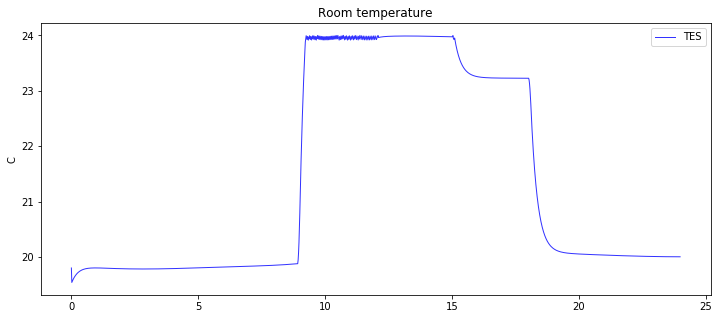

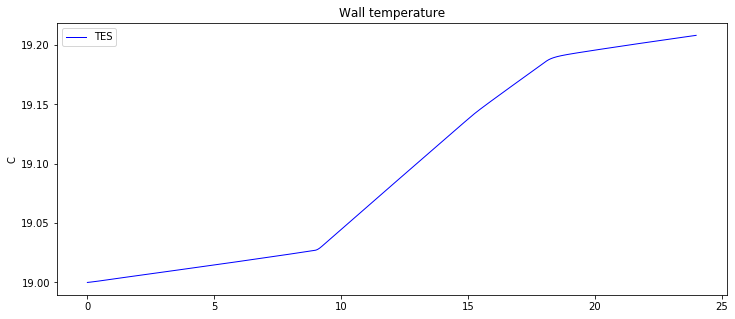

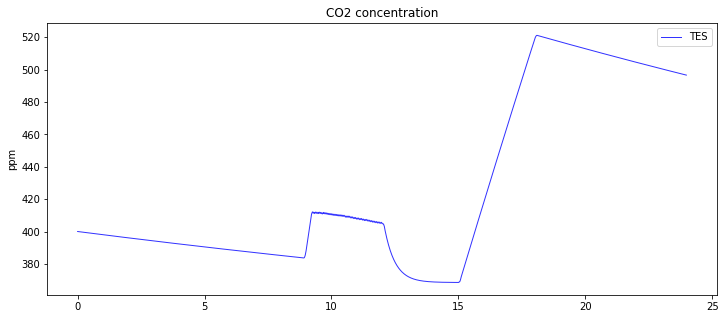

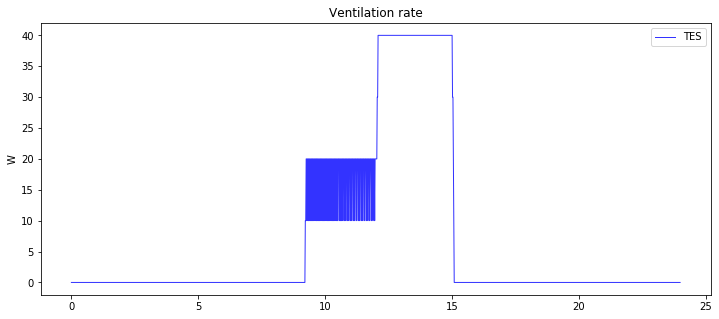

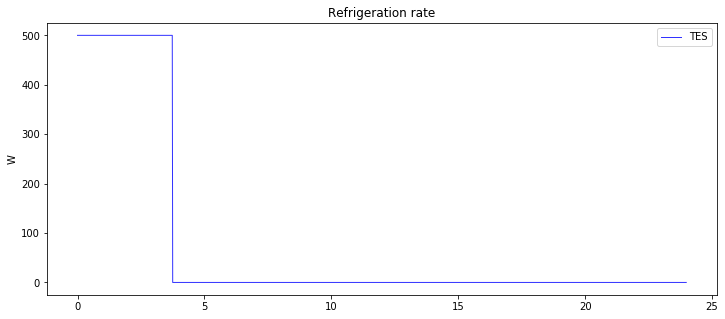

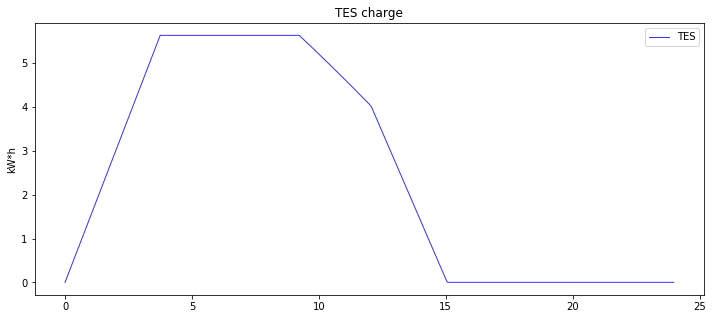

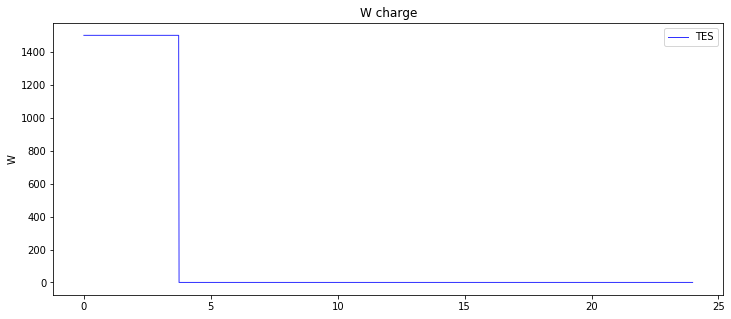

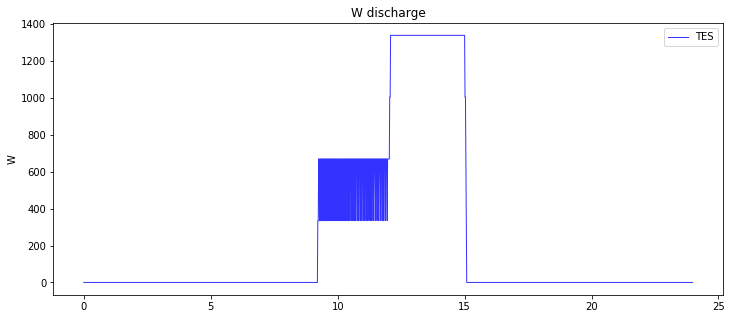

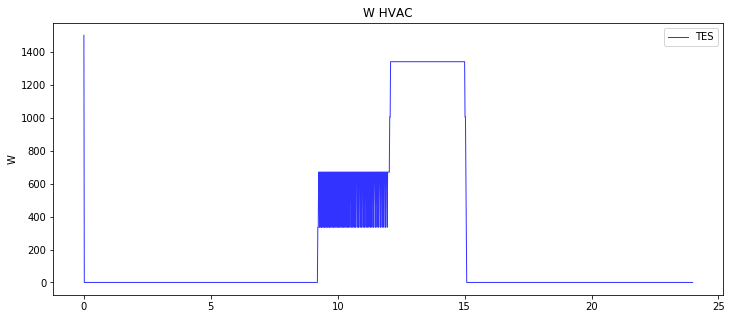

In [42]:
# TRAINING TES


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
# print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 17 # outer air temperature after TES

comp_to_work_MPC_inertia = 112500 #KOSTYL


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 1600 # number of iterations
error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.00000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])
    
#     W_dis.append(0)
#     W_ch.append(0)

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work1 = 0
    comp_to_work2 = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output)*1.1) # KOSTYL
        W_dis.append(-dischargetime(time_t[i+1])*1340/40*P_f[i+1]) # KOSTYL
        W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
        if 0 < E_tes[i+1] < tau*W_dis[i+1]:
            W_dis[i+1] = -dischargetime(time_t[i+1])*E_tes[i+1] / tau
        elif E_tes[i+1] <= 0:
            W_dis[i+1] = 0
            E_tes[i+1] = 0
        if 0 < E_tes[i] < tau*W_dis[i]:
            W_dis[i] = -dischargetime(time_t[i])*E_tes[i] / tau
        elif E_tes[i] <= 0:
            W_dis[i] = 0
            E_tes[i] = 0

#         W_dis.append(0)
#         W_ch.append(0)
        
#         comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
#                         C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec        
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])
#     print(comp_to_work)
    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='TES')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='TES')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show

    comp_working = 0
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
        
    for i in range(len(T_room)):
        
        if 0 < time_t[i] < 8:
            if comp_working < comp_to_work_MPC_inertia:
#                 print(comp_working)
#                 print(comp_to_work)
                P_c[i-1] = 500
                P_c[i-1] = max(P_c[i-1],0)
                comp_working += P_c[i-1]
            
#             else:
#                 P_c[i-1] = 0
#         if T_room[i] < T_wall[i] + 0.5:
#                 P_c[i-1] = 0
        
        if 9 < time_t[i] < 18:
            P_c[i] = 0
            P_c[i-1] = 0
            P_c[i-2] = 0
        
        if 9 < time_t[i] < 18:
            if T_room[i] > 24:
                P_f[i-1] += 10
                P_f[i-1] = min(P_f[i-1], 40)
                break
            if T_room[i] < 23.8:
                P_f[i-1] -= 10
                P_f[i-1] = max(P_f[i-1],0)
            if T_room[i] < 23:
                P_f[i-2] -= 10
                P_f[i-2] = max(P_f[i-2],0)
                
#         if 9 < time_t[i] < 18:
#             P_f[i] = 40
        
                    
    if E_tes[N-1] > 1000 and loss_T < 0.5:
        comp_to_work_MPC_inertia -= 500


    
    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost
    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )


for i in range(len(E_tes)):
    E_tes[i] = E_tes[i]/1000/3600

RUN_RESULTS.append(['MPC WITH THERMAL ENERGY STORAGE', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='TES')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='TES')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('TES charge')
plt.ylabel('kW*h')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
T_room_TES = T_room
n_CO2_TES = n_CO2
P_f_TES = P_f_prev
P_c_TES = P_c_prev
T_wall_TES = T_wall
W_HVAC_TES = W_HVAC
W_ch_TES = W_ch
W_dis_TES = W_dis
W_CHARGE_TES = E_tes


iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1378.1 LossCO2 =  0.0
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  7.5  rub,  energy consumed =  1.8 kW*h,  LossT =  1377.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  10.0
iteration =  3 : with cost =  7.5  rub,  energy consumed =  1.8 kW*h,  LossT =  1376.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  20.0
iteration =  4 : with cost =  7.5  rub,  energy consumed =  1.8 kW*h,  LossT =  1374.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  30.0
iteration =  5 : with cost =  7.5  rub,  energy consumed =  1.8 kW*h,  LossT =  1373.5 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  40.0
iteration =  6 : with cost =  7.5  rub,  energy consumed =  1.8 kW*h,  LossT =  1372.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  50.0
iteration =  7 : with cost =  7.5  rub,  energy consumed =  1.8 kW*h,  LossT =  1370.7 LossCO2 =  0.0
Computed COMP:  106500

iteration =  57 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1301.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  560.0
iteration =  58 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1299.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  570.0
iteration =  59 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1298.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  580.0
iteration =  60 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1297.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  590.0
iteration =  61 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1295.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  600.0
iteration =  62 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1294.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  610.0
iteration =  63 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1292.8 LossCO2 =  0.0
Com

iteration =  112 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1224.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1110.0
iteration =  113 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1223.5 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1120.0
iteration =  114 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1222.1 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1130.0
iteration =  115 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1220.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1140.0
iteration =  116 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1219.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1150.0
iteration =  117 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1218.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1160.0
iteration =  118 : with cost =  7.6  rub,  energy consumed =  1.8 kW*h,  LossT =  1216.5 LossC

iteration =  167 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1148.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1660.0
iteration =  168 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1147.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1670.0
iteration =  169 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1145.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1680.0
iteration =  170 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1144.5 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1690.0
iteration =  171 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1143.1 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1700.0
iteration =  172 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1141.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  1710.0
iteration =  173 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1140.4 LossC

iteration =  222 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1072.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2210.0
iteration =  223 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1071.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2220.0
iteration =  224 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1069.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2230.0
iteration =  225 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1068.5 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2240.0
iteration =  226 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1067.1 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2250.0
iteration =  227 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1065.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2260.0
iteration =  228 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  1064.3 LossC

iteration =  277 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  996.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2760.0
iteration =  278 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  995.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2770.0
iteration =  279 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  994.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2780.0
iteration =  280 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  992.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2790.0
iteration =  281 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  991.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2800.0
iteration =  282 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  989.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  2810.0
iteration =  283 : with cost =  7.7  rub,  energy consumed =  1.8 kW*h,  LossT =  988.5 LossCO2 =  0

iteration =  332 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  920.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3310.0
iteration =  333 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  918.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3320.0
iteration =  334 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  917.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3330.0
iteration =  335 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  915.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3340.0
iteration =  336 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  914.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3350.0
iteration =  337 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  913.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3360.0
iteration =  338 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  911.6 LossCO2 =  0

iteration =  387 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  842.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3860.0
iteration =  388 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  841.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3870.0
iteration =  389 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  840.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3880.0
iteration =  390 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  838.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3890.0
iteration =  391 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  837.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3900.0
iteration =  392 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  835.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  3910.0
iteration =  393 : with cost =  7.8  rub,  energy consumed =  1.8 kW*h,  LossT =  834.4 LossCO2 =  0

iteration =  442 : with cost =  7.9  rub,  energy consumed =  1.8 kW*h,  LossT =  765.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4410.0
iteration =  443 : with cost =  7.9  rub,  energy consumed =  1.8 kW*h,  LossT =  764.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4420.0
iteration =  444 : with cost =  7.9  rub,  energy consumed =  1.8 kW*h,  LossT =  762.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4430.0
iteration =  445 : with cost =  7.9  rub,  energy consumed =  1.8 kW*h,  LossT =  761.5 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4440.0
iteration =  446 : with cost =  7.9  rub,  energy consumed =  1.8 kW*h,  LossT =  760.1 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4450.0
iteration =  447 : with cost =  7.9  rub,  energy consumed =  1.8 kW*h,  LossT =  758.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4460.0
iteration =  448 : with cost =  7.9  rub,  energy consumed =  1.8 kW*h,  LossT =  757.3 LossCO2 =  0

iteration =  497 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  688.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4960.0
iteration =  498 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  687.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4970.0
iteration =  499 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  685.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4980.0
iteration =  500 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  684.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  4990.0
iteration =  501 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  683.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  5000.0
iteration =  502 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  681.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  5010.0
iteration =  503 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  680.2 LossCO2 =  0

iteration =  552 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  611.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  5510.0
iteration =  553 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  610.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  5520.0
iteration =  554 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  608.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  5530.0
iteration =  555 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  607.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  5540.0
iteration =  556 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  606.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  5550.0
iteration =  557 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  604.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  5560.0
iteration =  558 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  603.2 LossCO2 =  0

iteration =  607 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  534.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6060.0
iteration =  608 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  533.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6070.0
iteration =  609 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  531.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6080.0
iteration =  610 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  530.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6090.0
iteration =  611 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  529.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6100.0
iteration =  612 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  527.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6110.0
iteration =  613 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  526.2 LossCO2 =  0

iteration =  662 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  457.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6610.0
iteration =  663 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  456.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6620.0
iteration =  664 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  454.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6630.0
iteration =  665 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  453.5 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6640.0
iteration =  666 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  452.1 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6650.0
iteration =  667 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  450.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  6660.0
iteration =  668 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  449.3 LossCO2 =  0

iteration =  717 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  380.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7160.0
iteration =  718 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  379.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7170.0
iteration =  719 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  378.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7180.0
iteration =  720 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  376.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7190.0
iteration =  721 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  375.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7200.0
iteration =  722 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  374.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7210.0
iteration =  723 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  372.6 LossCO2 =  0

iteration =  772 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  304.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7710.0
iteration =  773 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  303.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7720.0
iteration =  774 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  301.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7730.0
iteration =  775 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  300.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7740.0
iteration =  776 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  298.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7750.0
iteration =  777 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  297.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  7760.0
iteration =  778 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  296.0 LossCO2 =  0

iteration =  827 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  228.1 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8260.0
iteration =  828 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  226.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8270.0
iteration =  829 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  225.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8280.0
iteration =  830 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  223.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8290.0
iteration =  831 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  222.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8300.0
iteration =  832 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  221.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8310.0
iteration =  833 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  219.8 LossCO2 =  0

iteration =  882 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  152.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8810.0
iteration =  883 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  151.1 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8820.0
iteration =  884 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  149.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8830.0
iteration =  885 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  148.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8840.0
iteration =  886 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  146.9 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8850.0
iteration =  887 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  145.6 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  8860.0
iteration =  888 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  144.2 LossCO2 =  0

iteration =  937 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  78.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9360.0
iteration =  938 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  77.0 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9370.0
iteration =  939 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  75.7 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9380.0
iteration =  940 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  74.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9390.0
iteration =  941 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  73.1 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9400.0
iteration =  942 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  71.8 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9410.0
iteration =  943 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  70.5 LossCO2 =  0.0
Comp

iteration =  992 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  11.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9910.0
iteration =  993 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  10.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9920.0
iteration =  994 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  9.2 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9930.0
iteration =  995 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  8.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9940.0
iteration =  996 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  7.3 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9950.0
iteration =  997 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  6.4 LossCO2 =  0.0
Computed COMP:  106500.0 Computed FAN:  9960.0
iteration =  998 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  5.6 LossCO2 =  0.0
Computed 

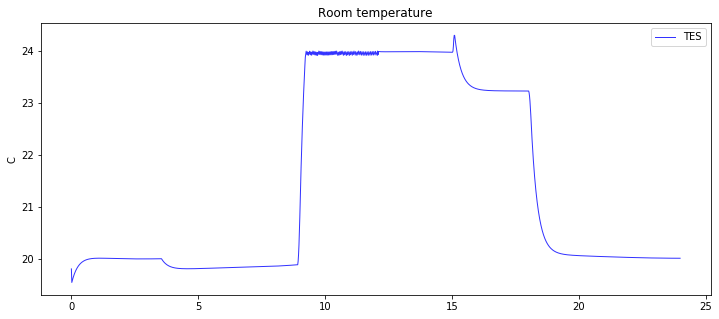

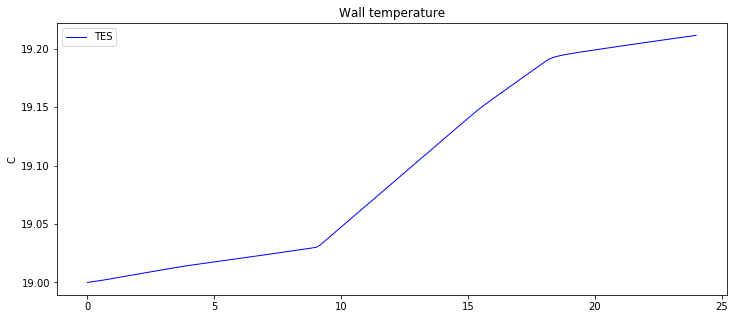

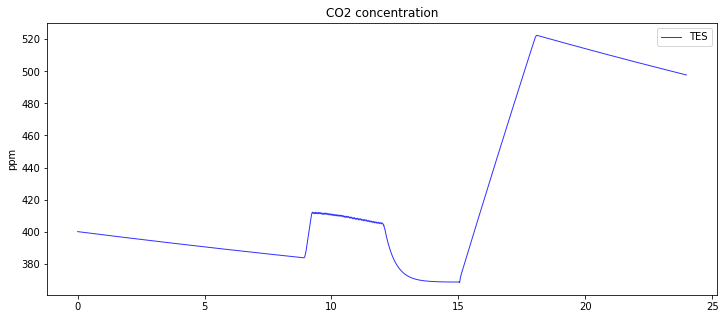

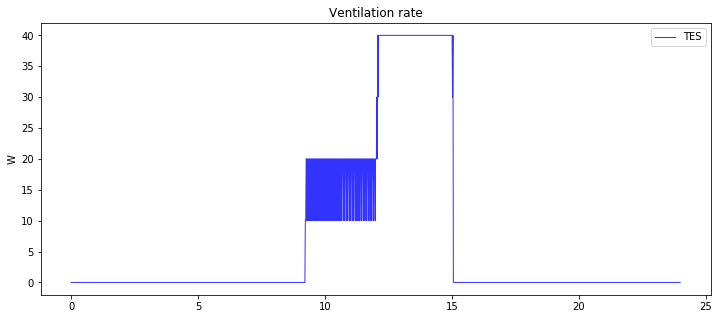

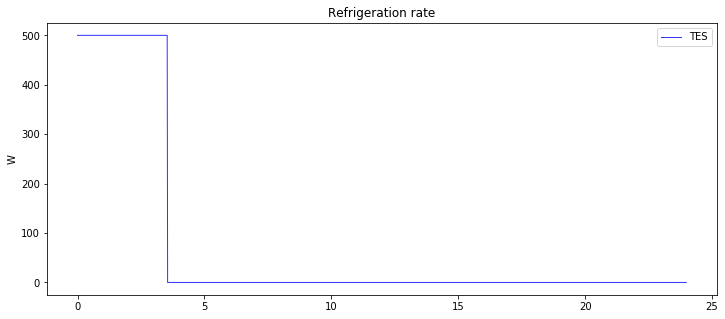

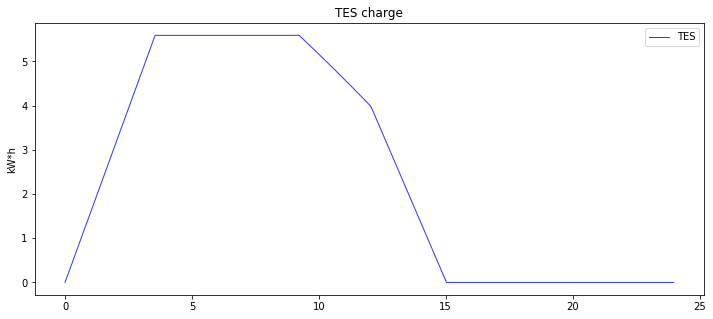

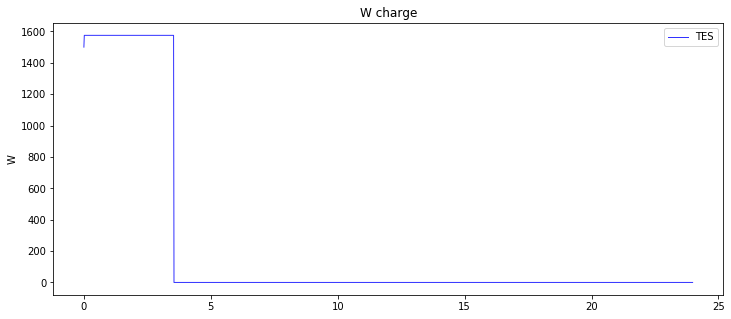

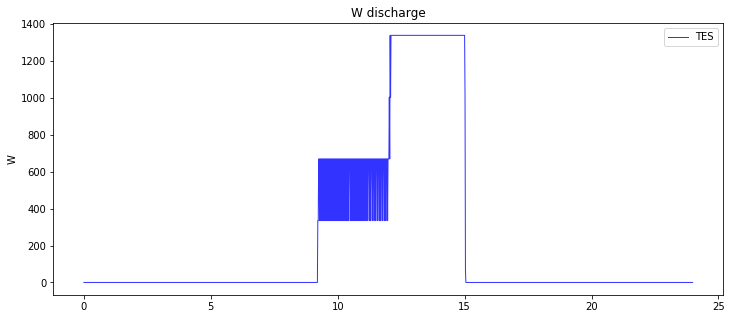

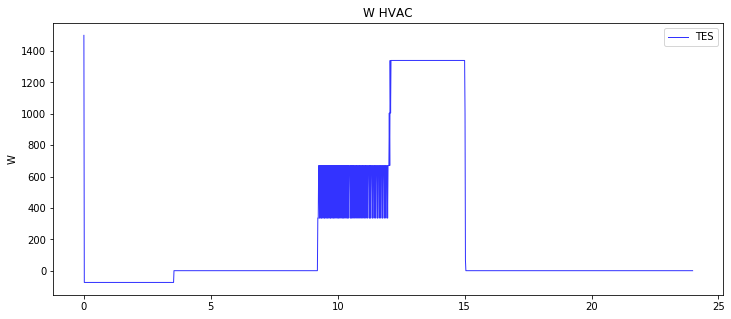

In [22]:
# TRAINING TES - introducing the COP difference

tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
# print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 17 # outer air temperature after TES

comp_to_work_MPC_inertia = 107000 #KOSTYL


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 1600 # number of iterations
error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.00000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])
    
#     W_dis.append(0)
#     W_ch.append(0)

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work1 = 0
    comp_to_work2 = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output)*1.1) # KOSTYL
        W_dis.append(-dischargetime(time_t[i+1])*1340/40*P_f[i+1]) # KOSTYL
        W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1]*1.05)
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
        if 0 < E_tes[i+1] < tau*W_dis[i+1]:
            W_dis[i+1] = -dischargetime(time_t[i+1])*E_tes[i+1] / tau
        elif E_tes[i+1] <= 0:
            W_dis[i+1] = 0
            E_tes[i+1] = 0
        if 0 < E_tes[i] < tau*W_dis[i]:
            W_dis[i] = -dischargetime(time_t[i])*E_tes[i] / tau
        elif E_tes[i] <= 0:
            W_dis[i] = 0
            E_tes[i] = 0

#         W_dis.append(0)
#         W_ch.append(0)
        
#         comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
#                         C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec        
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])
#     print(comp_to_work)
    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='TES')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='TES')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show

    comp_working = 0
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
        
    for i in range(len(T_room)):
        
        if 0 < time_t[i] < 8:
            if comp_working < comp_to_work_MPC_inertia:
#                 print(comp_working)
#                 print(comp_to_work)
                P_c[i-1] = 500
                P_c[i-1] = max(P_c[i-1],0)
                comp_working += P_c[i-1]
            
#             else:
#                 P_c[i-1] = 0
#         if T_room[i] < T_wall[i] + 0.5:
#                 P_c[i-1] = 0
        
        if 9 < time_t[i] < 18:
            P_c[i] = 0
            P_c[i-1] = 0
            P_c[i-2] = 0
        
        if 9 < time_t[i] < 18:
            if T_room[i] > 24:
                P_f[i-1] += 10
                P_f[i-1] = min(P_f[i-1], 40)
                break
            if T_room[i] < 23.8:
                P_f[i-1] -= 10
                P_f[i-1] = max(P_f[i-1],0)
            if T_room[i] < 23:
                P_f[i-2] -= 10
                P_f[i-2] = max(P_f[i-2],0)
                
#         if 9 < time_t[i] < 18:
#             P_f[i] = 40
        
                    
    if E_tes[N-1] > 1000 and loss_T < 0.5:
        comp_to_work_MPC_inertia -= 500


    
    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
#    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost
    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )


for i in range(len(E_tes)):
    E_tes[i] = E_tes[i]/1000/3600

RUN_RESULTS.append(['MPC WITH THERMAL ENERGY STORAGE', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='TES')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='TES')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('TES charge')
plt.ylabel('kW*h')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
T_room_TES = T_room
n_CO2_TES = n_CO2
P_f_TES = P_f_prev
P_c_TES = P_c_prev
T_wall_TES = T_wall
W_HVAC_TES = W_HVAC
W_ch_TES = W_ch
W_dis_TES = W_dis
W_CHARGE_TES = E_tes


In [23]:
W_CHARGE_TES[1000]/W_CHARGE_TES[310]*comp_to_work_MPC_inertia

0.0

In [ ]:
# Increased COP at night because of lower ambient temperature is showed good result

In [ ]:
# SENSETIVITY ANALYSIS
# results is shown in the comments at the cell top
# All comparisons was made with Base case

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1224.3 LossCO2 =  0.0
Total summary P_c needed =  526.2  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1212.4 LossCO2 =  0.0
Total summary P_c needed =  1024.2  W * tau summary, Total summary P_f needed 2811.9  W * tau summary
Computed COMP:  500.0 Computed FAN:  640.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1204.1 LossCO2 =  0.0
Total summary P_c needed =  1023.1  W * tau summary, Total summary P_f needed 3038.7  W * tau summary
Computed COMP:  500.0 Computed FAN:  880.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1197.7 LossCO2 =  0.0
Total summary P_c needed =  1022.3  W * tau summary, Total summary P_f needed 3190.3  W * tau summary
Computed COMP:  500.0 Computed FAN:  1040.0
iteration

iteration =  34 : with cost =  0.7  rub,  energy consumed =  0.1 kW*h,  LossT =  1009.4 LossCO2 =  0.0
Total summary P_c needed =  4499.3  W * tau summary, Total summary P_f needed 6798.5  W * tau summary
Computed COMP:  4000.0 Computed FAN:  4840.0
iteration =  35 : with cost =  0.7  rub,  energy consumed =  0.2 kW*h,  LossT =  1002.7 LossCO2 =  0.0
Total summary P_c needed =  4498.5  W * tau summary, Total summary P_f needed 6949.9  W * tau summary
Computed COMP:  4000.0 Computed FAN:  5000.0
iteration =  36 : with cost =  0.7  rub,  energy consumed =  0.2 kW*h,  LossT =  997.3 LossCO2 =  0.0
Total summary P_c needed =  4497.9  W * tau summary, Total summary P_f needed 7063.4  W * tau summary
Computed COMP:  4000.0 Computed FAN:  5120.0
iteration =  37 : with cost =  0.7  rub,  energy consumed =  0.2 kW*h,  LossT =  991.7 LossCO2 =  0.0
Total summary P_c needed =  4497.2  W * tau summary, Total summary P_f needed 7176.9  W * tau summary
Computed COMP:  4000.0 Computed FAN:  5240.0
it

iteration =  67 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  813.5 LossCO2 =  0.0
Total summary P_c needed =  12975.5  W * tau summary, Total summary P_f needed 9656.1  W * tau summary
Computed COMP:  12500.0 Computed FAN:  7880.0
iteration =  68 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  811.5 LossCO2 =  0.0
Total summary P_c needed =  12975.2  W * tau summary, Total summary P_f needed 9692.7  W * tau summary
Computed COMP:  12500.0 Computed FAN:  7920.0
iteration =  69 : with cost =  1.7  rub,  energy consumed =  0.3 kW*h,  LossT =  805.6 LossCO2 =  0.0
Total summary P_c needed =  13474.6  W * tau summary, Total summary P_f needed 9729.2  W * tau summary
Computed COMP:  13000.0 Computed FAN:  7960.0
iteration =  70 : with cost =  1.7  rub,  energy consumed =  0.4 kW*h,  LossT =  799.8 LossCO2 =  0.0
Total summary P_c needed =  13973.9  W * tau summary, Total summary P_f needed 9765.8  W * tau summary
Computed COMP:  13500.0 Computed FAN:  800

iteration =  100 : with cost =  2.8  rub,  energy consumed =  0.6 kW*h,  LossT =  646.8 LossCO2 =  0.0
Total summary P_c needed =  26455.6  W * tau summary, Total summary P_f needed 10847.8  W * tau summary
Computed COMP:  26000.0 Computed FAN:  9200.0
iteration =  101 : with cost =  2.8  rub,  energy consumed =  0.6 kW*h,  LossT =  641.1 LossCO2 =  0.0
Total summary P_c needed =  26954.9  W * tau summary, Total summary P_f needed 10883.5  W * tau summary
Computed COMP:  26500.0 Computed FAN:  9240.0
iteration =  102 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  635.5 LossCO2 =  0.0
Total summary P_c needed =  27454.2  W * tau summary, Total summary P_f needed 10919.1  W * tau summary
Computed COMP:  27000.0 Computed FAN:  9280.0
iteration =  103 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  629.9 LossCO2 =  0.0
Total summary P_c needed =  27953.5  W * tau summary, Total summary P_f needed 10954.6  W * tau summary
Computed COMP:  27500.0 Computed F

iteration =  133 : with cost =  4.0  rub,  energy consumed =  0.8 kW*h,  LossT =  477.1 LossCO2 =  0.0
Total summary P_c needed =  40435.2  W * tau summary, Total summary P_f needed 12009.0  W * tau summary
Computed COMP:  40000.0 Computed FAN:  10520.0
iteration =  134 : with cost =  4.0  rub,  energy consumed =  0.8 kW*h,  LossT =  475.2 LossCO2 =  0.0
Total summary P_c needed =  40435.0  W * tau summary, Total summary P_f needed 12043.6  W * tau summary
Computed COMP:  40000.0 Computed FAN:  10560.0
iteration =  135 : with cost =  4.1  rub,  energy consumed =  0.9 kW*h,  LossT =  469.3 LossCO2 =  0.0
Total summary P_c needed =  40934.3  W * tau summary, Total summary P_f needed 12078.3  W * tau summary
Computed COMP:  40500.0 Computed FAN:  10600.0
iteration =  136 : with cost =  4.1  rub,  energy consumed =  0.9 kW*h,  LossT =  463.5 LossCO2 =  0.0
Total summary P_c needed =  41433.6  W * tau summary, Total summary P_f needed 12112.9  W * tau summary
Computed COMP:  41000.0 Compute

iteration =  166 : with cost =  5.2  rub,  energy consumed =  1.1 kW*h,  LossT =  311.3 LossCO2 =  0.0
Total summary P_c needed =  53915.4  W * tau summary, Total summary P_f needed 13134.9  W * tau summary
Computed COMP:  53500.0 Computed FAN:  11840.0
iteration =  167 : with cost =  5.2  rub,  energy consumed =  1.1 kW*h,  LossT =  305.6 LossCO2 =  0.0
Total summary P_c needed =  54414.7  W * tau summary, Total summary P_f needed 13168.3  W * tau summary
Computed COMP:  54000.0 Computed FAN:  11880.0
iteration =  168 : with cost =  5.3  rub,  energy consumed =  1.1 kW*h,  LossT =  300.0 LossCO2 =  0.0
Total summary P_c needed =  54914.0  W * tau summary, Total summary P_f needed 13201.7  W * tau summary
Computed COMP:  54500.0 Computed FAN:  11920.0
iteration =  169 : with cost =  5.3  rub,  energy consumed =  1.1 kW*h,  LossT =  294.5 LossCO2 =  0.0
Total summary P_c needed =  55413.3  W * tau summary, Total summary P_f needed 13235.1  W * tau summary
Computed COMP:  55000.0 Compute

iteration =  199 : with cost =  6.4  rub,  energy consumed =  1.3 kW*h,  LossT =  143.9 LossCO2 =  0.0
Total summary P_c needed =  67895.0  W * tau summary, Total summary P_f needed 14210.7  W * tau summary
Computed COMP:  67500.0 Computed FAN:  13160.0
iteration =  200 : with cost =  6.4  rub,  energy consumed =  1.3 kW*h,  LossT =  142.0 LossCO2 =  0.0
Total summary P_c needed =  67894.8  W * tau summary, Total summary P_f needed 14242.2  W * tau summary
Computed COMP:  67500.0 Computed FAN:  13200.0
iteration =  201 : with cost =  6.5  rub,  energy consumed =  1.4 kW*h,  LossT =  136.3 LossCO2 =  0.0
Total summary P_c needed =  68394.1  W * tau summary, Total summary P_f needed 14273.7  W * tau summary
Computed COMP:  68000.0 Computed FAN:  13240.0
iteration =  202 : with cost =  6.5  rub,  energy consumed =  1.4 kW*h,  LossT =  130.7 LossCO2 =  0.0
Total summary P_c needed =  68893.4  W * tau summary, Total summary P_f needed 14305.1  W * tau summary
Computed COMP:  68500.0 Compute

iteration =  232 : with cost =  7.6  rub,  energy consumed =  1.6 kW*h,  LossT =  0.4 LossCO2 =  0.0
Total summary P_c needed =  81375.2  W * tau summary, Total summary P_f needed 15201.8  W * tau summary
Computed COMP:  81000.0 Computed FAN:  14480.0
iteration =  233 : with cost =  7.6  rub,  energy consumed =  1.6 kW*h,  LossT =  0.0 LossCO2 =  0.0
Total summary P_c needed =  81874.3  W * tau summary, Total summary P_f needed 15258.6  W * tau summary
Computed COMP:  81500.0 Computed FAN:  14560.0
iteration =  234 : with cost =  7.6  rub,  energy consumed =  1.6 kW*h,  LossT =  0.0 LossCO2 =  0.0
Total summary P_c needed =  81374.8  W * tau summary, Total summary P_f needed 15258.6  W * tau summary
Computed COMP:  81000.0 Computed FAN:  14560.0
iteration =  235 : with cost =  7.6  rub,  energy consumed =  1.6 kW*h,  LossT =  0.0 LossCO2 =  0.0
Total summary P_c needed =  81374.8  W * tau summary, Total summary P_f needed 15258.6  W * tau summary
Computed COMP:  81000.0 Computed FAN:  

<function matplotlib.pyplot.show(*args, **kw)>

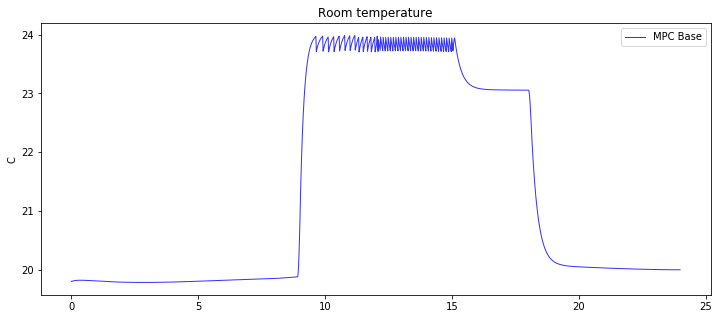

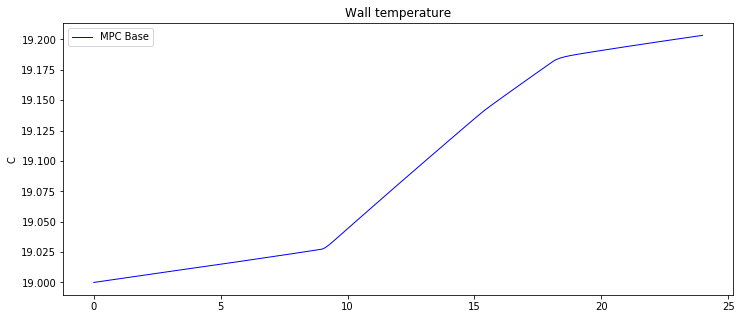

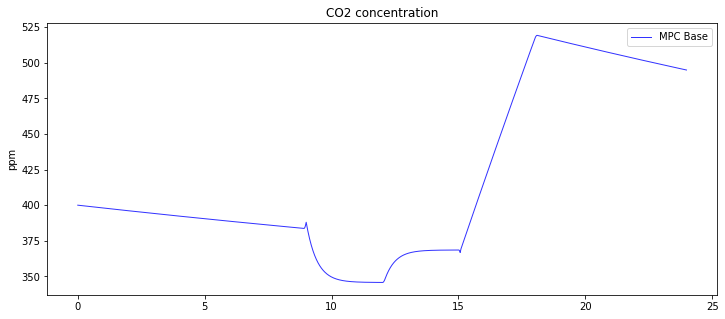

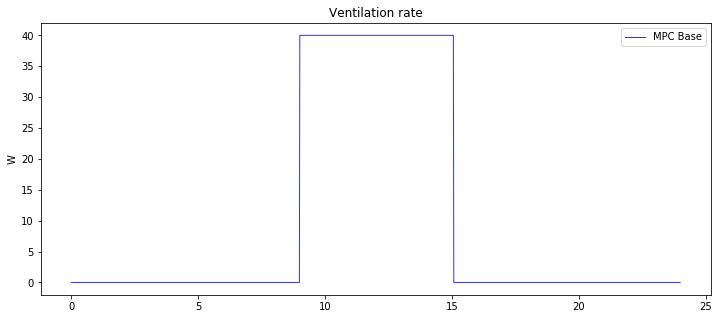

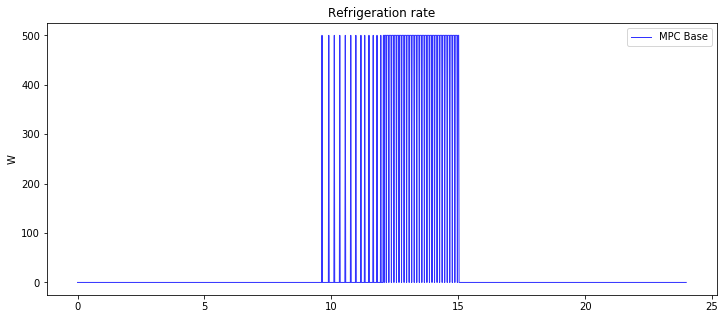

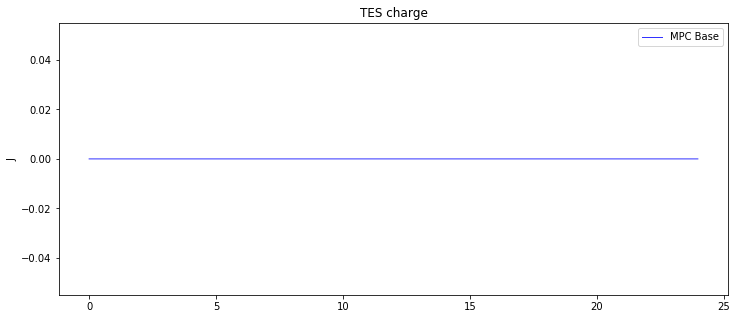

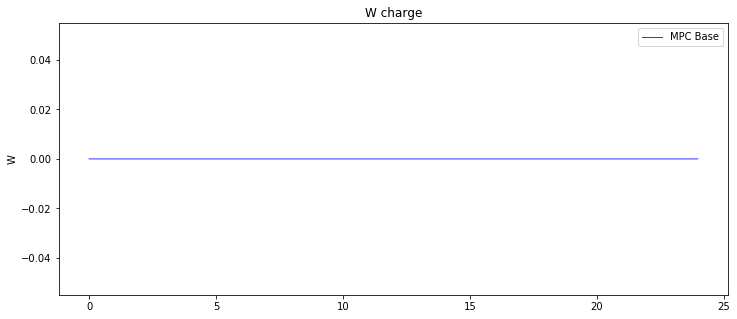

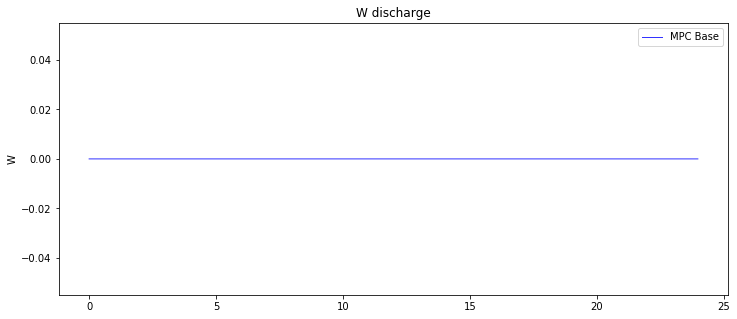

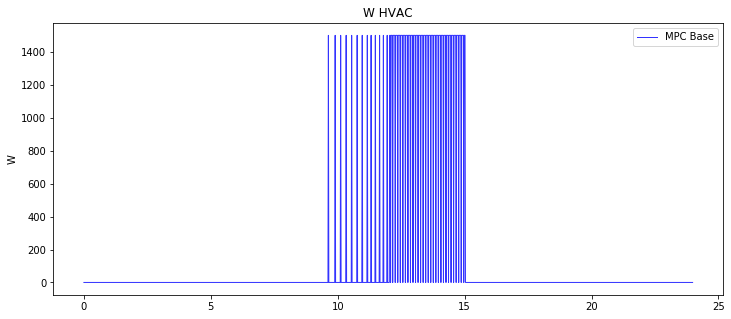

In [61]:
%%time
# USUAL MPC - decreased metabolic rate at 0.95 -> cost decreased at 18.2%, cons at 15.7%


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120*0.95 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
# T_room_MPC = T_room
# n_CO2_MPC = n_CO2
# P_f_MPC = P_f_prev
# P_c_MPC = P_c_prev
# T_wall_MPC = T_wall
# W_HVAC_MPC = W_HVAC

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1533.2 LossCO2 =  0.0
Total summary P_c needed =  568.8  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1521.7 LossCO2 =  0.0
Total summary P_c needed =  1067.0  W * tau summary, Total summary P_f needed 2698.7  W * tau summary
Computed COMP:  500.0 Computed FAN:  520.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1515.3 LossCO2 =  0.0
Total summary P_c needed =  1066.3  W * tau summary, Total summary P_f needed 2849.7  W * tau summary
Computed COMP:  500.0 Computed FAN:  680.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1509.7 LossCO2 =  0.0
Total summary P_c needed =  1065.6  W * tau summary, Total summary P_f needed 2963.1  W * tau summary
Computed COMP:  500.0 Computed FAN:  800.0
iteration 

iteration =  34 : with cost =  0.9  rub,  energy consumed =  0.2 kW*h,  LossT =  1336.1 LossCO2 =  0.0
Total summary P_c needed =  8544.8  W * tau summary, Total summary P_f needed 5471.0  W * tau summary
Computed COMP:  8000.0 Computed FAN:  3440.0
iteration =  35 : with cost =  0.9  rub,  energy consumed =  0.2 kW*h,  LossT =  1329.0 LossCO2 =  0.0
Total summary P_c needed =  9043.9  W * tau summary, Total summary P_f needed 5546.9  W * tau summary
Computed COMP:  8500.0 Computed FAN:  3520.0
iteration =  36 : with cost =  0.9  rub,  energy consumed =  0.2 kW*h,  LossT =  1325.2 LossCO2 =  0.0
Total summary P_c needed =  9043.4  W * tau summary, Total summary P_f needed 5622.9  W * tau summary
Computed COMP:  8500.0 Computed FAN:  3600.0
iteration =  37 : with cost =  1.0  rub,  energy consumed =  0.2 kW*h,  LossT =  1318.0 LossCO2 =  0.0
Total summary P_c needed =  9542.6  W * tau summary, Total summary P_f needed 5698.9  W * tau summary
Computed COMP:  9000.0 Computed FAN:  3680.0


iteration =  67 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1155.3 LossCO2 =  0.0
Total summary P_c needed =  17022.9  W * tau summary, Total summary P_f needed 7970.2  W * tau summary
Computed COMP:  16500.0 Computed FAN:  6080.0
iteration =  68 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1151.5 LossCO2 =  0.0
Total summary P_c needed =  17022.5  W * tau summary, Total summary P_f needed 8045.7  W * tau summary
Computed COMP:  16500.0 Computed FAN:  6160.0
iteration =  69 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1144.3 LossCO2 =  0.0
Total summary P_c needed =  17521.6  W * tau summary, Total summary P_f needed 8121.1  W * tau summary
Computed COMP:  17000.0 Computed FAN:  6240.0
iteration =  70 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1140.5 LossCO2 =  0.0
Total summary P_c needed =  17521.2  W * tau summary, Total summary P_f needed 8196.6  W * tau summary
Computed COMP:  17000.0 Computed FAN: 

iteration =  100 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  966.2 LossCO2 =  0.0
Total summary P_c needed =  29500.6  W * tau summary, Total summary P_f needed 9802.3  W * tau summary
Computed COMP:  29000.0 Computed FAN:  8040.0
iteration =  101 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  960.1 LossCO2 =  0.0
Total summary P_c needed =  29999.9  W * tau summary, Total summary P_f needed 9838.7  W * tau summary
Computed COMP:  29500.0 Computed FAN:  8080.0
iteration =  102 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  954.1 LossCO2 =  0.0
Total summary P_c needed =  30499.2  W * tau summary, Total summary P_f needed 9875.2  W * tau summary
Computed COMP:  30000.0 Computed FAN:  8120.0
iteration =  103 : with cost =  3.1  rub,  energy consumed =  0.6 kW*h,  LossT =  948.0 LossCO2 =  0.0
Total summary P_c needed =  30998.4  W * tau summary, Total summary P_f needed 9911.6  W * tau summary
Computed COMP:  30500.0 Computed FAN: 

iteration =  133 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  770.9 LossCO2 =  0.0
Total summary P_c needed =  45977.7  W * tau summary, Total summary P_f needed 10954.6  W * tau summary
Computed COMP:  45500.0 Computed FAN:  9320.0
iteration =  134 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  764.8 LossCO2 =  0.0
Total summary P_c needed =  46477.0  W * tau summary, Total summary P_f needed 10990.2  W * tau summary
Computed COMP:  46000.0 Computed FAN:  9360.0
iteration =  135 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  760.8 LossCO2 =  0.0
Total summary P_c needed =  46976.5  W * tau summary, Total summary P_f needed 10990.2  W * tau summary
Computed COMP:  46500.0 Computed FAN:  9360.0
iteration =  136 : with cost =  4.5  rub,  energy consumed =  0.9 kW*h,  LossT =  755.2 LossCO2 =  0.0
Total summary P_c needed =  47475.9  W * tau summary, Total summary P_f needed 11025.7  W * tau summary
Computed COMP:  47000.0 Computed F

iteration =  166 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  579.5 LossCO2 =  0.0
Total summary P_c needed =  62455.2  W * tau summary, Total summary P_f needed 12043.6  W * tau summary
Computed COMP:  62000.0 Computed FAN:  10560.0
iteration =  167 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  573.6 LossCO2 =  0.0
Total summary P_c needed =  62954.5  W * tau summary, Total summary P_f needed 12078.3  W * tau summary
Computed COMP:  62500.0 Computed FAN:  10600.0
iteration =  168 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  567.7 LossCO2 =  0.0
Total summary P_c needed =  63453.8  W * tau summary, Total summary P_f needed 12112.9  W * tau summary
Computed COMP:  63000.0 Computed FAN:  10640.0
iteration =  169 : with cost =  5.9  rub,  energy consumed =  1.2 kW*h,  LossT =  561.9 LossCO2 =  0.0
Total summary P_c needed =  63953.1  W * tau summary, Total summary P_f needed 12147.5  W * tau summary
Computed COMP:  63500.0 Compute

iteration =  199 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  386.0 LossCO2 =  0.0
Total summary P_c needed =  78932.4  W * tau summary, Total summary P_f needed 13134.9  W * tau summary
Computed COMP:  78500.0 Computed FAN:  11840.0
iteration =  200 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  380.0 LossCO2 =  0.0
Total summary P_c needed =  79431.7  W * tau summary, Total summary P_f needed 13168.3  W * tau summary
Computed COMP:  79000.0 Computed FAN:  11880.0
iteration =  201 : with cost =  7.3  rub,  energy consumed =  1.5 kW*h,  LossT =  374.0 LossCO2 =  0.0
Total summary P_c needed =  79931.0  W * tau summary, Total summary P_f needed 13201.7  W * tau summary
Computed COMP:  79500.0 Computed FAN:  11920.0
iteration =  202 : with cost =  7.3  rub,  energy consumed =  1.5 kW*h,  LossT =  368.1 LossCO2 =  0.0
Total summary P_c needed =  80430.3  W * tau summary, Total summary P_f needed 13235.1  W * tau summary
Computed COMP:  80000.0 Compute

iteration =  232 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  192.8 LossCO2 =  0.0
Total summary P_c needed =  95409.6  W * tau summary, Total summary P_f needed 14179.1  W * tau summary
Computed COMP:  95000.0 Computed FAN:  13120.0
iteration =  233 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  186.9 LossCO2 =  0.0
Total summary P_c needed =  95908.9  W * tau summary, Total summary P_f needed 14210.7  W * tau summary
Computed COMP:  95500.0 Computed FAN:  13160.0
iteration =  234 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  181.0 LossCO2 =  0.0
Total summary P_c needed =  96408.2  W * tau summary, Total summary P_f needed 14242.2  W * tau summary
Computed COMP:  96000.0 Computed FAN:  13200.0
iteration =  235 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  175.1 LossCO2 =  0.0
Total summary P_c needed =  96907.5  W * tau summary, Total summary P_f needed 14273.7  W * tau summary
Computed COMP:  96500.0 Compute

iteration =  265 : with cost =  10.0  rub,  energy consumed =  2.1 kW*h,  LossT =  10.3 LossCO2 =  0.0
Total summary P_c needed =  111886.8  W * tau summary, Total summary P_f needed 15145.3  W * tau summary
Computed COMP:  111500.0 Computed FAN:  14400.0
iteration =  266 : with cost =  10.0  rub,  energy consumed =  2.1 kW*h,  LossT =  6.1 LossCO2 =  0.0
Total summary P_c needed =  112386.1  W * tau summary, Total summary P_f needed 15173.6  W * tau summary
Computed COMP:  112000.0 Computed FAN:  14440.0
iteration =  267 : with cost =  10.1  rub,  energy consumed =  2.1 kW*h,  LossT =  2.5 LossCO2 =  0.0
Total summary P_c needed =  112885.4  W * tau summary, Total summary P_f needed 15201.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  14480.0
iteration =  268 : with cost =  10.1  rub,  energy consumed =  2.1 kW*h,  LossT =  0.2 LossCO2 =  0.0
Total summary P_c needed =  113384.7  W * tau summary, Total summary P_f needed 15230.1  W * tau summary
Computed COMP:  113000.0 Co

<function matplotlib.pyplot.show(*args, **kw)>

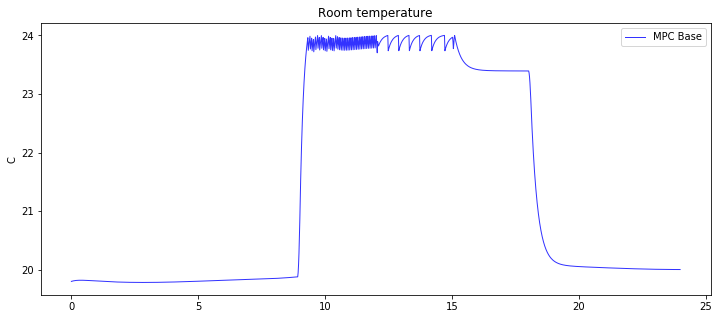

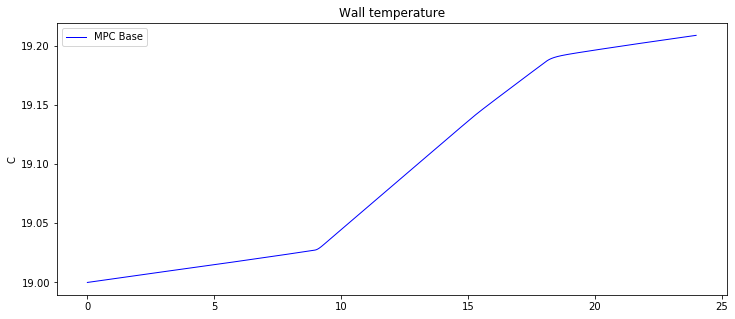

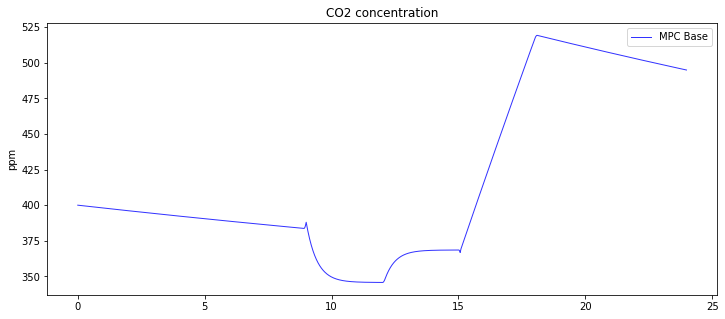

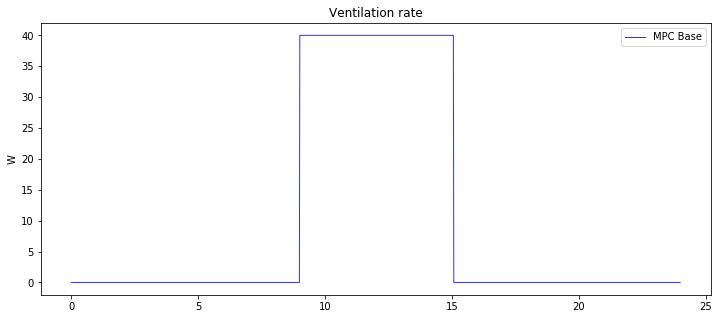

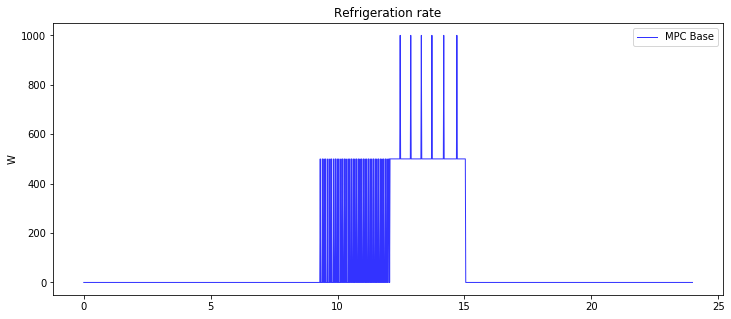

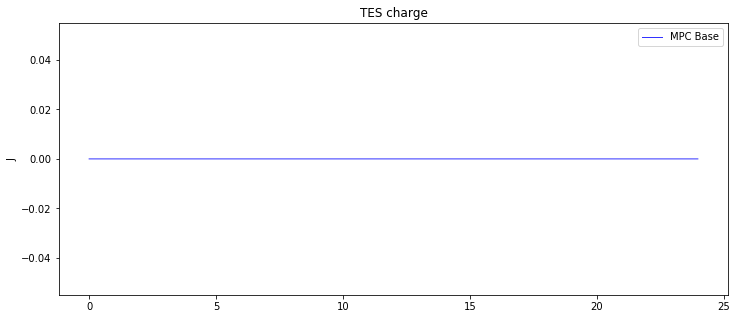

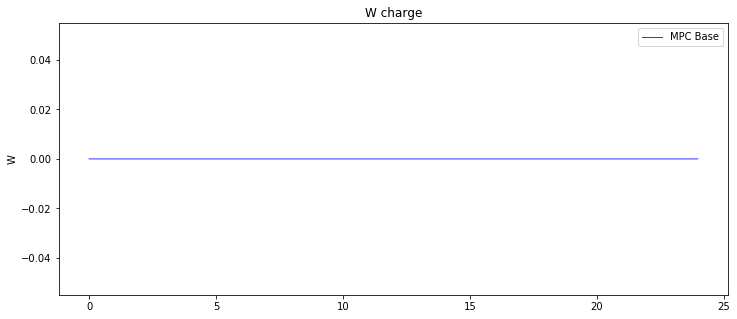

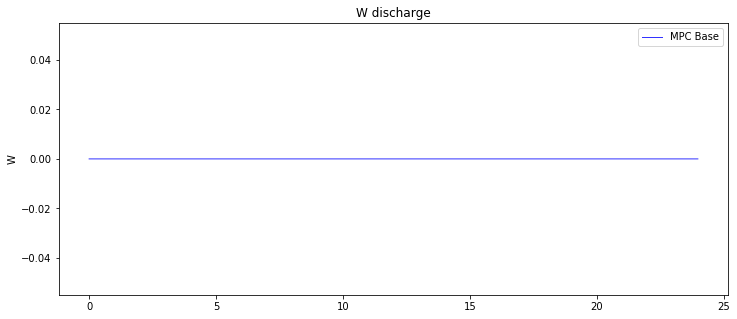

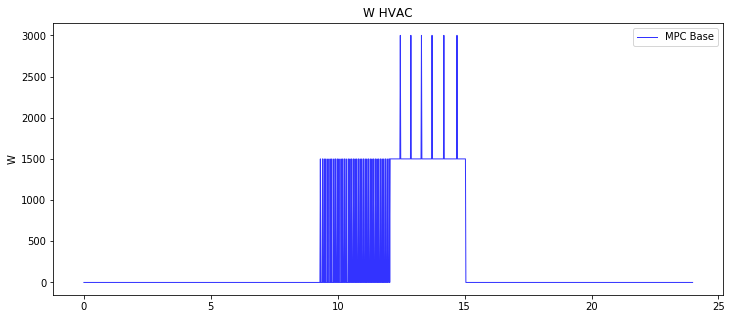

In [62]:
%%time
# USUAL MPC - increased metabolic rate at 1.05 -> cost increased at 7.9%, cons at 9.5%


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120*1.05 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
# T_room_MPC = T_room
# n_CO2_MPC = n_CO2
# P_f_MPC = P_f_prev
# P_c_MPC = P_c_prev
# T_wall_MPC = T_wall
# W_HVAC_MPC = W_HVAC

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1378.1 LossCO2 =  0.0
Total summary P_c needed =  547.5  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1366.8 LossCO2 =  0.0
Total summary P_c needed =  1045.7  W * tau summary, Total summary P_f needed 2736.4  W * tau summary
Computed COMP:  500.0 Computed FAN:  560.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1359.4 LossCO2 =  0.0
Total summary P_c needed =  1044.7  W * tau summary, Total summary P_f needed 2925.2  W * tau summary
Computed COMP:  500.0 Computed FAN:  760.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1352.4 LossCO2 =  0.0
Total summary P_c needed =  1043.9  W * tau summary, Total summary P_f needed 3076.6  W * tau summary
Computed COMP:  500.0 Computed FAN:  920.0
iteration 

iteration =  34 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1187.4 LossCO2 =  0.0
Total summary P_c needed =  6523.9  W * tau summary, Total summary P_f needed 5774.8  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3760.0
iteration =  35 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1182.1 LossCO2 =  0.0
Total summary P_c needed =  6523.3  W * tau summary, Total summary P_f needed 5888.7  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3880.0
iteration =  36 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1178.3 LossCO2 =  0.0
Total summary P_c needed =  6522.9  W * tau summary, Total summary P_f needed 5964.6  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3960.0
iteration =  37 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1171.4 LossCO2 =  0.0
Total summary P_c needed =  7022.0  W * tau summary, Total summary P_f needed 6040.5  W * tau summary
Computed COMP:  6500.0 Computed FAN:  4040.0


iteration =  67 : with cost =  1.5  rub,  energy consumed =  0.3 kW*h,  LossT =  1003.7 LossCO2 =  0.0
Total summary P_c needed =  13001.6  W * tau summary, Total summary P_f needed 8724.6  W * tau summary
Computed COMP:  12500.0 Computed FAN:  6880.0
iteration =  68 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  996.9 LossCO2 =  0.0
Total summary P_c needed =  13500.7  W * tau summary, Total summary P_f needed 8800.0  W * tau summary
Computed COMP:  13000.0 Computed FAN:  6960.0
iteration =  69 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  991.4 LossCO2 =  0.0
Total summary P_c needed =  13500.1  W * tau summary, Total summary P_f needed 8913.2  W * tau summary
Computed COMP:  13000.0 Computed FAN:  7080.0
iteration =  70 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  984.6 LossCO2 =  0.0
Total summary P_c needed =  13999.2  W * tau summary, Total summary P_f needed 8988.7  W * tau summary
Computed COMP:  13500.0 Computed FAN:  71

iteration =  100 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  815.7 LossCO2 =  0.0
Total summary P_c needed =  27979.0  W * tau summary, Total summary P_f needed 10201.7  W * tau summary
Computed COMP:  27500.0 Computed FAN:  8480.0
iteration =  101 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  810.1 LossCO2 =  0.0
Total summary P_c needed =  28478.3  W * tau summary, Total summary P_f needed 10237.8  W * tau summary
Computed COMP:  28000.0 Computed FAN:  8520.0
iteration =  102 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  804.5 LossCO2 =  0.0
Total summary P_c needed =  28977.6  W * tau summary, Total summary P_f needed 10273.9  W * tau summary
Computed COMP:  28500.0 Computed FAN:  8560.0
iteration =  103 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  798.8 LossCO2 =  0.0
Total summary P_c needed =  29476.9  W * tau summary, Total summary P_f needed 10310.0  W * tau summary
Computed COMP:  29000.0 Computed F

iteration =  133 : with cost =  4.3  rub,  energy consumed =  0.9 kW*h,  LossT =  630.6 LossCO2 =  0.0
Total summary P_c needed =  44456.4  W * tau summary, Total summary P_f needed 11379.5  W * tau summary
Computed COMP:  44000.0 Computed FAN:  9800.0
iteration =  134 : with cost =  4.3  rub,  energy consumed =  0.9 kW*h,  LossT =  625.0 LossCO2 =  0.0
Total summary P_c needed =  44955.8  W * tau summary, Total summary P_f needed 11414.7  W * tau summary
Computed COMP:  44500.0 Computed FAN:  9840.0
iteration =  135 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  619.4 LossCO2 =  0.0
Total summary P_c needed =  45455.1  W * tau summary, Total summary P_f needed 11449.9  W * tau summary
Computed COMP:  45000.0 Computed FAN:  9880.0
iteration =  136 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  613.8 LossCO2 =  0.0
Total summary P_c needed =  45954.4  W * tau summary, Total summary P_f needed 11485.0  W * tau summary
Computed COMP:  45500.0 Computed F

iteration =  166 : with cost =  5.7  rub,  energy consumed =  1.2 kW*h,  LossT =  446.0 LossCO2 =  0.0
Total summary P_c needed =  60933.9  W * tau summary, Total summary P_f needed 12525.7  W * tau summary
Computed COMP:  60500.0 Computed FAN:  11120.0
iteration =  167 : with cost =  5.7  rub,  energy consumed =  1.2 kW*h,  LossT =  440.5 LossCO2 =  0.0
Total summary P_c needed =  61433.3  W * tau summary, Total summary P_f needed 12559.9  W * tau summary
Computed COMP:  61000.0 Computed FAN:  11160.0
iteration =  168 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  434.9 LossCO2 =  0.0
Total summary P_c needed =  61932.6  W * tau summary, Total summary P_f needed 12594.0  W * tau summary
Computed COMP:  61500.0 Computed FAN:  11200.0
iteration =  169 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  429.3 LossCO2 =  0.0
Total summary P_c needed =  62431.9  W * tau summary, Total summary P_f needed 12628.1  W * tau summary
Computed COMP:  62000.0 Compute

iteration =  199 : with cost =  7.1  rub,  energy consumed =  1.5 kW*h,  LossT =  262.3 LossCO2 =  0.0
Total summary P_c needed =  77411.4  W * tau summary, Total summary P_f needed 13631.5  W * tau summary
Computed COMP:  77000.0 Computed FAN:  12440.0
iteration =  200 : with cost =  7.1  rub,  energy consumed =  1.5 kW*h,  LossT =  256.8 LossCO2 =  0.0
Total summary P_c needed =  77910.8  W * tau summary, Total summary P_f needed 13664.2  W * tau summary
Computed COMP:  77500.0 Computed FAN:  12480.0
iteration =  201 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  251.2 LossCO2 =  0.0
Total summary P_c needed =  78410.1  W * tau summary, Total summary P_f needed 13696.8  W * tau summary
Computed COMP:  78000.0 Computed FAN:  12520.0
iteration =  202 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  245.7 LossCO2 =  0.0
Total summary P_c needed =  78909.4  W * tau summary, Total summary P_f needed 13729.4  W * tau summary
Computed COMP:  78500.0 Compute

iteration =  232 : with cost =  8.5  rub,  energy consumed =  1.8 kW*h,  LossT =  83.6 LossCO2 =  0.0
Total summary P_c needed =  93389.3  W * tau summary, Total summary P_f needed 14675.2  W * tau summary
Computed COMP:  93000.0 Computed FAN:  13760.0
iteration =  233 : with cost =  8.5  rub,  energy consumed =  1.8 kW*h,  LossT =  78.1 LossCO2 =  0.0
Total summary P_c needed =  93888.6  W * tau summary, Total summary P_f needed 14705.5  W * tau summary
Computed COMP:  93500.0 Computed FAN:  13800.0
iteration =  234 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  72.8 LossCO2 =  0.0
Total summary P_c needed =  94387.9  W * tau summary, Total summary P_f needed 14735.6  W * tau summary
Computed COMP:  94000.0 Computed FAN:  13840.0
iteration =  235 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  67.4 LossCO2 =  0.0
Total summary P_c needed =  94887.3  W * tau summary, Total summary P_f needed 14765.6  W * tau summary
Computed COMP:  94500.0 Computed FA

<function matplotlib.pyplot.show(*args, **kw)>

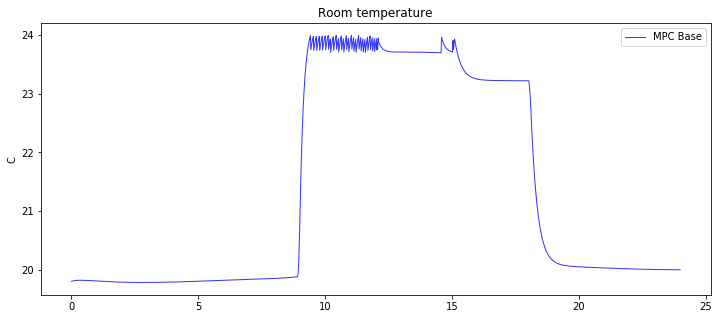

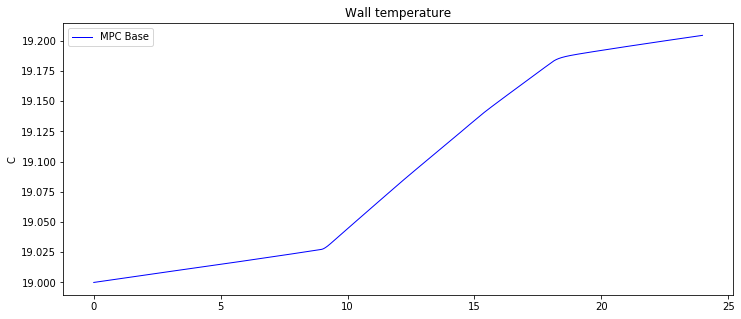

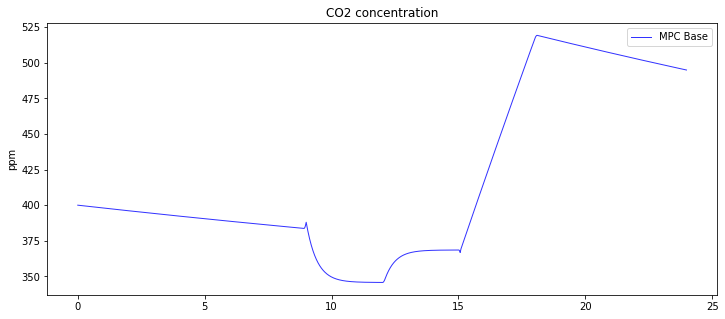

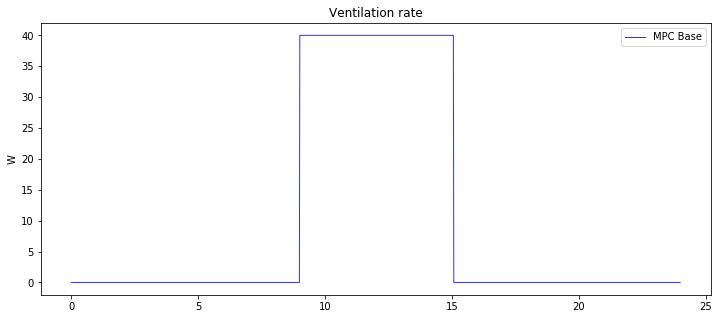

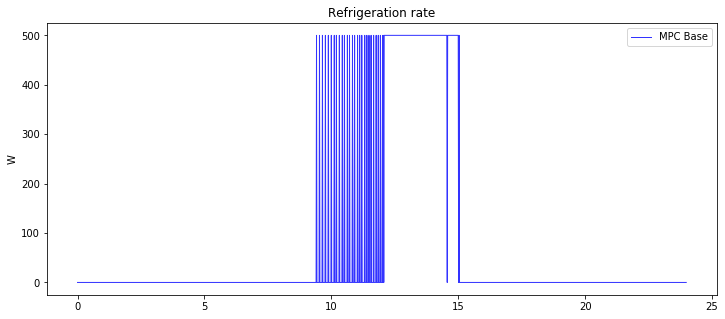

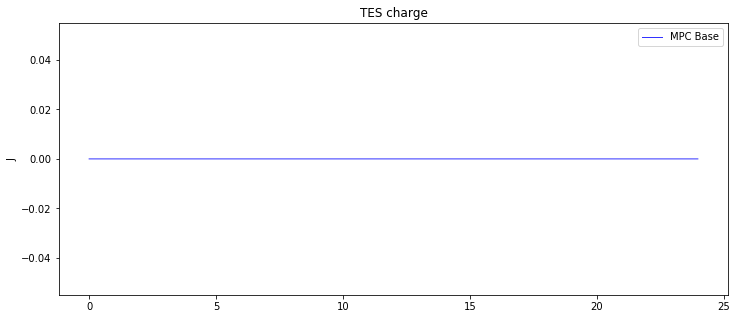

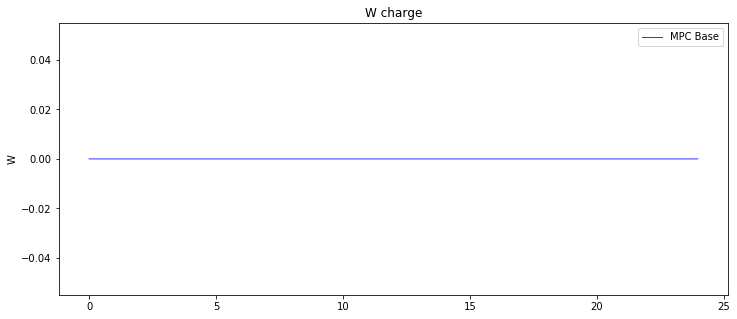

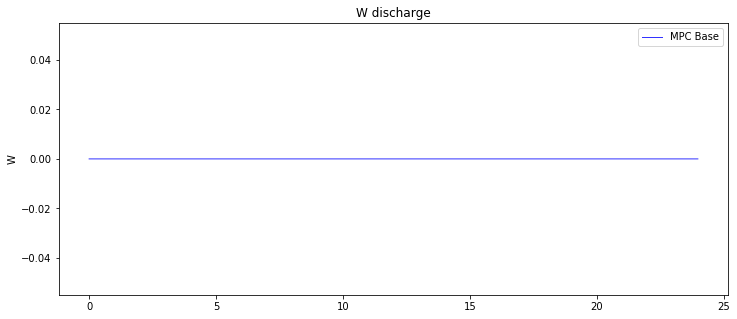

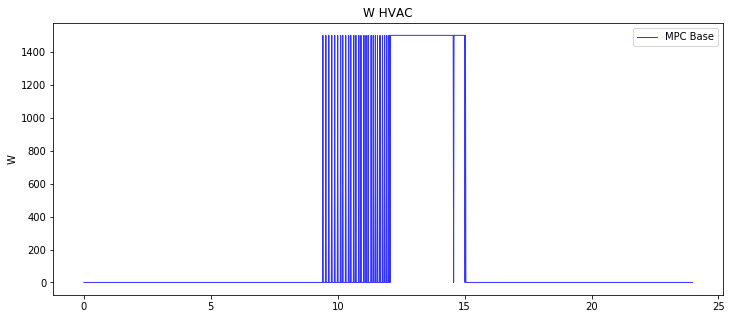

In [59]:
%%time
# USUAL MPC - increased price at 1.05 -> cost increased at 0%, cons at 0%


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')*1.05
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
# T_room_MPC = T_room
# n_CO2_MPC = n_CO2
# P_f_MPC = P_f_prev
# P_c_MPC = P_c_prev
# T_wall_MPC = T_wall
# W_HVAC_MPC = W_HVAC

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1378.1 LossCO2 =  0.0
Total summary P_c needed =  547.5  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1366.8 LossCO2 =  0.0
Total summary P_c needed =  1045.7  W * tau summary, Total summary P_f needed 2736.4  W * tau summary
Computed COMP:  500.0 Computed FAN:  560.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1359.4 LossCO2 =  0.0
Total summary P_c needed =  1044.7  W * tau summary, Total summary P_f needed 2925.2  W * tau summary
Computed COMP:  500.0 Computed FAN:  760.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1352.4 LossCO2 =  0.0
Total summary P_c needed =  1043.9  W * tau summary, Total summary P_f needed 3076.6  W * tau summary
Computed COMP:  500.0 Computed FAN:  920.0
iteration 

iteration =  34 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1187.4 LossCO2 =  0.0
Total summary P_c needed =  6523.9  W * tau summary, Total summary P_f needed 5774.8  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3760.0
iteration =  35 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1182.1 LossCO2 =  0.0
Total summary P_c needed =  6523.3  W * tau summary, Total summary P_f needed 5888.7  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3880.0
iteration =  36 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1178.3 LossCO2 =  0.0
Total summary P_c needed =  6522.9  W * tau summary, Total summary P_f needed 5964.6  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3960.0
iteration =  37 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1171.4 LossCO2 =  0.0
Total summary P_c needed =  7022.0  W * tau summary, Total summary P_f needed 6040.5  W * tau summary
Computed COMP:  6500.0 Computed FAN:  4040.0


iteration =  67 : with cost =  1.5  rub,  energy consumed =  0.3 kW*h,  LossT =  1003.7 LossCO2 =  0.0
Total summary P_c needed =  13001.6  W * tau summary, Total summary P_f needed 8724.6  W * tau summary
Computed COMP:  12500.0 Computed FAN:  6880.0
iteration =  68 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  996.9 LossCO2 =  0.0
Total summary P_c needed =  13500.7  W * tau summary, Total summary P_f needed 8800.0  W * tau summary
Computed COMP:  13000.0 Computed FAN:  6960.0
iteration =  69 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  991.4 LossCO2 =  0.0
Total summary P_c needed =  13500.1  W * tau summary, Total summary P_f needed 8913.2  W * tau summary
Computed COMP:  13000.0 Computed FAN:  7080.0
iteration =  70 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  984.6 LossCO2 =  0.0
Total summary P_c needed =  13999.2  W * tau summary, Total summary P_f needed 8988.7  W * tau summary
Computed COMP:  13500.0 Computed FAN:  71

iteration =  100 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  815.7 LossCO2 =  0.0
Total summary P_c needed =  27979.0  W * tau summary, Total summary P_f needed 10201.7  W * tau summary
Computed COMP:  27500.0 Computed FAN:  8480.0
iteration =  101 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  810.1 LossCO2 =  0.0
Total summary P_c needed =  28478.3  W * tau summary, Total summary P_f needed 10237.8  W * tau summary
Computed COMP:  28000.0 Computed FAN:  8520.0
iteration =  102 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  804.5 LossCO2 =  0.0
Total summary P_c needed =  28977.6  W * tau summary, Total summary P_f needed 10273.9  W * tau summary
Computed COMP:  28500.0 Computed FAN:  8560.0
iteration =  103 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  798.8 LossCO2 =  0.0
Total summary P_c needed =  29476.9  W * tau summary, Total summary P_f needed 10310.0  W * tau summary
Computed COMP:  29000.0 Computed F

iteration =  133 : with cost =  4.3  rub,  energy consumed =  0.9 kW*h,  LossT =  630.6 LossCO2 =  0.0
Total summary P_c needed =  44456.4  W * tau summary, Total summary P_f needed 11379.5  W * tau summary
Computed COMP:  44000.0 Computed FAN:  9800.0
iteration =  134 : with cost =  4.3  rub,  energy consumed =  0.9 kW*h,  LossT =  625.0 LossCO2 =  0.0
Total summary P_c needed =  44955.8  W * tau summary, Total summary P_f needed 11414.7  W * tau summary
Computed COMP:  44500.0 Computed FAN:  9840.0
iteration =  135 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  619.4 LossCO2 =  0.0
Total summary P_c needed =  45455.1  W * tau summary, Total summary P_f needed 11449.9  W * tau summary
Computed COMP:  45000.0 Computed FAN:  9880.0
iteration =  136 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  613.8 LossCO2 =  0.0
Total summary P_c needed =  45954.4  W * tau summary, Total summary P_f needed 11485.0  W * tau summary
Computed COMP:  45500.0 Computed F

iteration =  166 : with cost =  5.7  rub,  energy consumed =  1.2 kW*h,  LossT =  446.0 LossCO2 =  0.0
Total summary P_c needed =  60933.9  W * tau summary, Total summary P_f needed 12525.7  W * tau summary
Computed COMP:  60500.0 Computed FAN:  11120.0
iteration =  167 : with cost =  5.7  rub,  energy consumed =  1.2 kW*h,  LossT =  440.5 LossCO2 =  0.0
Total summary P_c needed =  61433.3  W * tau summary, Total summary P_f needed 12559.9  W * tau summary
Computed COMP:  61000.0 Computed FAN:  11160.0
iteration =  168 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  434.9 LossCO2 =  0.0
Total summary P_c needed =  61932.6  W * tau summary, Total summary P_f needed 12594.0  W * tau summary
Computed COMP:  61500.0 Computed FAN:  11200.0
iteration =  169 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  429.3 LossCO2 =  0.0
Total summary P_c needed =  62431.9  W * tau summary, Total summary P_f needed 12628.1  W * tau summary
Computed COMP:  62000.0 Compute

iteration =  199 : with cost =  7.1  rub,  energy consumed =  1.5 kW*h,  LossT =  262.3 LossCO2 =  0.0
Total summary P_c needed =  77411.4  W * tau summary, Total summary P_f needed 13631.5  W * tau summary
Computed COMP:  77000.0 Computed FAN:  12440.0
iteration =  200 : with cost =  7.1  rub,  energy consumed =  1.5 kW*h,  LossT =  256.8 LossCO2 =  0.0
Total summary P_c needed =  77910.8  W * tau summary, Total summary P_f needed 13664.2  W * tau summary
Computed COMP:  77500.0 Computed FAN:  12480.0
iteration =  201 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  251.2 LossCO2 =  0.0
Total summary P_c needed =  78410.1  W * tau summary, Total summary P_f needed 13696.8  W * tau summary
Computed COMP:  78000.0 Computed FAN:  12520.0
iteration =  202 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  245.7 LossCO2 =  0.0
Total summary P_c needed =  78909.4  W * tau summary, Total summary P_f needed 13729.4  W * tau summary
Computed COMP:  78500.0 Compute

iteration =  232 : with cost =  8.5  rub,  energy consumed =  1.8 kW*h,  LossT =  83.6 LossCO2 =  0.0
Total summary P_c needed =  93389.3  W * tau summary, Total summary P_f needed 14675.2  W * tau summary
Computed COMP:  93000.0 Computed FAN:  13760.0
iteration =  233 : with cost =  8.5  rub,  energy consumed =  1.8 kW*h,  LossT =  78.1 LossCO2 =  0.0
Total summary P_c needed =  93888.6  W * tau summary, Total summary P_f needed 14705.5  W * tau summary
Computed COMP:  93500.0 Computed FAN:  13800.0
iteration =  234 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  72.8 LossCO2 =  0.0
Total summary P_c needed =  94387.9  W * tau summary, Total summary P_f needed 14735.6  W * tau summary
Computed COMP:  94000.0 Computed FAN:  13840.0
iteration =  235 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  67.4 LossCO2 =  0.0
Total summary P_c needed =  94887.3  W * tau summary, Total summary P_f needed 14765.6  W * tau summary
Computed COMP:  94500.0 Computed FA

<function matplotlib.pyplot.show(*args, **kw)>

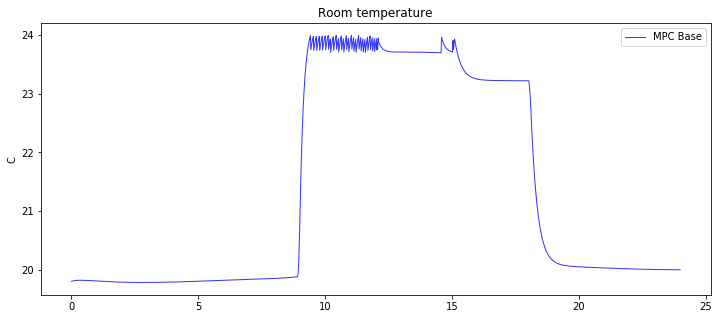

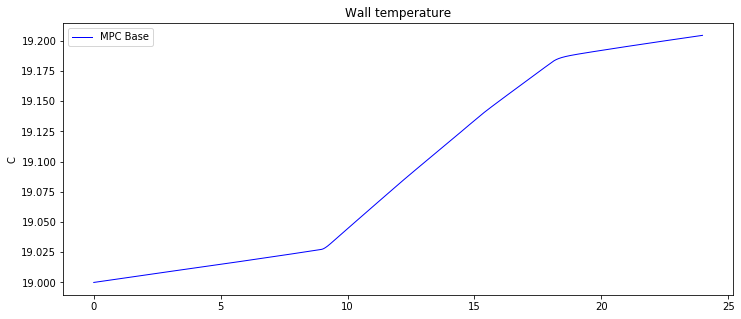

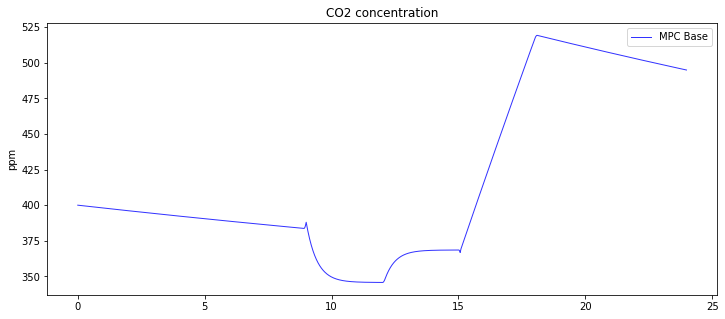

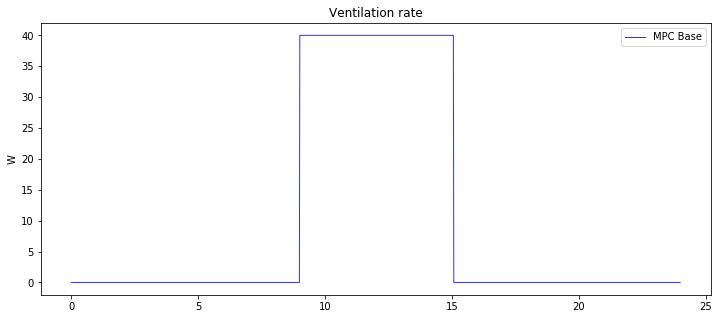

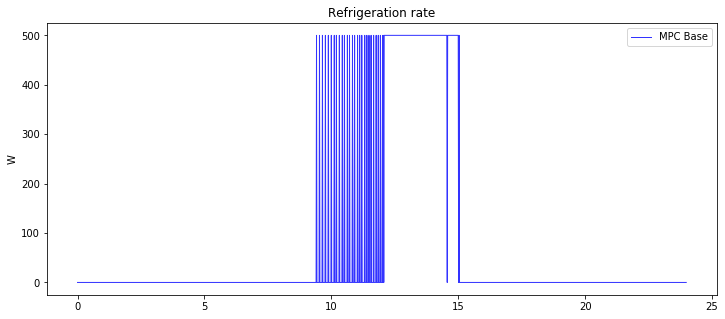

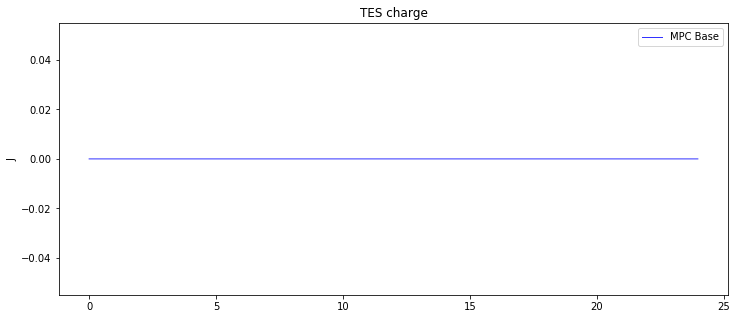

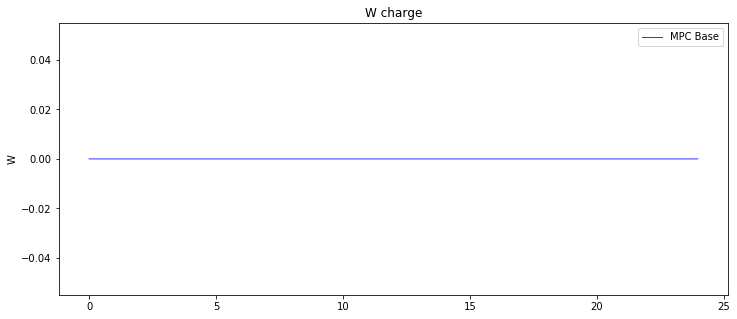

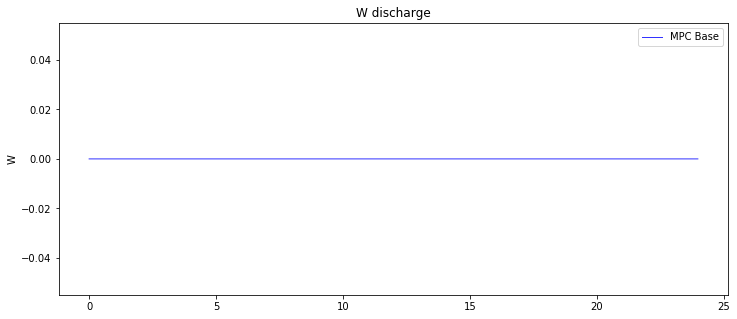

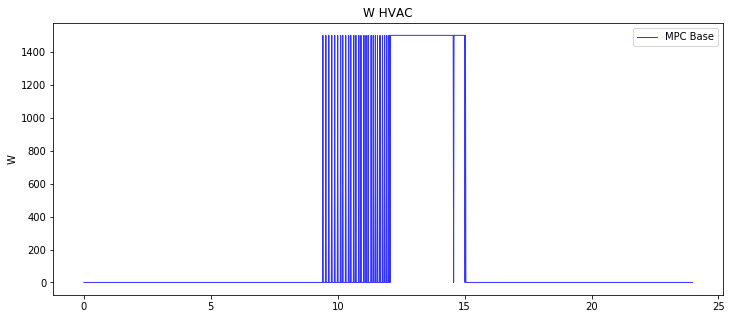

In [60]:
%%time
# USUAL MPC - decreased price at 0.95 -> cost decreased at 0%, cons at 0%


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')*0.95
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
# T_room_MPC = T_room
# n_CO2_MPC = n_CO2
# P_f_MPC = P_f_prev
# P_c_MPC = P_c_prev
# T_wall_MPC = T_wall
# W_HVAC_MPC = W_HVAC

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1363.7 LossCO2 =  0.0
Total summary P_c needed =  490.2  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1351.4 LossCO2 =  0.0
Total summary P_c needed =  988.2  W * tau summary, Total summary P_f needed 2774.2  W * tau summary
Computed COMP:  500.0 Computed FAN:  600.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1343.8 LossCO2 =  0.0
Total summary P_c needed =  987.3  W * tau summary, Total summary P_f needed 2963.1  W * tau summary
Computed COMP:  500.0 Computed FAN:  800.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1338.6 LossCO2 =  0.0
Total summary P_c needed =  986.7  W * tau summary, Total summary P_f needed 3076.6  W * tau summary
Computed COMP:  500.0 Computed FAN:  920.0
iteration =  

iteration =  34 : with cost =  0.7  rub,  energy consumed =  0.2 kW*h,  LossT =  1171.4 LossCO2 =  0.0
Total summary P_c needed =  5966.5  W * tau summary, Total summary P_f needed 5888.7  W * tau summary
Computed COMP:  5500.0 Computed FAN:  3880.0
iteration =  35 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1164.7 LossCO2 =  0.0
Total summary P_c needed =  6465.6  W * tau summary, Total summary P_f needed 5964.6  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3960.0
iteration =  36 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1159.4 LossCO2 =  0.0
Total summary P_c needed =  6465.0  W * tau summary, Total summary P_f needed 6078.4  W * tau summary
Computed COMP:  6000.0 Computed FAN:  4080.0
iteration =  37 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1153.7 LossCO2 =  0.0
Total summary P_c needed =  6464.4  W * tau summary, Total summary P_f needed 6192.2  W * tau summary
Computed COMP:  6000.0 Computed FAN:  4200.0


iteration =  67 : with cost =  1.5  rub,  energy consumed =  0.3 kW*h,  LossT =  986.6 LossCO2 =  0.0
Total summary P_c needed =  12444.0  W * tau summary, Total summary P_f needed 8875.5  W * tau summary
Computed COMP:  12000.0 Computed FAN:  7040.0
iteration =  68 : with cost =  1.5  rub,  energy consumed =  0.3 kW*h,  LossT =  979.6 LossCO2 =  0.0
Total summary P_c needed =  12943.1  W * tau summary, Total summary P_f needed 8951.0  W * tau summary
Computed COMP:  12500.0 Computed FAN:  7120.0
iteration =  69 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  974.1 LossCO2 =  0.0
Total summary P_c needed =  12942.4  W * tau summary, Total summary P_f needed 9064.3  W * tau summary
Computed COMP:  12500.0 Computed FAN:  7240.0
iteration =  70 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  967.0 LossCO2 =  0.0
Total summary P_c needed =  13441.6  W * tau summary, Total summary P_f needed 9139.5  W * tau summary
Computed COMP:  13000.0 Computed FAN:  732

iteration =  100 : with cost =  2.8  rub,  energy consumed =  0.6 kW*h,  LossT =  806.9 LossCO2 =  0.0
Total summary P_c needed =  26922.4  W * tau summary, Total summary P_f needed 10237.8  W * tau summary
Computed COMP:  26500.0 Computed FAN:  8520.0
iteration =  101 : with cost =  2.8  rub,  energy consumed =  0.6 kW*h,  LossT =  801.0 LossCO2 =  0.0
Total summary P_c needed =  27421.7  W * tau summary, Total summary P_f needed 10273.9  W * tau summary
Computed COMP:  27000.0 Computed FAN:  8560.0
iteration =  102 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  795.1 LossCO2 =  0.0
Total summary P_c needed =  27921.0  W * tau summary, Total summary P_f needed 10310.0  W * tau summary
Computed COMP:  27500.0 Computed FAN:  8600.0
iteration =  103 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  789.2 LossCO2 =  0.0
Total summary P_c needed =  28420.3  W * tau summary, Total summary P_f needed 10346.1  W * tau summary
Computed COMP:  28000.0 Computed F

iteration =  133 : with cost =  4.2  rub,  energy consumed =  0.9 kW*h,  LossT =  621.8 LossCO2 =  0.0
Total summary P_c needed =  42900.2  W * tau summary, Total summary P_f needed 11414.7  W * tau summary
Computed COMP:  42500.0 Computed FAN:  9840.0
iteration =  134 : with cost =  4.2  rub,  energy consumed =  0.9 kW*h,  LossT =  616.0 LossCO2 =  0.0
Total summary P_c needed =  43399.5  W * tau summary, Total summary P_f needed 11449.9  W * tau summary
Computed COMP:  43000.0 Computed FAN:  9880.0
iteration =  135 : with cost =  4.2  rub,  energy consumed =  0.9 kW*h,  LossT =  610.2 LossCO2 =  0.0
Total summary P_c needed =  43898.8  W * tau summary, Total summary P_f needed 11485.0  W * tau summary
Computed COMP:  43500.0 Computed FAN:  9920.0
iteration =  136 : with cost =  4.3  rub,  energy consumed =  0.9 kW*h,  LossT =  604.5 LossCO2 =  0.0
Total summary P_c needed =  44398.1  W * tau summary, Total summary P_f needed 11520.2  W * tau summary
Computed COMP:  44000.0 Computed F

iteration =  166 : with cost =  5.5  rub,  energy consumed =  1.2 kW*h,  LossT =  437.6 LossCO2 =  0.0
Total summary P_c needed =  58878.0  W * tau summary, Total summary P_f needed 12559.9  W * tau summary
Computed COMP:  58500.0 Computed FAN:  11160.0
iteration =  167 : with cost =  5.6  rub,  energy consumed =  1.2 kW*h,  LossT =  432.0 LossCO2 =  0.0
Total summary P_c needed =  59377.3  W * tau summary, Total summary P_f needed 12594.0  W * tau summary
Computed COMP:  59000.0 Computed FAN:  11200.0
iteration =  168 : with cost =  5.6  rub,  energy consumed =  1.2 kW*h,  LossT =  426.3 LossCO2 =  0.0
Total summary P_c needed =  59876.6  W * tau summary, Total summary P_f needed 12628.1  W * tau summary
Computed COMP:  59500.0 Computed FAN:  11240.0
iteration =  169 : with cost =  5.7  rub,  energy consumed =  1.2 kW*h,  LossT =  420.7 LossCO2 =  0.0
Total summary P_c needed =  60375.9  W * tau summary, Total summary P_f needed 12662.2  W * tau summary
Computed COMP:  60000.0 Compute

iteration =  199 : with cost =  6.9  rub,  energy consumed =  1.4 kW*h,  LossT =  254.6 LossCO2 =  0.0
Total summary P_c needed =  74855.8  W * tau summary, Total summary P_f needed 13664.2  W * tau summary
Computed COMP:  74500.0 Computed FAN:  12480.0
iteration =  200 : with cost =  7.0  rub,  energy consumed =  1.5 kW*h,  LossT =  249.1 LossCO2 =  0.0
Total summary P_c needed =  75355.1  W * tau summary, Total summary P_f needed 13696.8  W * tau summary
Computed COMP:  75000.0 Computed FAN:  12520.0
iteration =  201 : with cost =  7.0  rub,  energy consumed =  1.5 kW*h,  LossT =  243.5 LossCO2 =  0.0
Total summary P_c needed =  75854.4  W * tau summary, Total summary P_f needed 13729.4  W * tau summary
Computed COMP:  75500.0 Computed FAN:  12560.0
iteration =  202 : with cost =  7.0  rub,  energy consumed =  1.5 kW*h,  LossT =  238.0 LossCO2 =  0.0
Total summary P_c needed =  76353.7  W * tau summary, Total summary P_f needed 13761.9  W * tau summary
Computed COMP:  76000.0 Compute

iteration =  232 : with cost =  8.2  rub,  energy consumed =  1.7 kW*h,  LossT =  78.7 LossCO2 =  0.0
Total summary P_c needed =  90334.1  W * tau summary, Total summary P_f needed 14705.5  W * tau summary
Computed COMP:  90000.0 Computed FAN:  13800.0
iteration =  233 : with cost =  8.3  rub,  energy consumed =  1.7 kW*h,  LossT =  73.2 LossCO2 =  0.0
Total summary P_c needed =  90833.4  W * tau summary, Total summary P_f needed 14735.6  W * tau summary
Computed COMP:  90500.0 Computed FAN:  13840.0
iteration =  234 : with cost =  8.3  rub,  energy consumed =  1.7 kW*h,  LossT =  67.7 LossCO2 =  0.0
Total summary P_c needed =  91332.7  W * tau summary, Total summary P_f needed 14765.6  W * tau summary
Computed COMP:  91000.0 Computed FAN:  13880.0
iteration =  235 : with cost =  8.4  rub,  energy consumed =  1.8 kW*h,  LossT =  62.3 LossCO2 =  0.0
Total summary P_c needed =  91832.0  W * tau summary, Total summary P_f needed 14795.6  W * tau summary
Computed COMP:  91500.0 Computed FA

<function matplotlib.pyplot.show(*args, **kw)>

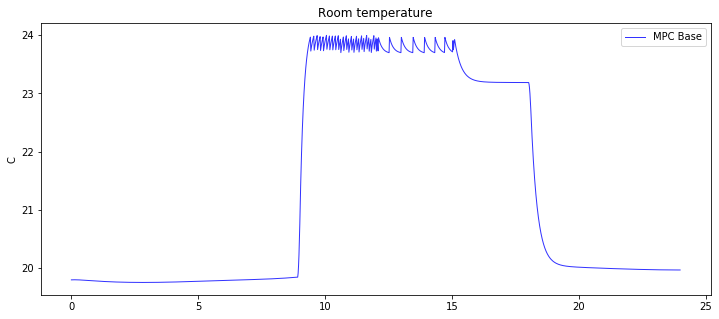

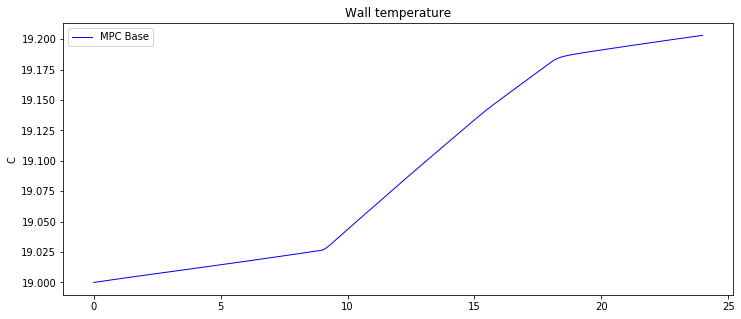

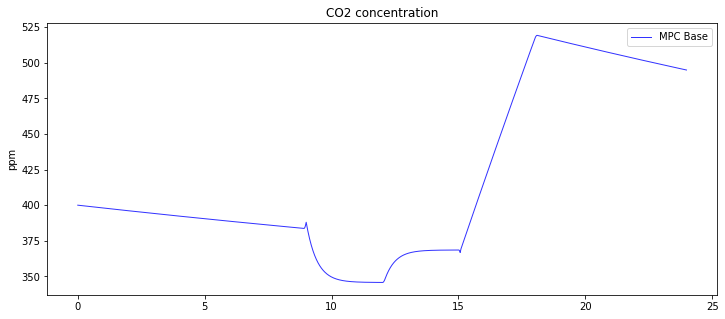

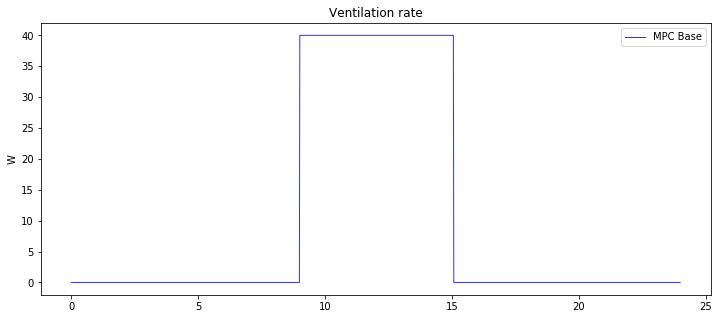

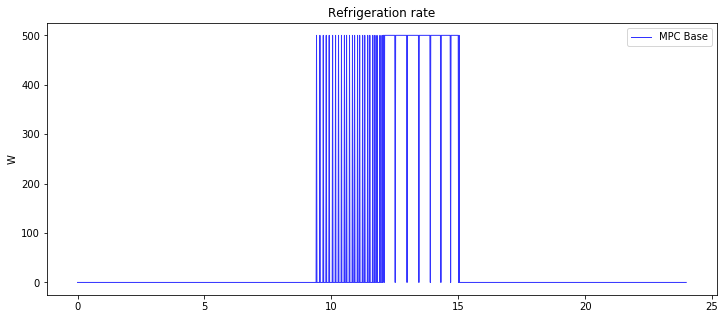

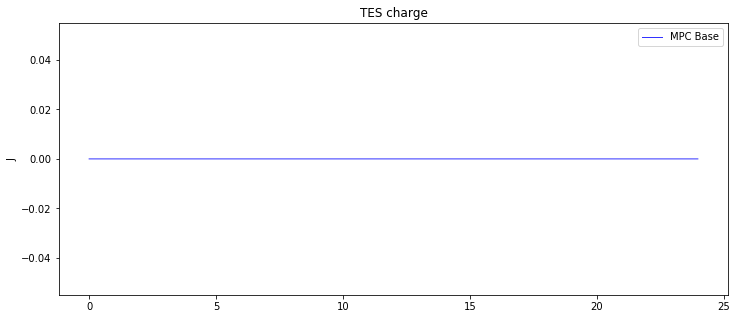

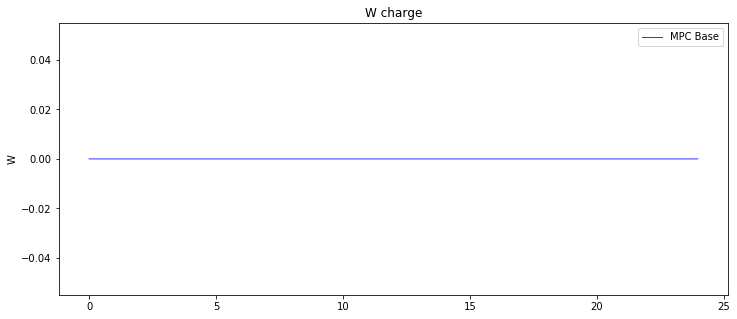

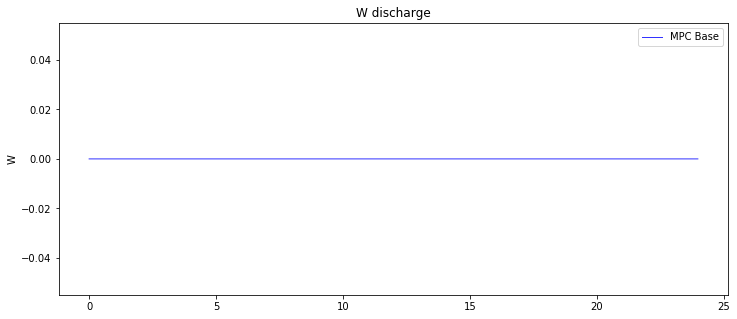

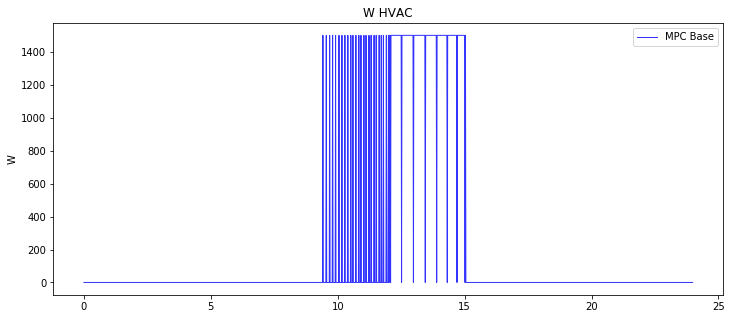

In [58]:
%%time
# USUAL MPC - decreased outtemp at 0.95 -> cost increased at 1%, cons at 0%


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')*0.95

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
# T_room_MPC = T_room
# n_CO2_MPC = n_CO2
# P_f_MPC = P_f_prev
# P_c_MPC = P_c_prev
# T_wall_MPC = T_wall
# W_HVAC_MPC = W_HVAC

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1392.5 LossCO2 =  0.0
Total summary P_c needed =  604.8  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1380.9 LossCO2 =  0.0
Total summary P_c needed =  1103.0  W * tau summary, Total summary P_f needed 2736.4  W * tau summary
Computed COMP:  500.0 Computed FAN:  560.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1373.3 LossCO2 =  0.0
Total summary P_c needed =  1102.0  W * tau summary, Total summary P_f needed 2925.2  W * tau summary
Computed COMP:  500.0 Computed FAN:  760.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1368.1 LossCO2 =  0.0
Total summary P_c needed =  1101.4  W * tau summary, Total summary P_f needed 3038.7  W * tau summary
Computed COMP:  500.0 Computed FAN:  880.0
iteration 

iteration =  34 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1196.3 LossCO2 =  0.0
Total summary P_c needed =  7080.6  W * tau summary, Total summary P_f needed 5812.8  W * tau summary
Computed COMP:  6500.0 Computed FAN:  3800.0
iteration =  35 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1190.9 LossCO2 =  0.0
Total summary P_c needed =  7079.9  W * tau summary, Total summary P_f needed 5926.6  W * tau summary
Computed COMP:  6500.0 Computed FAN:  3920.0
iteration =  36 : with cost =  0.9  rub,  energy consumed =  0.2 kW*h,  LossT =  1184.1 LossCO2 =  0.0
Total summary P_c needed =  7579.1  W * tau summary, Total summary P_f needed 6002.5  W * tau summary
Computed COMP:  7000.0 Computed FAN:  4000.0
iteration =  37 : with cost =  0.9  rub,  energy consumed =  0.2 kW*h,  LossT =  1178.8 LossCO2 =  0.0
Total summary P_c needed =  7578.5  W * tau summary, Total summary P_f needed 6116.3  W * tau summary
Computed COMP:  7000.0 Computed FAN:  4120.0


iteration =  67 : with cost =  1.7  rub,  energy consumed =  0.3 kW*h,  LossT =  1004.8 LossCO2 =  0.0
Total summary P_c needed =  14557.1  W * tau summary, Total summary P_f needed 8800.0  W * tau summary
Computed COMP:  14000.0 Computed FAN:  6960.0
iteration =  68 : with cost =  1.7  rub,  energy consumed =  0.4 kW*h,  LossT =  999.3 LossCO2 =  0.0
Total summary P_c needed =  14556.5  W * tau summary, Total summary P_f needed 8913.2  W * tau summary
Computed COMP:  14000.0 Computed FAN:  7080.0
iteration =  69 : with cost =  1.7  rub,  energy consumed =  0.4 kW*h,  LossT =  992.5 LossCO2 =  0.0
Total summary P_c needed =  15055.6  W * tau summary, Total summary P_f needed 8988.7  W * tau summary
Computed COMP:  14500.0 Computed FAN:  7160.0
iteration =  70 : with cost =  1.7  rub,  energy consumed =  0.4 kW*h,  LossT =  986.9 LossCO2 =  0.0
Total summary P_c needed =  15055.0  W * tau summary, Total summary P_f needed 9102.0  W * tau summary
Computed COMP:  14500.0 Computed FAN:  72

iteration =  100 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  816.9 LossCO2 =  0.0
Total summary P_c needed =  29534.6  W * tau summary, Total summary P_f needed 10237.8  W * tau summary
Computed COMP:  29000.0 Computed FAN:  8520.0
iteration =  101 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  811.2 LossCO2 =  0.0
Total summary P_c needed =  30034.0  W * tau summary, Total summary P_f needed 10273.9  W * tau summary
Computed COMP:  29500.0 Computed FAN:  8560.0
iteration =  102 : with cost =  3.1  rub,  energy consumed =  0.6 kW*h,  LossT =  805.6 LossCO2 =  0.0
Total summary P_c needed =  30533.3  W * tau summary, Total summary P_f needed 10310.0  W * tau summary
Computed COMP:  30000.0 Computed FAN:  8600.0
iteration =  103 : with cost =  3.1  rub,  energy consumed =  0.7 kW*h,  LossT =  799.9 LossCO2 =  0.0
Total summary P_c needed =  31032.6  W * tau summary, Total summary P_f needed 10346.1  W * tau summary
Computed COMP:  30500.0 Computed F

iteration =  133 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  630.5 LossCO2 =  0.0
Total summary P_c needed =  46012.1  W * tau summary, Total summary P_f needed 11414.7  W * tau summary
Computed COMP:  45500.0 Computed FAN:  9840.0
iteration =  134 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  624.8 LossCO2 =  0.0
Total summary P_c needed =  46511.4  W * tau summary, Total summary P_f needed 11449.9  W * tau summary
Computed COMP:  46000.0 Computed FAN:  9880.0
iteration =  135 : with cost =  4.5  rub,  energy consumed =  0.9 kW*h,  LossT =  619.2 LossCO2 =  0.0
Total summary P_c needed =  47010.7  W * tau summary, Total summary P_f needed 11485.0  W * tau summary
Computed COMP:  46500.0 Computed FAN:  9920.0
iteration =  136 : with cost =  4.5  rub,  energy consumed =  0.9 kW*h,  LossT =  613.6 LossCO2 =  0.0
Total summary P_c needed =  47510.0  W * tau summary, Total summary P_f needed 11520.2  W * tau summary
Computed COMP:  47000.0 Computed F

iteration =  166 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  444.6 LossCO2 =  0.0
Total summary P_c needed =  62489.5  W * tau summary, Total summary P_f needed 12559.9  W * tau summary
Computed COMP:  62000.0 Computed FAN:  11160.0
iteration =  167 : with cost =  5.9  rub,  energy consumed =  1.2 kW*h,  LossT =  439.0 LossCO2 =  0.0
Total summary P_c needed =  62988.8  W * tau summary, Total summary P_f needed 12594.0  W * tau summary
Computed COMP:  62500.0 Computed FAN:  11200.0
iteration =  168 : with cost =  5.9  rub,  energy consumed =  1.2 kW*h,  LossT =  433.4 LossCO2 =  0.0
Total summary P_c needed =  63488.1  W * tau summary, Total summary P_f needed 12628.1  W * tau summary
Computed COMP:  63000.0 Computed FAN:  11240.0
iteration =  169 : with cost =  5.9  rub,  energy consumed =  1.2 kW*h,  LossT =  427.8 LossCO2 =  0.0
Total summary P_c needed =  63987.5  W * tau summary, Total summary P_f needed 12662.2  W * tau summary
Computed COMP:  63500.0 Compute

iteration =  199 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  259.7 LossCO2 =  0.0
Total summary P_c needed =  78966.9  W * tau summary, Total summary P_f needed 13664.2  W * tau summary
Computed COMP:  78500.0 Computed FAN:  12480.0
iteration =  200 : with cost =  7.3  rub,  energy consumed =  1.5 kW*h,  LossT =  254.1 LossCO2 =  0.0
Total summary P_c needed =  79466.3  W * tau summary, Total summary P_f needed 13696.8  W * tau summary
Computed COMP:  79000.0 Computed FAN:  12520.0
iteration =  201 : with cost =  7.3  rub,  energy consumed =  1.5 kW*h,  LossT =  248.5 LossCO2 =  0.0
Total summary P_c needed =  79965.6  W * tau summary, Total summary P_f needed 13729.4  W * tau summary
Computed COMP:  79500.0 Computed FAN:  12560.0
iteration =  202 : with cost =  7.4  rub,  energy consumed =  1.5 kW*h,  LossT =  242.9 LossCO2 =  0.0
Total summary P_c needed =  80464.9  W * tau summary, Total summary P_f needed 13761.9  W * tau summary
Computed COMP:  80000.0 Compute

iteration =  232 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  78.3 LossCO2 =  0.0
Total summary P_c needed =  95444.4  W * tau summary, Total summary P_f needed 14705.5  W * tau summary
Computed COMP:  95000.0 Computed FAN:  13800.0
iteration =  233 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  73.1 LossCO2 =  0.0
Total summary P_c needed =  95943.7  W * tau summary, Total summary P_f needed 14735.6  W * tau summary
Computed COMP:  95500.0 Computed FAN:  13840.0
iteration =  234 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  67.8 LossCO2 =  0.0
Total summary P_c needed =  96443.0  W * tau summary, Total summary P_f needed 14765.6  W * tau summary
Computed COMP:  96000.0 Computed FAN:  13880.0
iteration =  235 : with cost =  8.8  rub,  energy consumed =  1.8 kW*h,  LossT =  62.6 LossCO2 =  0.0
Total summary P_c needed =  96942.4  W * tau summary, Total summary P_f needed 14795.6  W * tau summary
Computed COMP:  96500.0 Computed FA

<function matplotlib.pyplot.show(*args, **kw)>

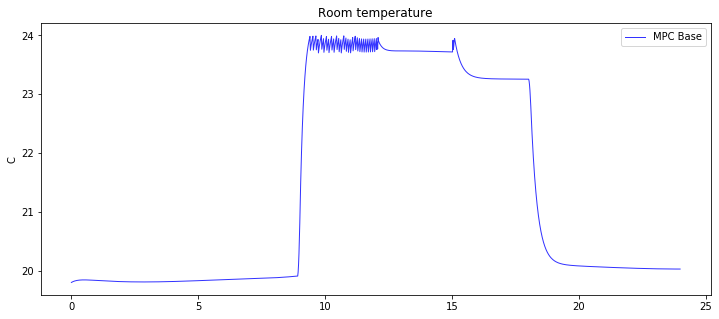

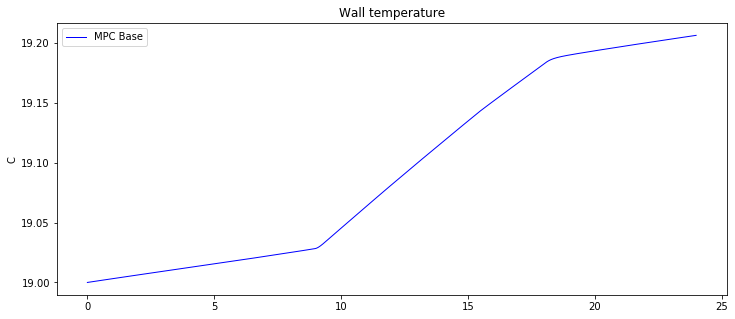

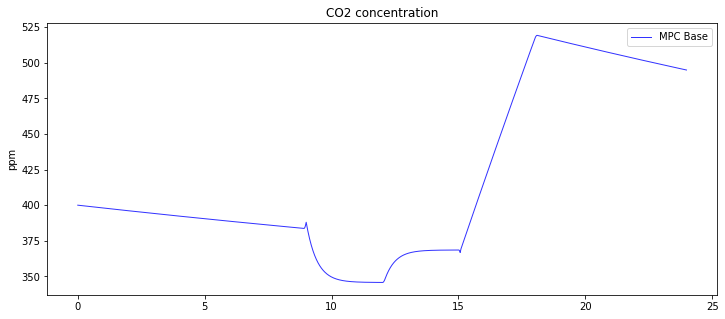

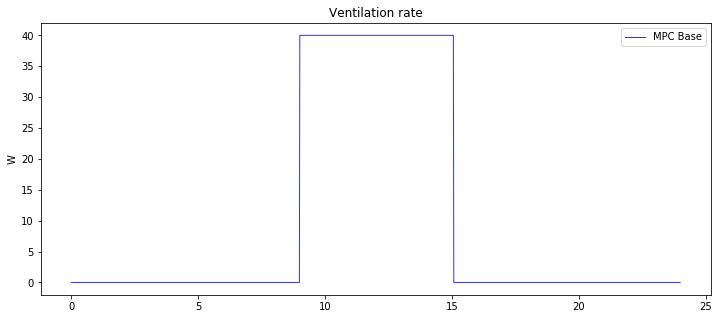

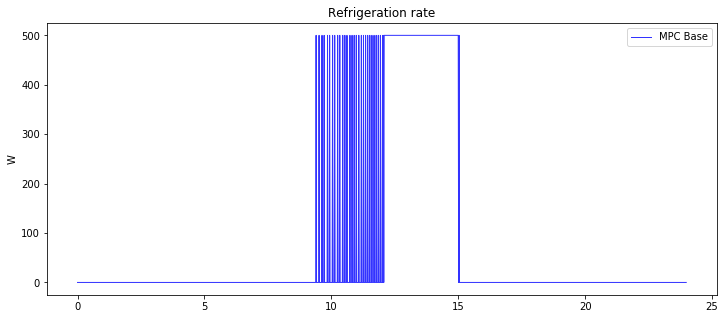

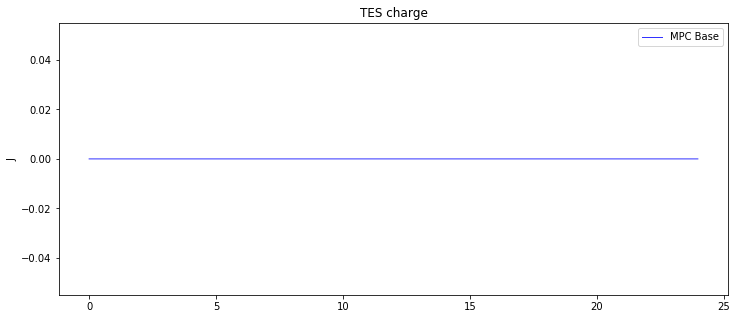

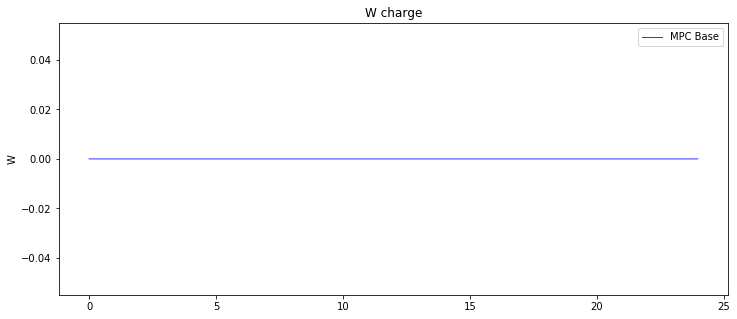

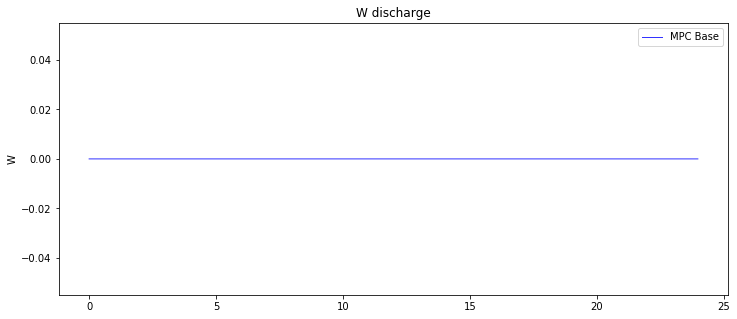

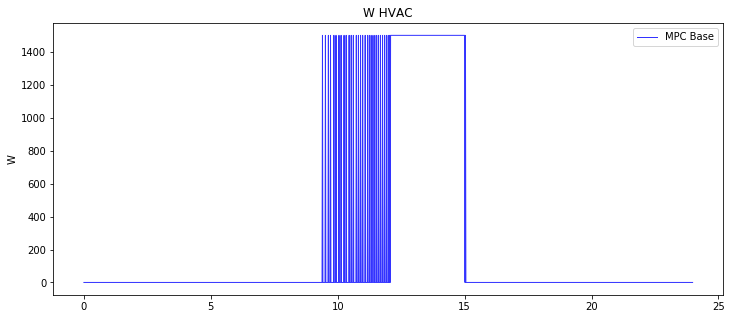

In [57]:
%%time
# USUAL MPC - increased outtemp at 1.05 -> cost increased at 1%, cons at 5%


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')*1.05

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
# T_room_MPC = T_room
# n_CO2_MPC = n_CO2
# P_f_MPC = P_f_prev
# P_c_MPC = P_c_prev
# T_wall_MPC = T_wall
# W_HVAC_MPC = W_HVAC

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1233.2 LossCO2 =  0.0
Total summary P_c needed =  527.5  W * tau summary, Total summary P_f needed 2161.7  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1221.2 LossCO2 =  0.0
Total summary P_c needed =  1025.4  W * tau summary, Total summary P_f needed 2761.0  W * tau summary
Computed COMP:  500.0 Computed FAN:  640.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1212.8 LossCO2 =  0.0
Total summary P_c needed =  1024.3  W * tau summary, Total summary P_f needed 2987.5  W * tau summary
Computed COMP:  500.0 Computed FAN:  880.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1206.4 LossCO2 =  0.0
Total summary P_c needed =  1023.5  W * tau summary, Total summary P_f needed 3138.9  W * tau summary
Computed COMP:  500.0 Computed FAN:  1040.0
iteration

iteration =  34 : with cost =  0.7  rub,  energy consumed =  0.1 kW*h,  LossT =  1017.5 LossCO2 =  0.0
Total summary P_c needed =  4500.5  W * tau summary, Total summary P_f needed 6746.1  W * tau summary
Computed COMP:  4000.0 Computed FAN:  4840.0
iteration =  35 : with cost =  0.7  rub,  energy consumed =  0.1 kW*h,  LossT =  1012.1 LossCO2 =  0.0
Total summary P_c needed =  4499.9  W * tau summary, Total summary P_f needed 6859.7  W * tau summary
Computed COMP:  4000.0 Computed FAN:  4960.0
iteration =  36 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1003.9 LossCO2 =  0.0
Total summary P_c needed =  4998.8  W * tau summary, Total summary P_f needed 6973.2  W * tau summary
Computed COMP:  4500.0 Computed FAN:  5080.0
iteration =  37 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  997.0 LossCO2 =  0.0
Total summary P_c needed =  4998.0  W * tau summary, Total summary P_f needed 7124.5  W * tau summary
Computed COMP:  4500.0 Computed FAN:  5240.0
i

iteration =  67 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  823.8 LossCO2 =  0.0
Total summary P_c needed =  12976.9  W * tau summary, Total summary P_f needed 9567.1  W * tau summary
Computed COMP:  12500.0 Computed FAN:  7840.0
iteration =  68 : with cost =  1.7  rub,  energy consumed =  0.3 kW*h,  LossT =  818.2 LossCO2 =  0.0
Total summary P_c needed =  13476.2  W * tau summary, Total summary P_f needed 9603.7  W * tau summary
Computed COMP:  13000.0 Computed FAN:  7880.0
iteration =  69 : with cost =  1.7  rub,  energy consumed =  0.3 kW*h,  LossT =  816.2 LossCO2 =  0.0
Total summary P_c needed =  13476.0  W * tau summary, Total summary P_f needed 9640.3  W * tau summary
Computed COMP:  13000.0 Computed FAN:  7920.0
iteration =  70 : with cost =  1.7  rub,  energy consumed =  0.4 kW*h,  LossT =  810.4 LossCO2 =  0.0
Total summary P_c needed =  13975.3  W * tau summary, Total summary P_f needed 9676.9  W * tau summary
Computed COMP:  13500.0 Computed FAN:  796

iteration =  100 : with cost =  2.8  rub,  energy consumed =  0.6 kW*h,  LossT =  657.6 LossCO2 =  0.0
Total summary P_c needed =  26457.0  W * tau summary, Total summary P_f needed 10759.8  W * tau summary
Computed COMP:  26000.0 Computed FAN:  9160.0
iteration =  101 : with cost =  2.8  rub,  energy consumed =  0.6 kW*h,  LossT =  651.7 LossCO2 =  0.0
Total summary P_c needed =  26956.3  W * tau summary, Total summary P_f needed 10795.4  W * tau summary
Computed COMP:  26500.0 Computed FAN:  9200.0
iteration =  102 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  645.9 LossCO2 =  0.0
Total summary P_c needed =  27455.6  W * tau summary, Total summary P_f needed 10831.1  W * tau summary
Computed COMP:  27000.0 Computed FAN:  9240.0
iteration =  103 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  640.2 LossCO2 =  0.0
Total summary P_c needed =  27955.0  W * tau summary, Total summary P_f needed 10866.7  W * tau summary
Computed COMP:  27500.0 Computed F

iteration =  133 : with cost =  4.0  rub,  energy consumed =  0.8 kW*h,  LossT =  487.7 LossCO2 =  0.0
Total summary P_c needed =  40436.7  W * tau summary, Total summary P_f needed 11921.8  W * tau summary
Computed COMP:  40000.0 Computed FAN:  10480.0
iteration =  134 : with cost =  4.1  rub,  energy consumed =  0.9 kW*h,  LossT =  481.9 LossCO2 =  0.0
Total summary P_c needed =  40936.0  W * tau summary, Total summary P_f needed 11956.6  W * tau summary
Computed COMP:  40500.0 Computed FAN:  10520.0
iteration =  135 : with cost =  4.1  rub,  energy consumed =  0.9 kW*h,  LossT =  476.2 LossCO2 =  0.0
Total summary P_c needed =  41435.3  W * tau summary, Total summary P_f needed 11991.2  W * tau summary
Computed COMP:  41000.0 Computed FAN:  10560.0
iteration =  136 : with cost =  4.1  rub,  energy consumed =  0.9 kW*h,  LossT =  470.6 LossCO2 =  0.0
Total summary P_c needed =  41934.6  W * tau summary, Total summary P_f needed 12025.9  W * tau summary
Computed COMP:  41500.0 Compute

iteration =  166 : with cost =  5.2  rub,  energy consumed =  1.1 kW*h,  LossT =  318.4 LossCO2 =  0.0
Total summary P_c needed =  54416.3  W * tau summary, Total summary P_f needed 13049.0  W * tau summary
Computed COMP:  54000.0 Computed FAN:  11800.0
iteration =  167 : with cost =  5.3  rub,  energy consumed =  1.1 kW*h,  LossT =  312.7 LossCO2 =  0.0
Total summary P_c needed =  54915.7  W * tau summary, Total summary P_f needed 13082.5  W * tau summary
Computed COMP:  54500.0 Computed FAN:  11840.0
iteration =  168 : with cost =  5.3  rub,  energy consumed =  1.1 kW*h,  LossT =  307.1 LossCO2 =  0.0
Total summary P_c needed =  55415.0  W * tau summary, Total summary P_f needed 13115.9  W * tau summary
Computed COMP:  55000.0 Computed FAN:  11880.0
iteration =  169 : with cost =  5.4  rub,  energy consumed =  1.1 kW*h,  LossT =  301.5 LossCO2 =  0.0
Total summary P_c needed =  55914.3  W * tau summary, Total summary P_f needed 13149.3  W * tau summary
Computed COMP:  55500.0 Compute

iteration =  199 : with cost =  6.4  rub,  energy consumed =  1.4 kW*h,  LossT =  150.4 LossCO2 =  0.0
Total summary P_c needed =  68396.0  W * tau summary, Total summary P_f needed 14126.7  W * tau summary
Computed COMP:  68000.0 Computed FAN:  13120.0
iteration =  200 : with cost =  6.5  rub,  energy consumed =  1.4 kW*h,  LossT =  145.0 LossCO2 =  0.0
Total summary P_c needed =  68895.3  W * tau summary, Total summary P_f needed 14158.3  W * tau summary
Computed COMP:  68500.0 Computed FAN:  13160.0
iteration =  201 : with cost =  6.5  rub,  energy consumed =  1.4 kW*h,  LossT =  143.1 LossCO2 =  0.0
Total summary P_c needed =  68895.1  W * tau summary, Total summary P_f needed 14189.8  W * tau summary
Computed COMP:  68500.0 Computed FAN:  13200.0
iteration =  202 : with cost =  6.5  rub,  energy consumed =  1.4 kW*h,  LossT =  137.4 LossCO2 =  0.0
Total summary P_c needed =  69394.4  W * tau summary, Total summary P_f needed 14221.3  W * tau summary
Computed COMP:  69000.0 Compute

iteration =  232 : with cost =  7.6  rub,  energy consumed =  1.6 kW*h,  LossT =  2.7 LossCO2 =  0.0
Total summary P_c needed =  81876.1  W * tau summary, Total summary P_f needed 15121.2  W * tau summary
Computed COMP:  81500.0 Computed FAN:  14440.0
iteration =  233 : with cost =  7.7  rub,  energy consumed =  1.6 kW*h,  LossT =  0.5 LossCO2 =  0.0
Total summary P_c needed =  82375.4  W * tau summary, Total summary P_f needed 15149.4  W * tau summary
Computed COMP:  82000.0 Computed FAN:  14480.0
iteration =  234 : with cost =  7.7  rub,  energy consumed =  1.6 kW*h,  LossT =  0.0 LossCO2 =  0.0
Total summary P_c needed =  82874.5  W * tau summary, Total summary P_f needed 15206.2  W * tau summary
Computed COMP:  82500.0 Computed FAN:  14560.0
iteration =  235 : with cost =  7.7  rub,  energy consumed =  1.6 kW*h,  LossT =  0.0 LossCO2 =  0.0
Total summary P_c needed =  82375.0  W * tau summary, Total summary P_f needed 15206.2  W * tau summary
Computed COMP:  82000.0 Computed FAN:  

<function matplotlib.pyplot.show(*args, **kw)>

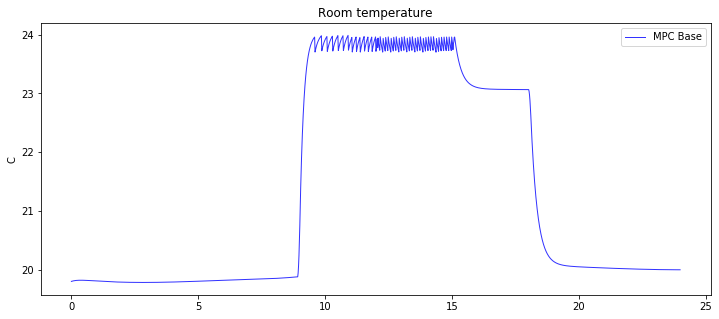

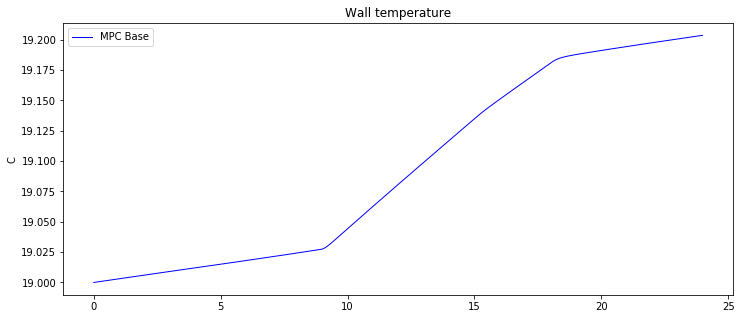

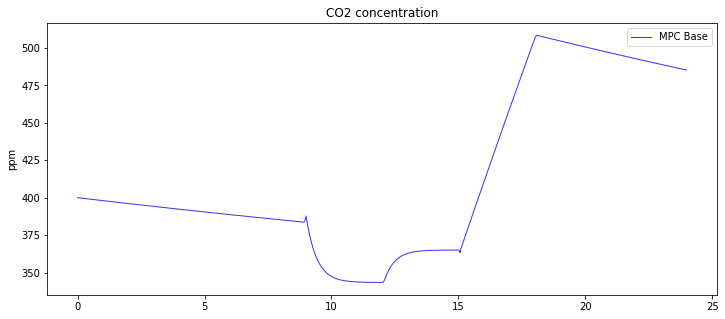

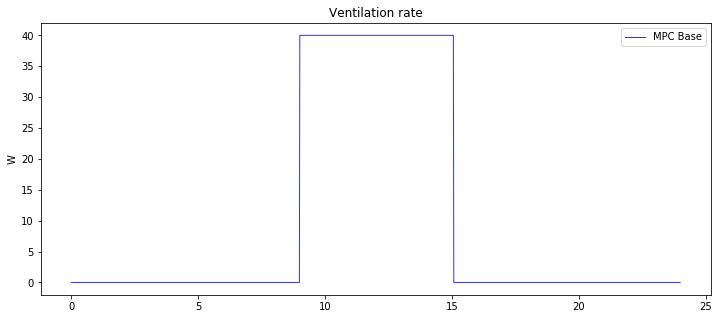

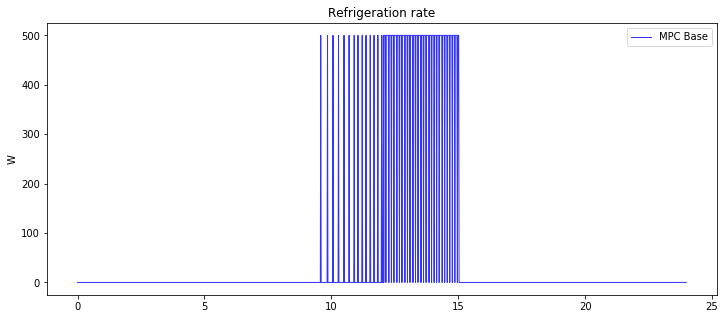

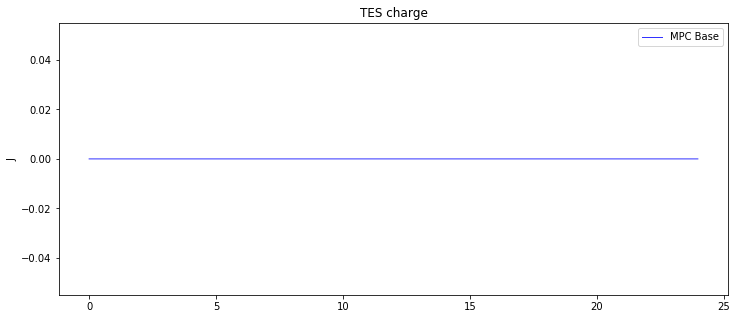

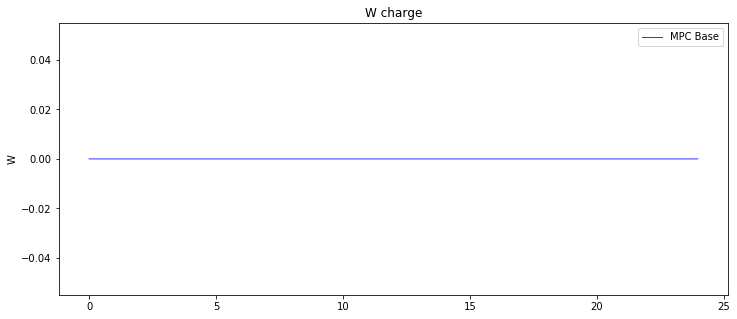

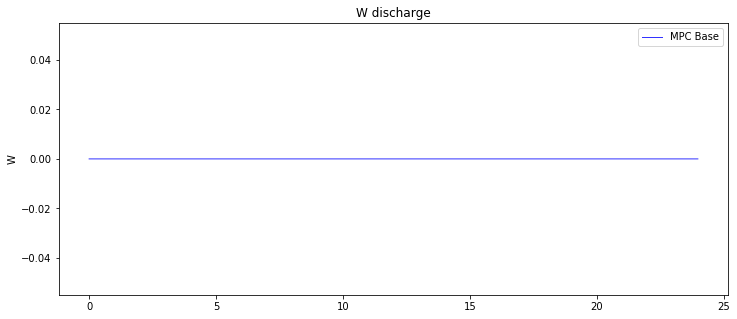

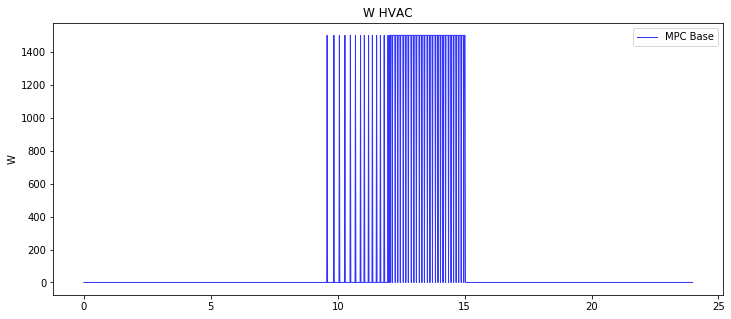

In [56]:
%%time
# USUAL MPC - decreased occup at 0.95 -> cost decreased at 17%, cons at 15.7%


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)*0.95
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
# T_room_MPC = T_room
# n_CO2_MPC = n_CO2
# P_f_MPC = P_f_prev
# P_c_MPC = P_c_prev
# T_wall_MPC = T_wall
# W_HVAC_MPC = W_HVAC

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1524.2 LossCO2 =  0.0
Total summary P_c needed =  567.6  W * tau summary, Total summary P_f needed 2258.3  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1512.7 LossCO2 =  0.0
Total summary P_c needed =  1065.8  W * tau summary, Total summary P_f needed 2747.1  W * tau summary
Computed COMP:  500.0 Computed FAN:  520.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1506.3 LossCO2 =  0.0
Total summary P_c needed =  1065.0  W * tau summary, Total summary P_f needed 2898.2  W * tau summary
Computed COMP:  500.0 Computed FAN:  680.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1500.8 LossCO2 =  0.0
Total summary P_c needed =  1064.4  W * tau summary, Total summary P_f needed 3011.8  W * tau summary
Computed COMP:  500.0 Computed FAN:  800.0
iteration 

iteration =  34 : with cost =  0.9  rub,  energy consumed =  0.2 kW*h,  LossT =  1323.3 LossCO2 =  0.0
Total summary P_c needed =  8543.1  W * tau summary, Total summary P_f needed 5596.7  W * tau summary
Computed COMP:  8000.0 Computed FAN:  3520.0
iteration =  35 : with cost =  0.9  rub,  energy consumed =  0.2 kW*h,  LossT =  1316.1 LossCO2 =  0.0
Total summary P_c needed =  9042.2  W * tau summary, Total summary P_f needed 5672.7  W * tau summary
Computed COMP:  8500.0 Computed FAN:  3600.0
iteration =  36 : with cost =  0.9  rub,  energy consumed =  0.2 kW*h,  LossT =  1312.4 LossCO2 =  0.0
Total summary P_c needed =  9041.8  W * tau summary, Total summary P_f needed 5748.6  W * tau summary
Computed COMP:  8500.0 Computed FAN:  3680.0
iteration =  37 : with cost =  1.0  rub,  energy consumed =  0.2 kW*h,  LossT =  1305.3 LossCO2 =  0.0
Total summary P_c needed =  9540.9  W * tau summary, Total summary P_f needed 5824.6  W * tau summary
Computed COMP:  9000.0 Computed FAN:  3760.0


iteration =  67 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1140.8 LossCO2 =  0.0
Total summary P_c needed =  17021.0  W * tau summary, Total summary P_f needed 8133.2  W * tau summary
Computed COMP:  16500.0 Computed FAN:  6200.0
iteration =  68 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1137.1 LossCO2 =  0.0
Total summary P_c needed =  17020.6  W * tau summary, Total summary P_f needed 8208.7  W * tau summary
Computed COMP:  16500.0 Computed FAN:  6280.0
iteration =  69 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1130.0 LossCO2 =  0.0
Total summary P_c needed =  17519.7  W * tau summary, Total summary P_f needed 8284.1  W * tau summary
Computed COMP:  17000.0 Computed FAN:  6360.0
iteration =  70 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1126.2 LossCO2 =  0.0
Total summary P_c needed =  17519.3  W * tau summary, Total summary P_f needed 8359.6  W * tau summary
Computed COMP:  17000.0 Computed FAN: 

iteration =  100 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  955.1 LossCO2 =  0.0
Total summary P_c needed =  29499.1  W * tau summary, Total summary P_f needed 9888.6  W * tau summary
Computed COMP:  29000.0 Computed FAN:  8080.0
iteration =  101 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  949.0 LossCO2 =  0.0
Total summary P_c needed =  29998.4  W * tau summary, Total summary P_f needed 9925.0  W * tau summary
Computed COMP:  29500.0 Computed FAN:  8120.0
iteration =  102 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  943.0 LossCO2 =  0.0
Total summary P_c needed =  30497.7  W * tau summary, Total summary P_f needed 9961.4  W * tau summary
Computed COMP:  30000.0 Computed FAN:  8160.0
iteration =  103 : with cost =  3.1  rub,  energy consumed =  0.6 kW*h,  LossT =  936.9 LossCO2 =  0.0
Total summary P_c needed =  30997.0  W * tau summary, Total summary P_f needed 9997.8  W * tau summary
Computed COMP:  30500.0 Computed FAN: 

iteration =  133 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  758.9 LossCO2 =  0.0
Total summary P_c needed =  45976.2  W * tau summary, Total summary P_f needed 11040.1  W * tau summary
Computed COMP:  45500.0 Computed FAN:  9360.0
iteration =  134 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  753.1 LossCO2 =  0.0
Total summary P_c needed =  46475.5  W * tau summary, Total summary P_f needed 11075.6  W * tau summary
Computed COMP:  46000.0 Computed FAN:  9400.0
iteration =  135 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  747.2 LossCO2 =  0.0
Total summary P_c needed =  46974.8  W * tau summary, Total summary P_f needed 11111.1  W * tau summary
Computed COMP:  46500.0 Computed FAN:  9440.0
iteration =  136 : with cost =  4.5  rub,  energy consumed =  0.9 kW*h,  LossT =  741.2 LossCO2 =  0.0
Total summary P_c needed =  47474.1  W * tau summary, Total summary P_f needed 11146.6  W * tau summary
Computed COMP:  47000.0 Computed F

iteration =  166 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  560.3 LossCO2 =  0.0
Total summary P_c needed =  62453.1  W * tau summary, Total summary P_f needed 12197.4  W * tau summary
Computed COMP:  62000.0 Computed FAN:  10680.0
iteration =  167 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  554.3 LossCO2 =  0.0
Total summary P_c needed =  62952.4  W * tau summary, Total summary P_f needed 12231.9  W * tau summary
Computed COMP:  62500.0 Computed FAN:  10720.0
iteration =  168 : with cost =  5.9  rub,  energy consumed =  1.2 kW*h,  LossT =  548.2 LossCO2 =  0.0
Total summary P_c needed =  63451.7  W * tau summary, Total summary P_f needed 12266.4  W * tau summary
Computed COMP:  63000.0 Computed FAN:  10760.0
iteration =  169 : with cost =  5.9  rub,  energy consumed =  1.2 kW*h,  LossT =  542.1 LossCO2 =  0.0
Total summary P_c needed =  63951.0  W * tau summary, Total summary P_f needed 12300.9  W * tau summary
Computed COMP:  63500.0 Compute

iteration =  199 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  366.4 LossCO2 =  0.0
Total summary P_c needed =  78930.3  W * tau summary, Total summary P_f needed 13284.9  W * tau summary
Computed COMP:  78500.0 Computed FAN:  11960.0
iteration =  200 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  360.4 LossCO2 =  0.0
Total summary P_c needed =  79429.6  W * tau summary, Total summary P_f needed 13318.2  W * tau summary
Computed COMP:  79000.0 Computed FAN:  12000.0
iteration =  201 : with cost =  7.3  rub,  energy consumed =  1.5 kW*h,  LossT =  354.3 LossCO2 =  0.0
Total summary P_c needed =  79928.9  W * tau summary, Total summary P_f needed 13351.5  W * tau summary
Computed COMP:  79500.0 Computed FAN:  12040.0
iteration =  202 : with cost =  7.3  rub,  energy consumed =  1.5 kW*h,  LossT =  348.3 LossCO2 =  0.0
Total summary P_c needed =  80428.2  W * tau summary, Total summary P_f needed 13384.7  W * tau summary
Computed COMP:  80000.0 Compute

iteration =  232 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  168.3 LossCO2 =  0.0
Total summary P_c needed =  95407.1  W * tau summary, Total summary P_f needed 14354.9  W * tau summary
Computed COMP:  95000.0 Computed FAN:  13280.0
iteration =  233 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  162.3 LossCO2 =  0.0
Total summary P_c needed =  95906.4  W * tau summary, Total summary P_f needed 14386.2  W * tau summary
Computed COMP:  95500.0 Computed FAN:  13320.0
iteration =  234 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  156.4 LossCO2 =  0.0
Total summary P_c needed =  96405.7  W * tau summary, Total summary P_f needed 14417.5  W * tau summary
Computed COMP:  96000.0 Computed FAN:  13360.0
iteration =  235 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  150.4 LossCO2 =  0.0
Total summary P_c needed =  96905.0  W * tau summary, Total summary P_f needed 14448.6  W * tau summary
Computed COMP:  96500.0 Compute

iteration =  265 : with cost =  10.0  rub,  energy consumed =  2.1 kW*h,  LossT =  0.0 LossCO2 =  0.0
Total summary P_c needed =  111384.7  W * tau summary, Total summary P_f needed 15308.4  W * tau summary
Computed COMP:  111000.0 Computed FAN:  14560.0
 cost =  10.0  rub 
 energy consumed =  2.1 kW*h 
 number of iterations =  266 
  Comfort zone out by Temp =  0.0 C * min 
 Comfort zone out by CO2 =  0.0 ppm * min
Wall time: 1min 22s


<function matplotlib.pyplot.show(*args, **kw)>

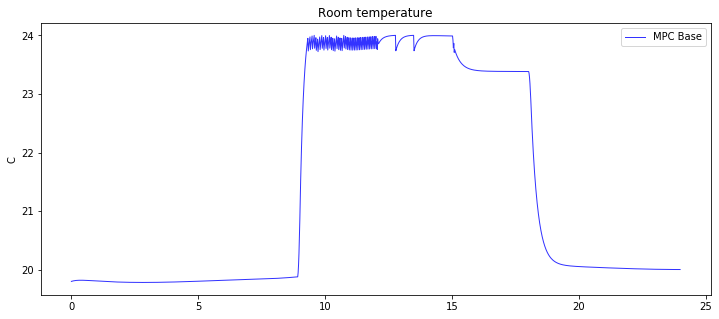

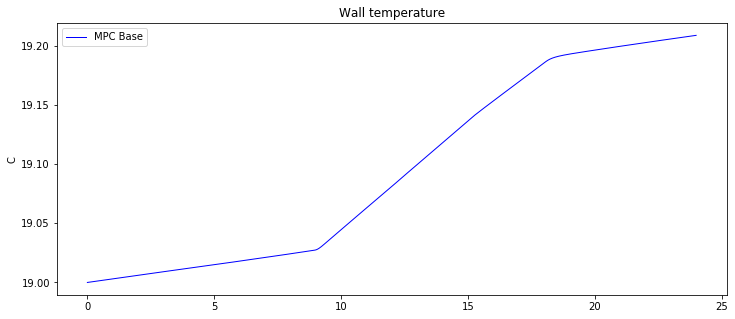

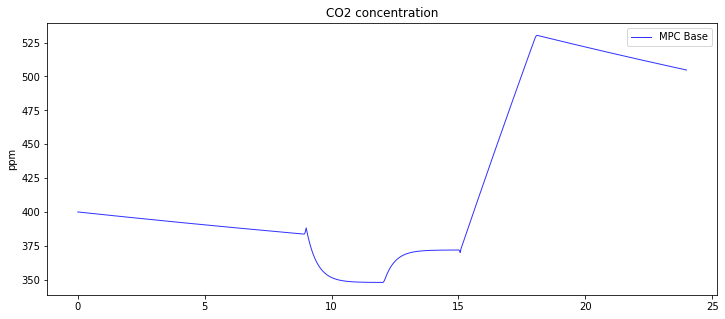

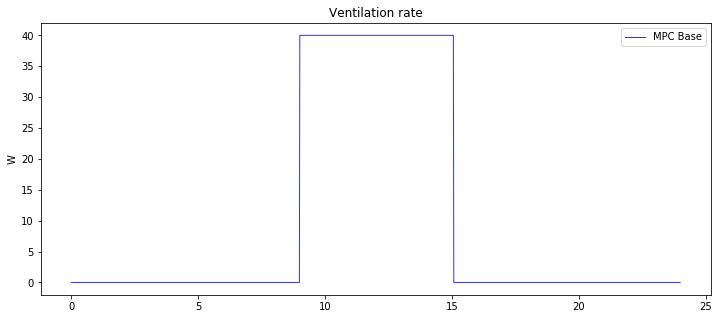

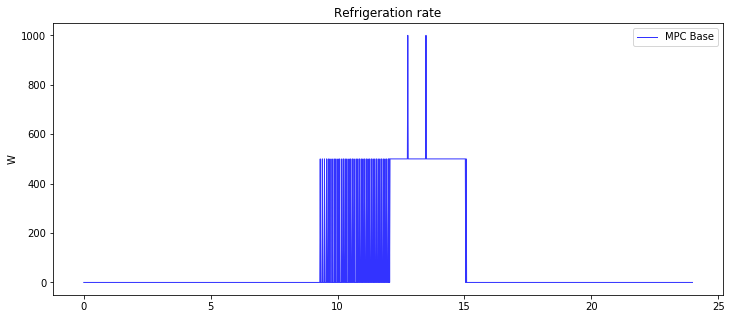

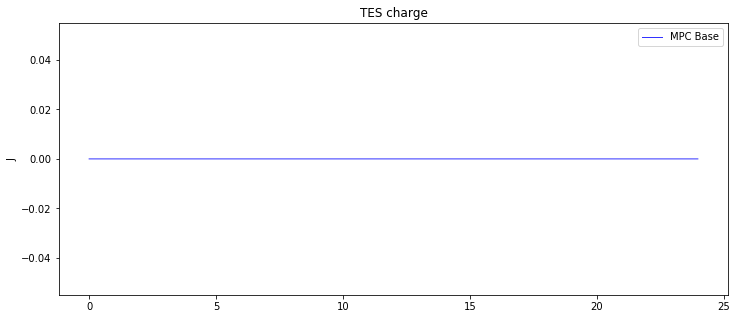

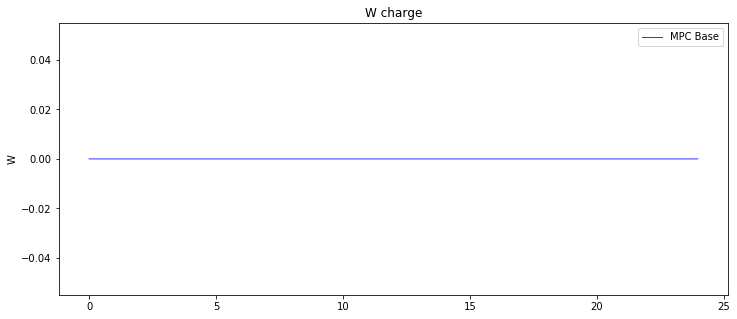

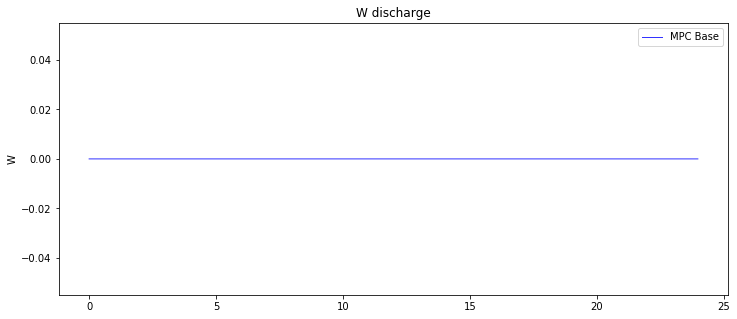

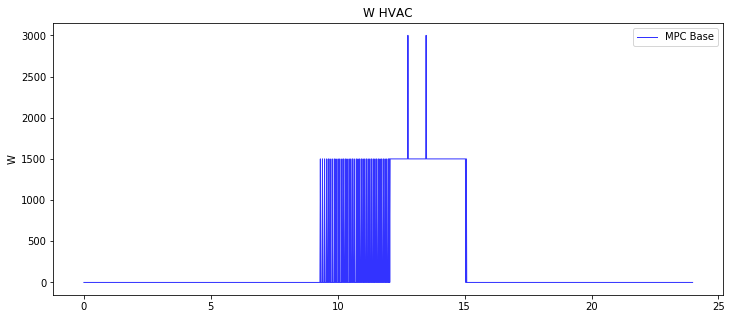

In [55]:
%%time
# USUAL MPC - increased occup at 1.05 -> cost increased at 7%, cons at 9.5%


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)*1.05
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
# T_room_MPC = T_room
# n_CO2_MPC = n_CO2
# P_f_MPC = P_f_prev
# P_c_MPC = P_c_prev
# T_wall_MPC = T_wall
# W_HVAC_MPC = W_HVAC

In [ ]:
# Now let's go to the Base case and TES case comparison

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1378.1 LossCO2 =  0.0
Total summary P_c needed =  547.5  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1366.8 LossCO2 =  0.0
Total summary P_c needed =  1045.7  W * tau summary, Total summary P_f needed 2736.4  W * tau summary
Computed COMP:  500.0 Computed FAN:  560.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1359.4 LossCO2 =  0.0
Total summary P_c needed =  1044.7  W * tau summary, Total summary P_f needed 2925.2  W * tau summary
Computed COMP:  500.0 Computed FAN:  760.0
iteration =  4 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1352.4 LossCO2 =  0.0
Total summary P_c needed =  1043.9  W * tau summary, Total summary P_f needed 3076.6  W * tau summary
Computed COMP:  500.0 Computed FAN:  920.0
iteration 

iteration =  34 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1187.4 LossCO2 =  0.0
Total summary P_c needed =  6523.9  W * tau summary, Total summary P_f needed 5774.8  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3760.0
iteration =  35 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1182.1 LossCO2 =  0.0
Total summary P_c needed =  6523.3  W * tau summary, Total summary P_f needed 5888.7  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3880.0
iteration =  36 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1178.3 LossCO2 =  0.0
Total summary P_c needed =  6522.9  W * tau summary, Total summary P_f needed 5964.6  W * tau summary
Computed COMP:  6000.0 Computed FAN:  3960.0
iteration =  37 : with cost =  0.8  rub,  energy consumed =  0.2 kW*h,  LossT =  1171.4 LossCO2 =  0.0
Total summary P_c needed =  7022.0  W * tau summary, Total summary P_f needed 6040.5  W * tau summary
Computed COMP:  6500.0 Computed FAN:  4040.0


iteration =  67 : with cost =  1.5  rub,  energy consumed =  0.3 kW*h,  LossT =  1003.7 LossCO2 =  0.0
Total summary P_c needed =  13001.6  W * tau summary, Total summary P_f needed 8724.6  W * tau summary
Computed COMP:  12500.0 Computed FAN:  6880.0
iteration =  68 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  996.9 LossCO2 =  0.0
Total summary P_c needed =  13500.7  W * tau summary, Total summary P_f needed 8800.0  W * tau summary
Computed COMP:  13000.0 Computed FAN:  6960.0
iteration =  69 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  991.4 LossCO2 =  0.0
Total summary P_c needed =  13500.1  W * tau summary, Total summary P_f needed 8913.2  W * tau summary
Computed COMP:  13000.0 Computed FAN:  7080.0
iteration =  70 : with cost =  1.6  rub,  energy consumed =  0.3 kW*h,  LossT =  984.6 LossCO2 =  0.0
Total summary P_c needed =  13999.2  W * tau summary, Total summary P_f needed 8988.7  W * tau summary
Computed COMP:  13500.0 Computed FAN:  71

iteration =  100 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  815.7 LossCO2 =  0.0
Total summary P_c needed =  27979.0  W * tau summary, Total summary P_f needed 10201.7  W * tau summary
Computed COMP:  27500.0 Computed FAN:  8480.0
iteration =  101 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  810.1 LossCO2 =  0.0
Total summary P_c needed =  28478.3  W * tau summary, Total summary P_f needed 10237.8  W * tau summary
Computed COMP:  28000.0 Computed FAN:  8520.0
iteration =  102 : with cost =  2.9  rub,  energy consumed =  0.6 kW*h,  LossT =  804.5 LossCO2 =  0.0
Total summary P_c needed =  28977.6  W * tau summary, Total summary P_f needed 10273.9  W * tau summary
Computed COMP:  28500.0 Computed FAN:  8560.0
iteration =  103 : with cost =  3.0  rub,  energy consumed =  0.6 kW*h,  LossT =  798.8 LossCO2 =  0.0
Total summary P_c needed =  29476.9  W * tau summary, Total summary P_f needed 10310.0  W * tau summary
Computed COMP:  29000.0 Computed F

iteration =  133 : with cost =  4.3  rub,  energy consumed =  0.9 kW*h,  LossT =  630.6 LossCO2 =  0.0
Total summary P_c needed =  44456.4  W * tau summary, Total summary P_f needed 11379.5  W * tau summary
Computed COMP:  44000.0 Computed FAN:  9800.0
iteration =  134 : with cost =  4.3  rub,  energy consumed =  0.9 kW*h,  LossT =  625.0 LossCO2 =  0.0
Total summary P_c needed =  44955.8  W * tau summary, Total summary P_f needed 11414.7  W * tau summary
Computed COMP:  44500.0 Computed FAN:  9840.0
iteration =  135 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  619.4 LossCO2 =  0.0
Total summary P_c needed =  45455.1  W * tau summary, Total summary P_f needed 11449.9  W * tau summary
Computed COMP:  45000.0 Computed FAN:  9880.0
iteration =  136 : with cost =  4.4  rub,  energy consumed =  0.9 kW*h,  LossT =  613.8 LossCO2 =  0.0
Total summary P_c needed =  45954.4  W * tau summary, Total summary P_f needed 11485.0  W * tau summary
Computed COMP:  45500.0 Computed F

iteration =  166 : with cost =  5.7  rub,  energy consumed =  1.2 kW*h,  LossT =  446.0 LossCO2 =  0.0
Total summary P_c needed =  60933.9  W * tau summary, Total summary P_f needed 12525.7  W * tau summary
Computed COMP:  60500.0 Computed FAN:  11120.0
iteration =  167 : with cost =  5.7  rub,  energy consumed =  1.2 kW*h,  LossT =  440.5 LossCO2 =  0.0
Total summary P_c needed =  61433.3  W * tau summary, Total summary P_f needed 12559.9  W * tau summary
Computed COMP:  61000.0 Computed FAN:  11160.0
iteration =  168 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  434.9 LossCO2 =  0.0
Total summary P_c needed =  61932.6  W * tau summary, Total summary P_f needed 12594.0  W * tau summary
Computed COMP:  61500.0 Computed FAN:  11200.0
iteration =  169 : with cost =  5.8  rub,  energy consumed =  1.2 kW*h,  LossT =  429.3 LossCO2 =  0.0
Total summary P_c needed =  62431.9  W * tau summary, Total summary P_f needed 12628.1  W * tau summary
Computed COMP:  62000.0 Compute

iteration =  199 : with cost =  7.1  rub,  energy consumed =  1.5 kW*h,  LossT =  262.3 LossCO2 =  0.0
Total summary P_c needed =  77411.4  W * tau summary, Total summary P_f needed 13631.5  W * tau summary
Computed COMP:  77000.0 Computed FAN:  12440.0
iteration =  200 : with cost =  7.1  rub,  energy consumed =  1.5 kW*h,  LossT =  256.8 LossCO2 =  0.0
Total summary P_c needed =  77910.8  W * tau summary, Total summary P_f needed 13664.2  W * tau summary
Computed COMP:  77500.0 Computed FAN:  12480.0
iteration =  201 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  251.2 LossCO2 =  0.0
Total summary P_c needed =  78410.1  W * tau summary, Total summary P_f needed 13696.8  W * tau summary
Computed COMP:  78000.0 Computed FAN:  12520.0
iteration =  202 : with cost =  7.2  rub,  energy consumed =  1.5 kW*h,  LossT =  245.7 LossCO2 =  0.0
Total summary P_c needed =  78909.4  W * tau summary, Total summary P_f needed 13729.4  W * tau summary
Computed COMP:  78500.0 Compute

iteration =  233 : with cost =  8.5  rub,  energy consumed =  1.8 kW*h,  LossT =  78.1 LossCO2 =  0.0
Total summary P_c needed =  93888.6  W * tau summary, Total summary P_f needed 14705.5  W * tau summary
Computed COMP:  93500.0 Computed FAN:  13800.0
iteration =  234 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  72.8 LossCO2 =  0.0
Total summary P_c needed =  94387.9  W * tau summary, Total summary P_f needed 14735.6  W * tau summary
Computed COMP:  94000.0 Computed FAN:  13840.0
iteration =  235 : with cost =  8.6  rub,  energy consumed =  1.8 kW*h,  LossT =  67.4 LossCO2 =  0.0
Total summary P_c needed =  94887.3  W * tau summary, Total summary P_f needed 14765.6  W * tau summary
Computed COMP:  94500.0 Computed FAN:  13880.0
iteration =  236 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  62.2 LossCO2 =  0.0
Total summary P_c needed =  95386.6  W * tau summary, Total summary P_f needed 14795.6  W * tau summary
Computed COMP:  95000.0 Computed FA

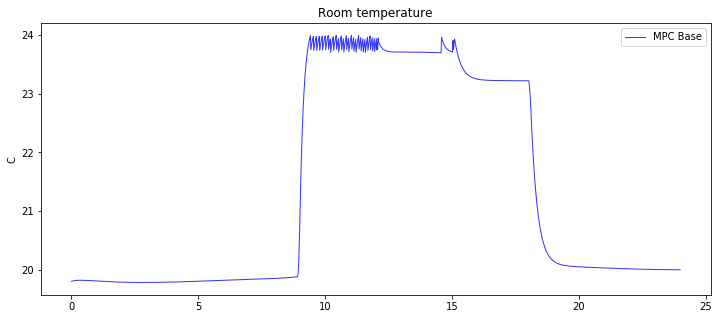

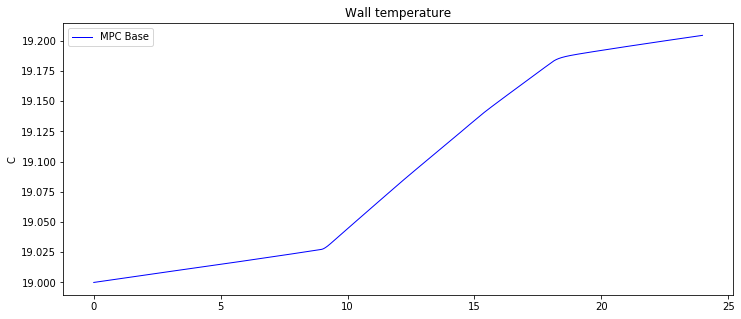

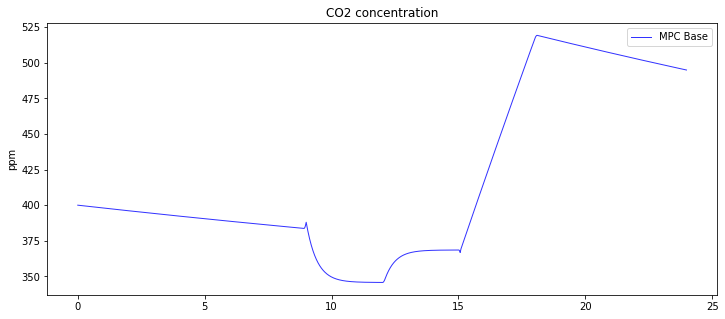

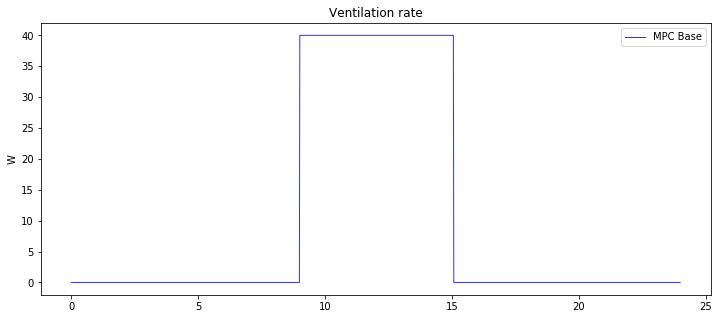

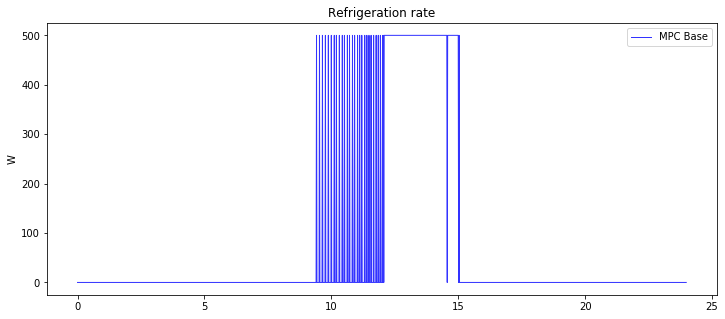

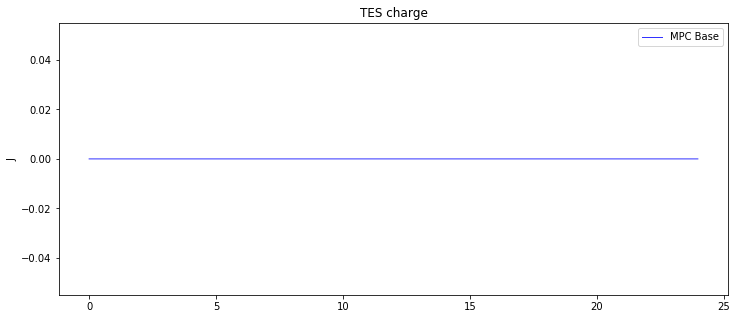

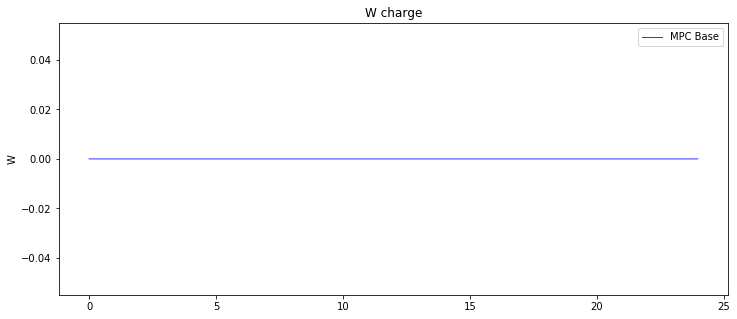

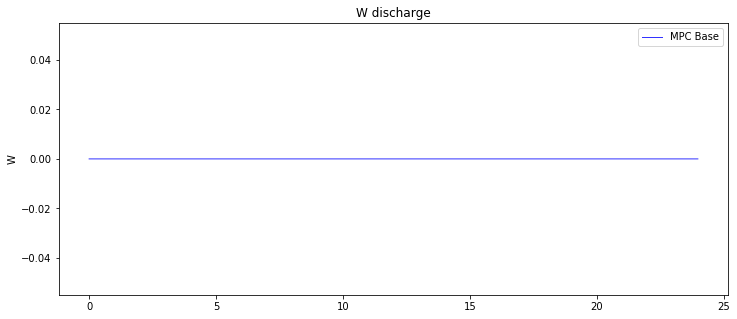

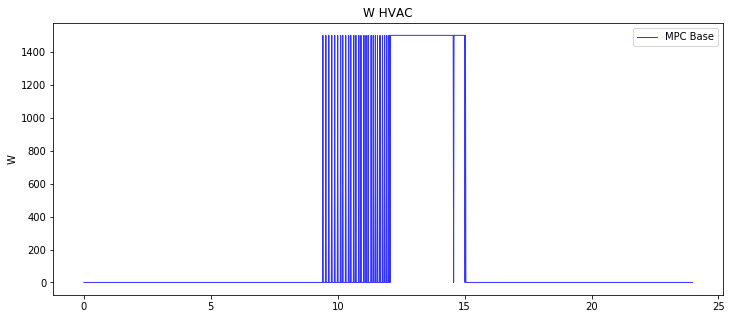

In [19]:
%%time
# USUAL MPC


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 400 # number of iterations

error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
        if T_room[i] < 23.7:
            P_c[i-1] -= 500
            P_c[i-1] = max(P_c[i-1],0)
            continue


    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost

    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

RUN_RESULTS.append(['USUAL MPC', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Base')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Base')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
T_room_MPC = T_room
n_CO2_MPC = n_CO2
P_f_MPC = P_f_prev
P_c_MPC = P_c_prev
T_wall_MPC = T_wall
W_HVAC_MPC = W_HVAC

In [ ]:
# Let's check pre-cooling using walls inertia (bad result)
# Since then we have not taken it into account

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1378.1 LossCO2 =  0.0
Total summary P_c needed =  547.5  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1366.8 LossCO2 =  0.0
Total summary P_c needed =  1045.7  W * tau summary, Total summary P_f needed 2736.4  W * tau summary
Computed COMP:  500.0 Computed FAN:  560.0
iteration =  3 : with cost =  0.1  rub,  energy consumed =  0.0 kW*h,  LossT =  1357.4 LossCO2 =  0.0
Total summary P_c needed =  1544.3  W * tau summary, Total summary P_f needed 2925.2  W * tau summary
Computed COMP:  1000.0 Computed FAN:  760.0
iteration =  4 : with cost =  0.2  rub,  energy consumed =  0.0 kW*h,  LossT =  1348.8 LossCO2 =  0.0
Total summary P_c needed =  2043.1  W * tau summary, Total summary P_f needed 3076.6  W * tau summary
Computed COMP:  1500.0 Computed FAN:  920.0
iteratio

iteration =  34 : with cost =  1.7  rub,  energy consumed =  0.4 kW*h,  LossT =  1083.8 LossCO2 =  0.0
Total summary P_c needed =  17007.4  W * tau summary, Total summary P_f needed 7403.7  W * tau summary
Computed COMP:  16500.0 Computed FAN:  5480.0
iteration =  35 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1074.6 LossCO2 =  0.0
Total summary P_c needed =  17506.1  W * tau summary, Total summary P_f needed 7554.9  W * tau summary
Computed COMP:  17000.0 Computed FAN:  5640.0
iteration =  36 : with cost =  1.8  rub,  energy consumed =  0.4 kW*h,  LossT =  1067.0 LossCO2 =  0.0
Total summary P_c needed =  18005.1  W * tau summary, Total summary P_f needed 7668.2  W * tau summary
Computed COMP:  17500.0 Computed FAN:  5760.0
iteration =  37 : with cost =  1.9  rub,  energy consumed =  0.4 kW*h,  LossT =  1057.8 LossCO2 =  0.0
Total summary P_c needed =  18503.9  W * tau summary, Total summary P_f needed 7819.2  W * tau summary
Computed COMP:  18000.0 Computed FAN: 

iteration =  67 : with cost =  3.3  rub,  energy consumed =  0.7 kW*h,  LossT =  859.8 LossCO2 =  0.0
Total summary P_c needed =  33478.7  W * tau summary, Total summary P_f needed 9911.6  W * tau summary
Computed COMP:  33000.0 Computed FAN:  8160.0
iteration =  68 : with cost =  3.3  rub,  energy consumed =  0.7 kW*h,  LossT =  854.2 LossCO2 =  0.0
Total summary P_c needed =  33978.0  W * tau summary, Total summary P_f needed 9947.9  W * tau summary
Computed COMP:  33500.0 Computed FAN:  8200.0
iteration =  69 : with cost =  3.3  rub,  energy consumed =  0.7 kW*h,  LossT =  848.6 LossCO2 =  0.0
Total summary P_c needed =  34477.3  W * tau summary, Total summary P_f needed 9984.3  W * tau summary
Computed COMP:  34000.0 Computed FAN:  8240.0
iteration =  70 : with cost =  3.4  rub,  energy consumed =  0.7 kW*h,  LossT =  843.0 LossCO2 =  0.0
Total summary P_c needed =  34976.6  W * tau summary, Total summary P_f needed 10020.6  W * tau summary
Computed COMP:  34500.0 Computed FAN:  82

iteration =  100 : with cost =  4.7  rub,  energy consumed =  1.0 kW*h,  LossT =  675.0 LossCO2 =  0.0
Total summary P_c needed =  49956.2  W * tau summary, Total summary P_f needed 11096.7  W * tau summary
Computed COMP:  49500.0 Computed FAN:  9480.0
iteration =  101 : with cost =  4.7  rub,  energy consumed =  1.0 kW*h,  LossT =  669.4 LossCO2 =  0.0
Total summary P_c needed =  50455.5  W * tau summary, Total summary P_f needed 11132.1  W * tau summary
Computed COMP:  50000.0 Computed FAN:  9520.0
iteration =  102 : with cost =  4.8  rub,  energy consumed =  1.0 kW*h,  LossT =  663.8 LossCO2 =  0.0
Total summary P_c needed =  50954.8  W * tau summary, Total summary P_f needed 11167.5  W * tau summary
Computed COMP:  50500.0 Computed FAN:  9560.0
iteration =  103 : with cost =  4.8  rub,  energy consumed =  1.0 kW*h,  LossT =  658.2 LossCO2 =  0.0
Total summary P_c needed =  51454.1  W * tau summary, Total summary P_f needed 11202.9  W * tau summary
Computed COMP:  51000.0 Computed F

iteration =  133 : with cost =  6.1  rub,  energy consumed =  1.3 kW*h,  LossT =  490.4 LossCO2 =  0.0
Total summary P_c needed =  66433.7  W * tau summary, Total summary P_f needed 12251.1  W * tau summary
Computed COMP:  66000.0 Computed FAN:  10800.0
iteration =  134 : with cost =  6.1  rub,  energy consumed =  1.3 kW*h,  LossT =  484.8 LossCO2 =  0.0
Total summary P_c needed =  66933.0  W * tau summary, Total summary P_f needed 12285.5  W * tau summary
Computed COMP:  66500.0 Computed FAN:  10840.0
iteration =  135 : with cost =  6.2  rub,  energy consumed =  1.3 kW*h,  LossT =  479.2 LossCO2 =  0.0
Total summary P_c needed =  67432.3  W * tau summary, Total summary P_f needed 12319.9  W * tau summary
Computed COMP:  67000.0 Computed FAN:  10880.0
iteration =  136 : with cost =  6.2  rub,  energy consumed =  1.3 kW*h,  LossT =  473.6 LossCO2 =  0.0
Total summary P_c needed =  67931.6  W * tau summary, Total summary P_f needed 12354.3  W * tau summary
Computed COMP:  67500.0 Compute

iteration =  166 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  223.9 LossCO2 =  0.0
Total summary P_c needed =  97396.8  W * tau summary, Total summary P_f needed 13859.1  W * tau summary
Computed COMP:  97000.0 Computed FAN:  12720.0
iteration =  167 : with cost =  8.7  rub,  energy consumed =  1.8 kW*h,  LossT =  218.3 LossCO2 =  0.0
Total summary P_c needed =  97896.1  W * tau summary, Total summary P_f needed 13891.4  W * tau summary
Computed COMP:  97500.0 Computed FAN:  12760.0
iteration =  168 : with cost =  8.8  rub,  energy consumed =  1.8 kW*h,  LossT =  212.7 LossCO2 =  0.0
Total summary P_c needed =  98395.4  W * tau summary, Total summary P_f needed 13923.6  W * tau summary
Computed COMP:  98000.0 Computed FAN:  12800.0
iteration =  169 : with cost =  8.8  rub,  energy consumed =  1.9 kW*h,  LossT =  207.1 LossCO2 =  0.0
Total summary P_c needed =  98894.7  W * tau summary, Total summary P_f needed 13955.8  W * tau summary
Computed COMP:  98500.0 Compute

iteration =  199 : with cost =  10.1  rub,  energy consumed =  2.1 kW*h,  LossT =  45.8 LossCO2 =  0.0
Total summary P_c needed =  113874.3  W * tau summary, Total summary P_f needed 14884.7  W * tau summary
Computed COMP:  113500.0 Computed FAN:  14040.0
iteration =  200 : with cost =  10.2  rub,  energy consumed =  2.1 kW*h,  LossT =  40.9 LossCO2 =  0.0
Total summary P_c needed =  114373.6  W * tau summary, Total summary P_f needed 14914.2  W * tau summary
Computed COMP:  114000.0 Computed FAN:  14080.0
iteration =  201 : with cost =  10.2  rub,  energy consumed =  2.1 kW*h,  LossT =  36.0 LossCO2 =  0.0
Total summary P_c needed =  114872.9  W * tau summary, Total summary P_f needed 14943.5  W * tau summary
Computed COMP:  114500.0 Computed FAN:  14120.0
iteration =  202 : with cost =  10.3  rub,  energy consumed =  2.2 kW*h,  LossT =  31.1 LossCO2 =  0.0
Total summary P_c needed =  115372.2  W * tau summary, Total summary P_f needed 14972.8  W * tau summary
Computed COMP:  115000.0

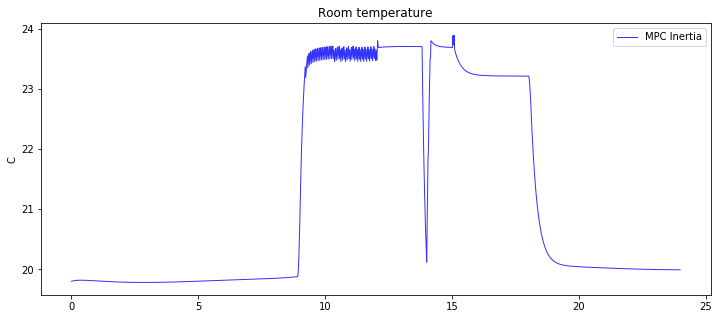

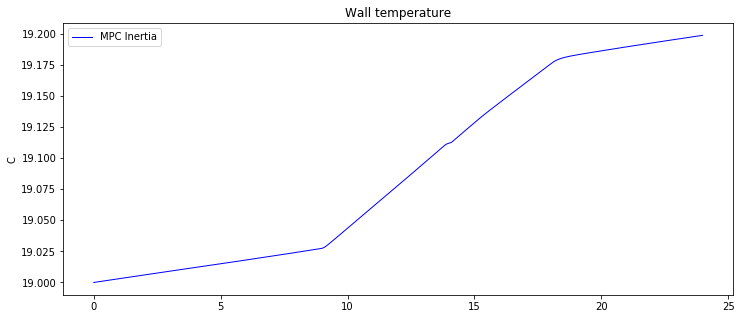

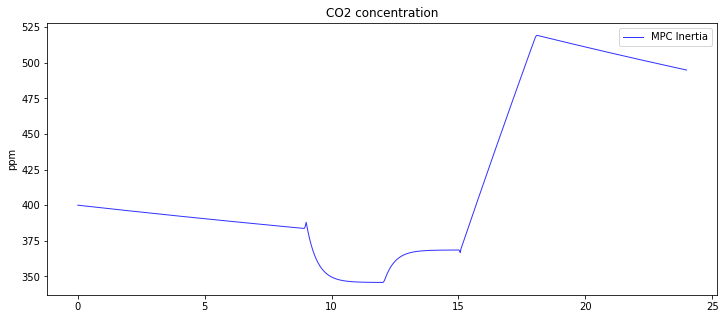

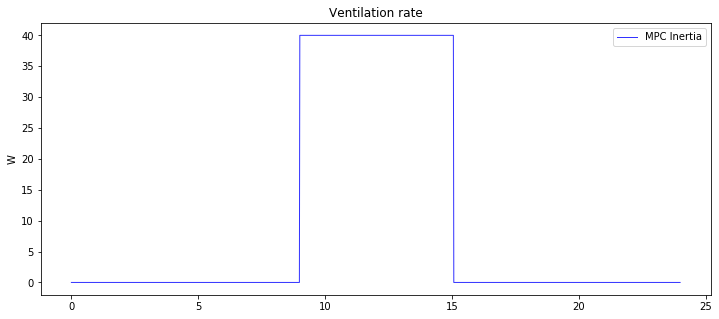

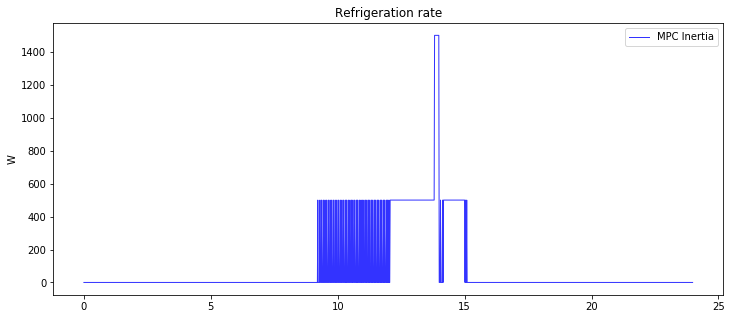

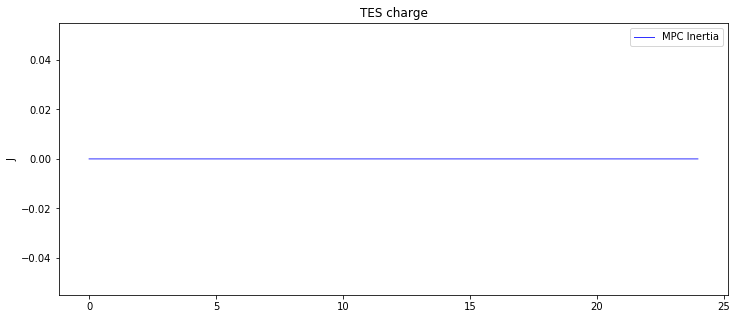

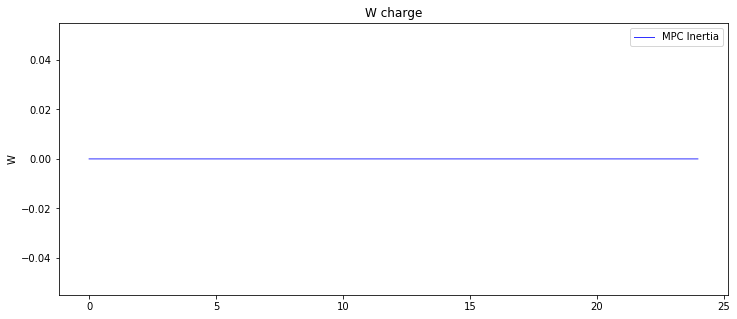

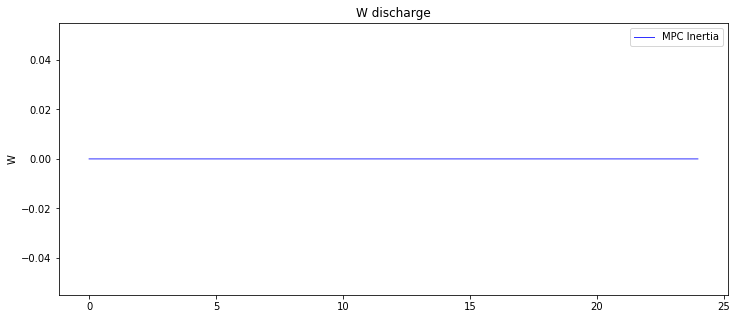

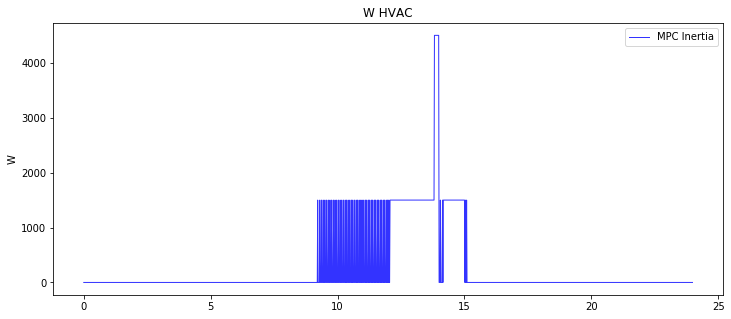

In [54]:
%%time
# MPC THERMAL INERTIA


tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 1500 # number of iterations
error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
#     W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
#     W_ch.append(chargetime(time_t[0]) * W_HVAC[0])
    
    W_dis.append(0)
    W_ch.append(0)

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])

        W_dis.append(0)
        W_ch.append(0)
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
    
    for i in range(len(T_room)):
        if 9 < time_t[i] < 18:
            if N_oc[i] > 15:
                P_f[i-1] = 40
        if T_room[i] > 24:
            P_c[i-1] += 500
            P_c[i-1] = min(P_c[i-1],1500)
            break
#         if T_room[i] < 23.7:
#             P_c[i-1] -= 500
#             P_c[i-1] = max(P_c[i-1],0)
#             continue
        if 13.8 < time_t[i-1] < 14 and T_room[i-1] > T_wall[i-1]:
            P_c[i-1] = 1500                
    
    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost
    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )


RUN_RESULTS.append(['MPC WITH THERMAL INERTIA', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='MPC Inertia')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.title('TES charge')
plt.ylabel('J')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
T_room_MPC_inertia = T_room
n_CO2_MPC_inertia = n_CO2
P_f_MPC_inertia = P_f_prev
P_c_MPC_inertia = P_c_prev
T_wall_MPC_inertia = T_wall
W_HVAC_MPC_inertia = W_HVAC
comp_to_work_MPC_inertia = comp_to_work

iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1378.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  1376.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2220.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  10.0
iteration =  3 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  1375.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2229.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  20.0
iteration =  4 : with cost =  7.9  rub,  energy consumed =  1.9 kW*h,  LossT =  1373.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2238.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  30.0
it

iteration =  34 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1332.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2508.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  330.0
iteration =  35 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1330.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2517.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  340.0
iteration =  36 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1329.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2526.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  350.0
iteration =  37 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1327.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2535.3  W * tau summary
Computed COMP:  112500.0 Computed 

iteration =  67 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1286.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2804.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  660.0
iteration =  68 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1284.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2813.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  670.0
iteration =  69 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1283.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2822.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  680.0
iteration =  70 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1282.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 2831.3  W * tau summary
Computed COMP:  112500.0 Computed 

iteration =  100 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1240.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3099.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  990.0
iteration =  101 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1239.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3108.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1000.0
iteration =  102 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1237.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3117.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1010.0
iteration =  103 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1236.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3126.1  W * tau summary
Computed COMP:  112500.0 Com

iteration =  133 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1194.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3393.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1320.0
iteration =  134 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1193.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3402.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1330.0
iteration =  135 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1192.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3410.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1340.0
iteration =  136 : with cost =  8.0  rub,  energy consumed =  1.9 kW*h,  LossT =  1190.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3419.7  W * tau summary
Computed COMP:  112500.0 Co

iteration =  166 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1149.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3685.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1650.0
iteration =  167 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1147.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3694.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1660.0
iteration =  168 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1146.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3703.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1670.0
iteration =  169 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1145.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3712.0  W * tau summary
Computed COMP:  112500.0 Co

iteration =  199 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1103.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3976.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1980.0
iteration =  200 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1102.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3985.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  1990.0
iteration =  201 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1100.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 3994.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2000.0
iteration =  202 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1099.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4003.1  W * tau summary
Computed COMP:  112500.0 Co

iteration =  232 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1057.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4266.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2310.0
iteration =  233 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1056.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4275.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2320.0
iteration =  234 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1055.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4284.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2330.0
iteration =  235 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1053.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4292.8  W * tau summary
Computed COMP:  112500.0 Co

iteration =  265 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1012.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4555.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2640.0
iteration =  266 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1011.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4563.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2650.0
iteration =  267 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1009.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4572.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2660.0
iteration =  268 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1008.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4581.2  W * tau summary
Computed COMP:  112500.0 Co

iteration =  298 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  966.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4842.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2970.0
iteration =  299 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  965.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4851.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2980.0
iteration =  300 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  964.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4859.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  2990.0
iteration =  301 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  962.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 4868.5  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  331 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  920.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5131.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3300.0
iteration =  332 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  919.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5140.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3310.0
iteration =  333 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  917.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5148.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3320.0
iteration =  334 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  916.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5157.7  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  364 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  874.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5421.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3630.0
iteration =  365 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  873.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5430.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3640.0
iteration =  366 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  871.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5439.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3650.0
iteration =  367 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  870.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5448.4  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  397 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  828.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5712.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3960.0
iteration =  398 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  826.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5721.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3970.0
iteration =  399 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  825.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5730.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  3980.0
iteration =  400 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  824.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 5739.5  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  430 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  782.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6004.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4290.0
iteration =  431 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  780.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6013.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4300.0
iteration =  432 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  779.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6021.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4310.0
iteration =  433 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  777.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6030.7  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  463 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  735.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6295.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4620.0
iteration =  464 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  734.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6304.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4630.0
iteration =  465 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  733.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6312.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4640.0
iteration =  466 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  731.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6321.6  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  496 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  689.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6585.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4950.0
iteration =  497 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  688.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6594.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4960.0
iteration =  498 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  686.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6603.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  4970.0
iteration =  499 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  685.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6612.0  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  529 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  643.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6874.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5280.0
iteration =  530 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  642.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6883.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5290.0
iteration =  531 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  640.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6892.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5300.0
iteration =  532 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  639.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 6901.0  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  562 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  597.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7162.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5610.0
iteration =  563 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  595.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7171.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5620.0
iteration =  564 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  594.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7180.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5630.0
iteration =  565 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  593.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7188.9  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  595 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  551.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7449.5  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5940.0
iteration =  596 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  549.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7458.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5950.0
iteration =  597 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  548.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7466.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  5960.0
iteration =  598 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  546.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7475.4  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  628 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  504.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7734.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6270.0
iteration =  629 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  503.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7742.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6280.0
iteration =  630 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  502.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7751.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6290.0
iteration =  631 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  500.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 7760.2  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  661 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  458.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8017.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6600.0
iteration =  662 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  457.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8025.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6610.0
iteration =  663 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  456.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8034.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6620.0
iteration =  664 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  454.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8042.7  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  694 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  412.7 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8297.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6930.0
iteration =  695 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  411.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8306.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6940.0
iteration =  696 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  410.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8314.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  6950.0
iteration =  697 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  408.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8323.1  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  727 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  366.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8576.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7260.0
iteration =  728 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  365.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8584.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7270.0
iteration =  729 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  364.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8592.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7280.0
iteration =  730 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  362.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8601.0  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  760 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  320.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8851.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7590.0
iteration =  761 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  319.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8859.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7600.0
iteration =  762 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  318.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8867.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7610.0
iteration =  763 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  316.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 8876.1  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  793 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  275.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9123.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7920.0
iteration =  794 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  273.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9131.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7930.0
iteration =  795 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  272.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9139.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  7940.0
iteration =  796 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  270.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9147.8  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  826 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  229.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9391.7  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8250.0
iteration =  827 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  227.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9400.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8260.0
iteration =  828 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  226.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9407.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8270.0
iteration =  829 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  225.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9415.9  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  859 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  183.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9656.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8580.0
iteration =  860 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  182.4 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9664.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8590.0
iteration =  861 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  181.0 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9672.0  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8600.0
iteration =  862 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  179.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9680.0  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  892 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  138.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9915.8  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8910.0
iteration =  893 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  137.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9923.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8920.0
iteration =  894 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  135.9 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9931.4  W * tau summary
Computed COMP:  112500.0 Computed FAN:  8930.0
iteration =  895 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  134.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 9939.3  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  925 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  94.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10169.9  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9240.0
iteration =  926 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  92.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10177.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9250.0
iteration =  927 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  91.5 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10185.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9260.0
iteration =  928 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  90.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10192.8  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  958 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  51.1 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10417.6  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9570.0
iteration =  959 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  49.8 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10425.1  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9580.0
iteration =  960 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  48.6 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10432.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9590.0
iteration =  961 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  47.3 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10439.7  W * tau summary
Computed COMP:  112500.0 Comput

iteration =  991 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  12.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10657.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9900.0
iteration =  992 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  11.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10664.2  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9910.0
iteration =  993 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  10.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10671.3  W * tau summary
Computed COMP:  112500.0 Computed FAN:  9920.0
iteration =  994 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  9.2 LossCO2 =  0.0
Total summary P_c needed =  102376.6  W * tau summary, Total summary P_f needed 10678.4  W * tau summary
Computed COMP:  112500.0 Compute

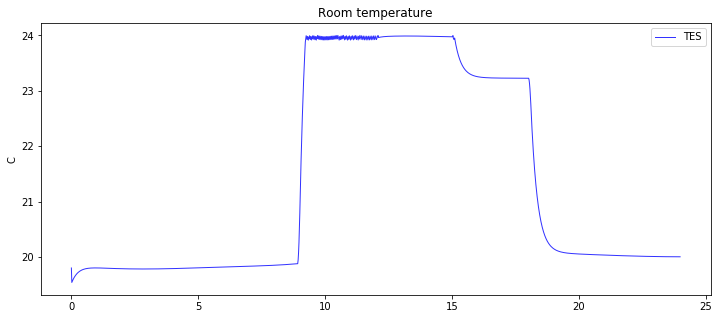

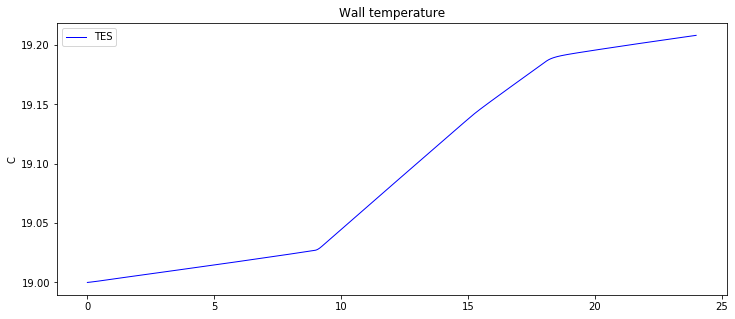

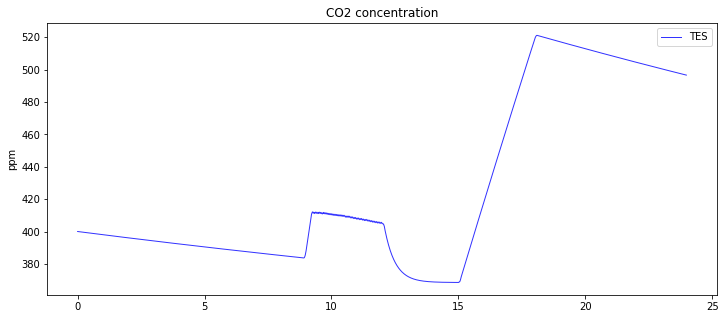

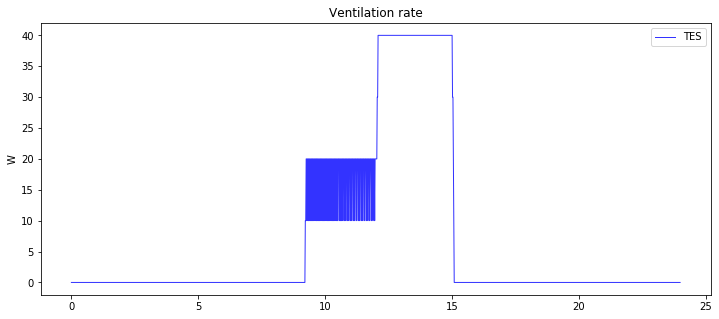

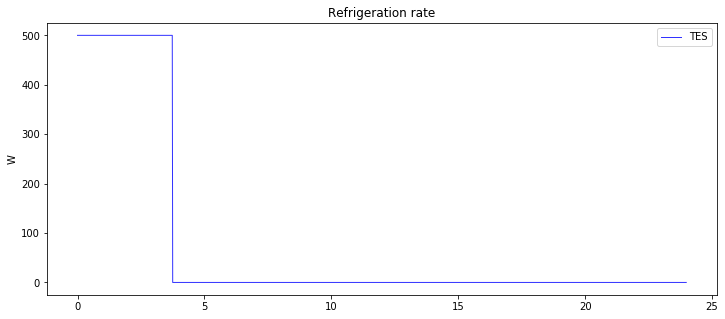

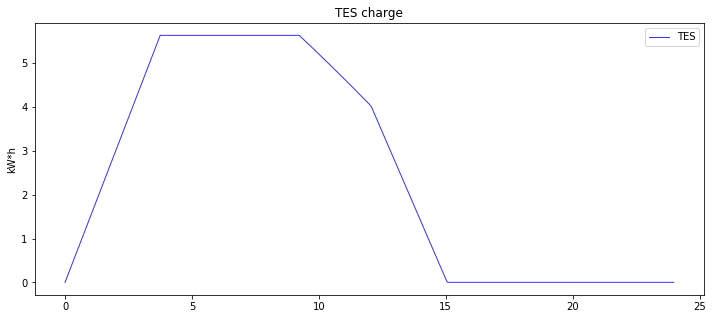

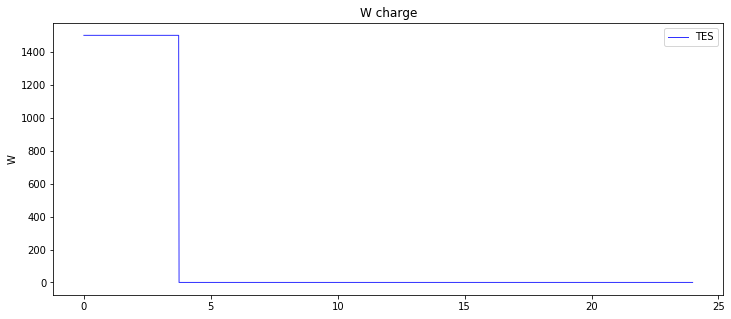

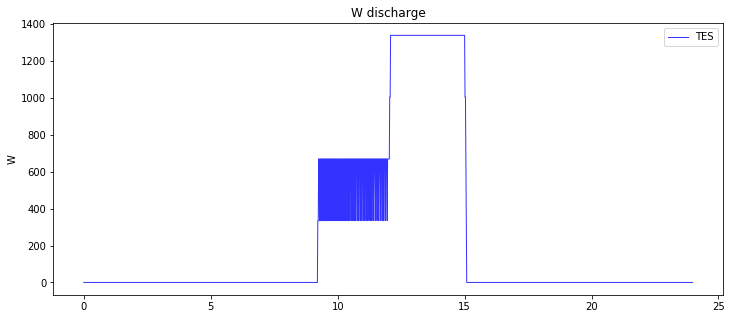

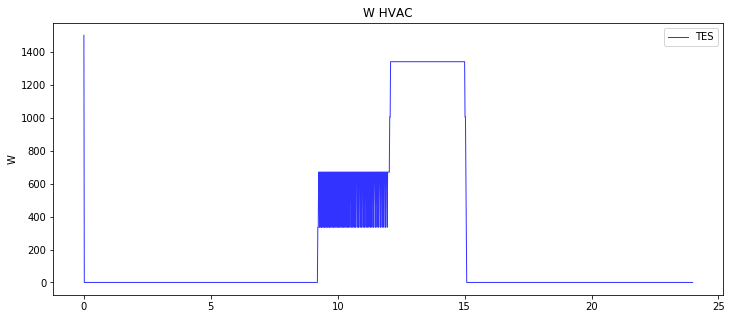

In [20]:
%%time

# MPC USING TES - DEFAULT BASIC SCENARIO

tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
# print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 17 # outer air temperature after TES

comp_to_work_MPC_inertia = 112500 #KOSTYL


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# print(len(N_oc), len(T_out))



# for i in range(len(time_t)):
#     N_oc.append(Noc_foo(time_t[i]))
#     T_out.append(outtemp_example(time_t, day='B'))




# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t

P_c_prev = []
P_f_prev = []

schetchik = 0    

k = 1600 # number of iterations
error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.00000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])
    
#     W_dis.append(0)
#     W_ch.append(0)

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    
    
    comp_to_work1 = 0
    comp_to_work2 = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output)*1.1) # KOSTYL
        W_dis.append(-dischargetime(time_t[i+1])*1340/40*P_f[i+1]) # KOSTYL
        W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1])
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
        if 0 < E_tes[i+1] < tau*W_dis[i+1]:
            W_dis[i+1] = -dischargetime(time_t[i+1])*E_tes[i+1] / tau
        elif E_tes[i+1] <= 0:
            W_dis[i+1] = 0
            E_tes[i+1] = 0
        if 0 < E_tes[i] < tau*W_dis[i]:
            W_dis[i] = -dischargetime(time_t[i])*E_tes[i] / tau
        elif E_tes[i] <= 0:
            W_dis[i] = 0
            E_tes[i] = 0

#         W_dis.append(0)
#         W_ch.append(0)
        
#         comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
#                         C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec        
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])
#     print(comp_to_work)
    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='TES')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(12,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='TES')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show

    comp_working = 0
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
        
    for i in range(len(T_room)):
        
        if 0 < time_t[i] < 8:
            if comp_working < comp_to_work_MPC_inertia:
#                 print(comp_working)
#                 print(comp_to_work)
                P_c[i-1] = 500
                P_c[i-1] = max(P_c[i-1],0)
                comp_working += P_c[i-1]
            
#             else:
#                 P_c[i-1] = 0
#         if T_room[i] < T_wall[i] + 0.5:
#                 P_c[i-1] = 0
        
        if 9 < time_t[i] < 18:
            P_c[i] = 0
            P_c[i-1] = 0
            P_c[i-2] = 0
        
        if 9 < time_t[i] < 18:
            if T_room[i] > 24:
                P_f[i-1] += 10
                P_f[i-1] = min(P_f[i-1], 40)
                break
            if T_room[i] < 23.8:
                P_f[i-1] -= 10
                P_f[i-1] = max(P_f[i-1],0)
            if T_room[i] < 23:
                P_f[i-2] -= 10
                P_f[i-2] = max(P_f[i-2],0)
                
#         if 9 < time_t[i] < 18:
#             P_f[i] = 40
        
                    
    if E_tes[N-1] > 1000 and loss_T < 0.5:
        comp_to_work_MPC_inertia -= 500


    
    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost
    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )


for i in range(len(E_tes)):
    E_tes[i] = E_tes[i]/1000/3600

RUN_RESULTS.append(['MPC WITH THERMAL ENERGY STORAGE', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='TES')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='TES')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('TES charge')
plt.ylabel('kW*h')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
T_room_TES = T_room
n_CO2_TES = n_CO2
P_f_TES = P_f_prev
P_c_TES = P_c_prev
T_wall_TES = T_wall
W_HVAC_TES = W_HVAC
W_ch_TES = W_ch
W_dis_TES = W_dis
W_CHARGE_TES = E_tes


In [60]:
# print(P_c_prev)
# with open ('P_c_results_TES.txt', 'w') as ouf1:
#     ouf1.write(str(P_c_prev))
# with open ('P_f_results_TES.txt', 'w') as ouf2:
#     ouf2.write(str(P_f_prev))

<function matplotlib.pyplot.show(*args, **kw)>

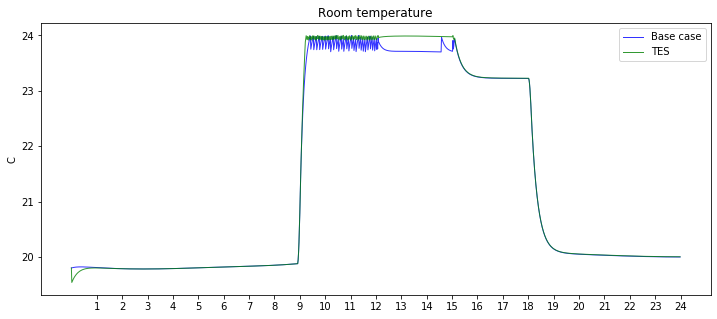

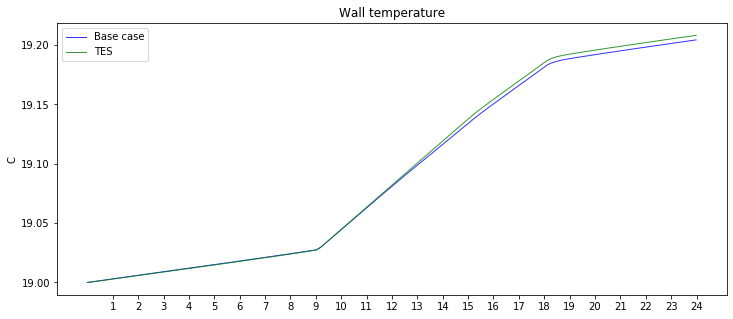

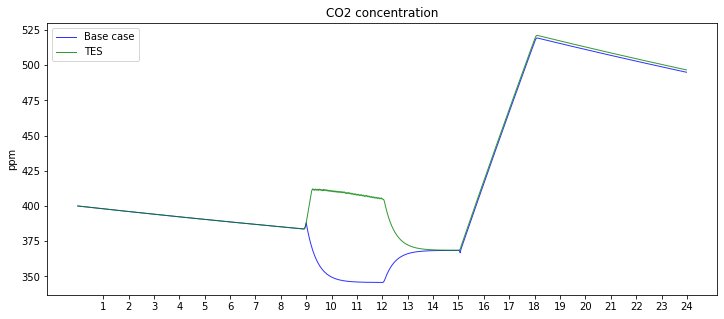

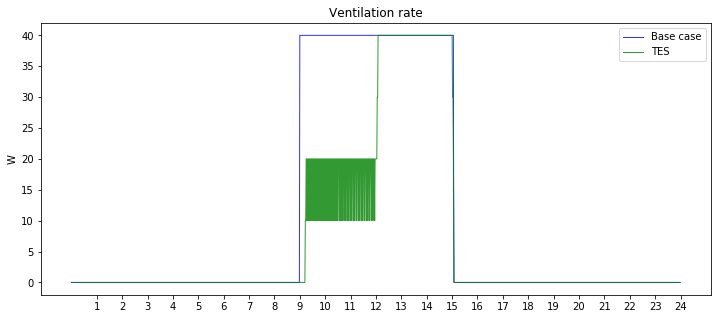

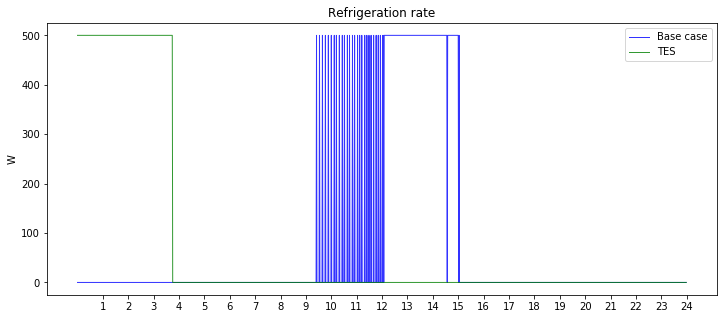

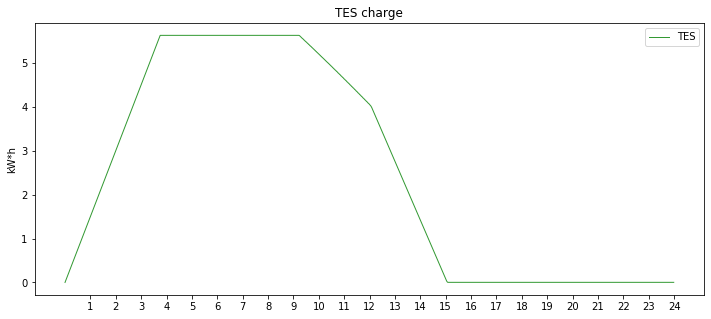

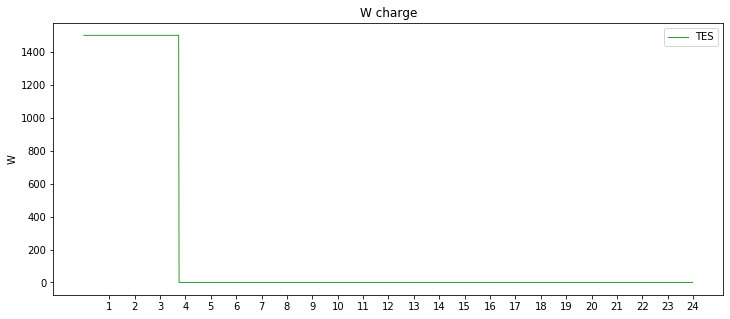

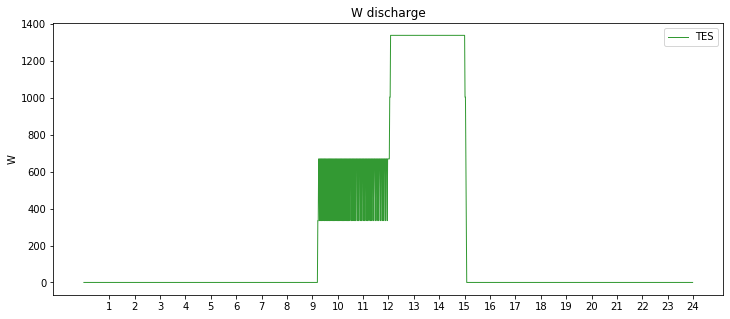

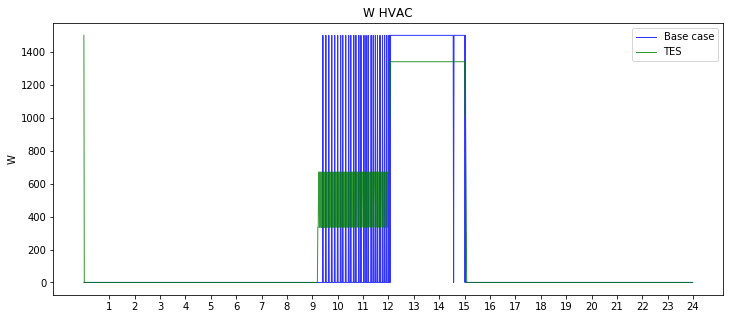

In [22]:
# PRINTED PLOTS
hours = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

plt.figure(figsize=(12,5))
plt.plot(time_t, T_room_MPC, color='blue', alpha=0.8, linewidth=1, label='Base case')
# plt.plot(time_t, T_room_MPC_inertia, color='pink', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.plot(time_t, T_room_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('Room temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall_MPC, color='blue', alpha=0.8, linewidth=1, label='Base case')
# plt.plot(time_t, T_wall_MPC_inertia, color='pink', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.plot(time_t, T_wall_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('Wall temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2_MPC, color='blue', alpha=0.8, linewidth=1, label='Base case')
# plt.plot(time_t, n_CO2_MPC_inertia, color='pink', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.plot(time_t, n_CO2_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_MPC, color='blue', alpha=0.8, linewidth=1, label='Base case')
# plt.plot(time_t, P_f_MPC_inertia, color='pink', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.plot(time_t, P_f_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_MPC, color='blue', alpha=0.8, linewidth=1, label='Base case')
# plt.plot(time_t, P_c_MPC_inertia, color='pink', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.plot(time_t, P_c_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_CHARGE_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('TES charge')
plt.ylabel('kW*h')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('W charge')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('W discharge')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC_MPC, color='blue', alpha=0.8, linewidth=1, label='Base case')
# plt.plot(time_t, W_HVAC_MPC_inertia, color='pink', alpha=0.8, linewidth=1, label='MPC Inertia')
plt.plot(time_t, W_HVAC_TES, color='green', alpha=0.8, linewidth=1, label='TES')
plt.title('W HVAC')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

In [23]:
# As you can see, the total compressor consumption was shifted from the daytime to night-time.
# Since TES implementation is a good tool for peak load reduction

In [ ]:
# Now let's proceed to different TES fluids comparison

1440.0
iteration =  1 : with cost =  0.0  rub,  energy consumed =  0.0 kW*h,  LossT =  1378.1 LossCO2 =  0.0
Total summary P_c needed =  547.5  W * tau summary, Total summary P_f needed 2211.1  W * tau summary
Computed COMP:  0.0 Computed FAN:  0.0
iteration =  2 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1373.6 LossCO2 =  0.0
Total summary P_c needed =  16698.5  W * tau summary, Total summary P_f needed 2220.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  10.0
iteration =  3 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1372.2 LossCO2 =  0.0
Total summary P_c needed =  16810.0  W * tau summary, Total summary P_f needed 2229.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  20.0
iteration =  4 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1370.7 LossCO2 =  0.0
Total summary P_c needed =  16921.5  W * tau summary, Total summary P_f needed 2238.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  30.0
i

iteration =  34 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1329.0 LossCO2 =  0.0
Total summary P_c needed =  20266.7  W * tau summary, Total summary P_f needed 2508.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  330.0
iteration =  35 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1327.6 LossCO2 =  0.0
Total summary P_c needed =  20378.2  W * tau summary, Total summary P_f needed 2517.2  W * tau summary
Computed COMP:  115000.0 Computed FAN:  340.0
iteration =  36 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1326.2 LossCO2 =  0.0
Total summary P_c needed =  20489.7  W * tau summary, Total summary P_f needed 2526.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  350.0
iteration =  37 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1324.8 LossCO2 =  0.0
Total summary P_c needed =  20601.2  W * tau summary, Total summary P_f needed 2535.2  W * tau summary
Computed COMP:  115000.0 Computed FAN:

iteration =  67 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1283.2 LossCO2 =  0.0
Total summary P_c needed =  23946.3  W * tau summary, Total summary P_f needed 2804.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  660.0
iteration =  68 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1281.8 LossCO2 =  0.0
Total summary P_c needed =  24057.8  W * tau summary, Total summary P_f needed 2813.2  W * tau summary
Computed COMP:  115000.0 Computed FAN:  670.0
iteration =  69 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1280.5 LossCO2 =  0.0
Total summary P_c needed =  24169.3  W * tau summary, Total summary P_f needed 2822.2  W * tau summary
Computed COMP:  115000.0 Computed FAN:  680.0
iteration =  70 : with cost =  8.1  rub,  energy consumed =  1.9 kW*h,  LossT =  1279.1 LossCO2 =  0.0
Total summary P_c needed =  24280.9  W * tau summary, Total summary P_f needed 2831.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:

iteration =  100 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1237.4 LossCO2 =  0.0
Total summary P_c needed =  27626.0  W * tau summary, Total summary P_f needed 3099.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  990.0
iteration =  101 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1236.0 LossCO2 =  0.0
Total summary P_c needed =  27737.5  W * tau summary, Total summary P_f needed 3108.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1000.0
iteration =  102 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1234.6 LossCO2 =  0.0
Total summary P_c needed =  27849.0  W * tau summary, Total summary P_f needed 3117.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1010.0
iteration =  103 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1233.2 LossCO2 =  0.0
Total summary P_c needed =  27960.5  W * tau summary, Total summary P_f needed 3125.8  W * tau summary
Computed COMP:  115000.0 Compute

iteration =  133 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1191.5 LossCO2 =  0.0
Total summary P_c needed =  31305.6  W * tau summary, Total summary P_f needed 3392.6  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1320.0
iteration =  134 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1190.1 LossCO2 =  0.0
Total summary P_c needed =  31417.1  W * tau summary, Total summary P_f needed 3401.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1330.0
iteration =  135 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1188.7 LossCO2 =  0.0
Total summary P_c needed =  31528.7  W * tau summary, Total summary P_f needed 3410.4  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1340.0
iteration =  136 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1187.3 LossCO2 =  0.0
Total summary P_c needed =  31640.2  W * tau summary, Total summary P_f needed 3419.2  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  166 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1145.9 LossCO2 =  0.0
Total summary P_c needed =  34985.3  W * tau summary, Total summary P_f needed 3685.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1650.0
iteration =  167 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1144.5 LossCO2 =  0.0
Total summary P_c needed =  35096.8  W * tau summary, Total summary P_f needed 3693.8  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1660.0
iteration =  168 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1143.0 LossCO2 =  0.0
Total summary P_c needed =  35208.3  W * tau summary, Total summary P_f needed 3702.6  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1670.0
iteration =  169 : with cost =  8.2  rub,  energy consumed =  1.9 kW*h,  LossT =  1141.7 LossCO2 =  0.0
Total summary P_c needed =  35319.8  W * tau summary, Total summary P_f needed 3711.5  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  199 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  1100.1 LossCO2 =  0.0
Total summary P_c needed =  38665.0  W * tau summary, Total summary P_f needed 3975.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1980.0
iteration =  200 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  1098.7 LossCO2 =  0.0
Total summary P_c needed =  38776.5  W * tau summary, Total summary P_f needed 3984.7  W * tau summary
Computed COMP:  115000.0 Computed FAN:  1990.0
iteration =  201 : with cost =  8.3  rub,  energy consumed =  1.9 kW*h,  LossT =  1097.3 LossCO2 =  0.0
Total summary P_c needed =  38888.0  W * tau summary, Total summary P_f needed 3993.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2000.0
iteration =  202 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1096.0 LossCO2 =  0.0
Total summary P_c needed =  38999.5  W * tau summary, Total summary P_f needed 4002.4  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  232 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1054.4 LossCO2 =  0.0
Total summary P_c needed =  42344.6  W * tau summary, Total summary P_f needed 4265.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2310.0
iteration =  233 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1053.1 LossCO2 =  0.0
Total summary P_c needed =  42456.1  W * tau summary, Total summary P_f needed 4274.4  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2320.0
iteration =  234 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1051.7 LossCO2 =  0.0
Total summary P_c needed =  42567.6  W * tau summary, Total summary P_f needed 4283.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2330.0
iteration =  235 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1050.3 LossCO2 =  0.0
Total summary P_c needed =  42679.1  W * tau summary, Total summary P_f needed 4291.8  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  265 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1009.0 LossCO2 =  0.0
Total summary P_c needed =  46024.3  W * tau summary, Total summary P_f needed 4553.8  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2640.0
iteration =  266 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1007.6 LossCO2 =  0.0
Total summary P_c needed =  46135.8  W * tau summary, Total summary P_f needed 4562.6  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2650.0
iteration =  267 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1006.2 LossCO2 =  0.0
Total summary P_c needed =  46247.3  W * tau summary, Total summary P_f needed 4571.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2660.0
iteration =  268 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  1004.9 LossCO2 =  0.0
Total summary P_c needed =  46358.8  W * tau summary, Total summary P_f needed 4580.1  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  298 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  963.4 LossCO2 =  0.0
Total summary P_c needed =  49703.9  W * tau summary, Total summary P_f needed 4841.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2970.0
iteration =  299 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  962.0 LossCO2 =  0.0
Total summary P_c needed =  49815.4  W * tau summary, Total summary P_f needed 4849.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2980.0
iteration =  300 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  960.6 LossCO2 =  0.0
Total summary P_c needed =  49926.9  W * tau summary, Total summary P_f needed 4858.6  W * tau summary
Computed COMP:  115000.0 Computed FAN:  2990.0
iteration =  301 : with cost =  8.3  rub,  energy consumed =  2.0 kW*h,  LossT =  959.2 LossCO2 =  0.0
Total summary P_c needed =  50038.4  W * tau summary, Total summary P_f needed 4867.4  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  331 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  917.6 LossCO2 =  0.0
Total summary P_c needed =  53383.6  W * tau summary, Total summary P_f needed 5130.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3300.0
iteration =  332 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  916.2 LossCO2 =  0.0
Total summary P_c needed =  53495.1  W * tau summary, Total summary P_f needed 5139.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3310.0
iteration =  333 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  914.8 LossCO2 =  0.0
Total summary P_c needed =  53606.6  W * tau summary, Total summary P_f needed 5147.8  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3320.0
iteration =  334 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  913.4 LossCO2 =  0.0
Total summary P_c needed =  53718.1  W * tau summary, Total summary P_f needed 5156.8  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  364 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  871.5 LossCO2 =  0.0
Total summary P_c needed =  57063.2  W * tau summary, Total summary P_f needed 5420.7  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3630.0
iteration =  365 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  870.1 LossCO2 =  0.0
Total summary P_c needed =  57174.7  W * tau summary, Total summary P_f needed 5429.6  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3640.0
iteration =  366 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  868.8 LossCO2 =  0.0
Total summary P_c needed =  57286.2  W * tau summary, Total summary P_f needed 5438.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3650.0
iteration =  367 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  867.4 LossCO2 =  0.0
Total summary P_c needed =  57397.7  W * tau summary, Total summary P_f needed 5447.2  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  397 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  825.4 LossCO2 =  0.0
Total summary P_c needed =  60742.9  W * tau summary, Total summary P_f needed 5711.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3960.0
iteration =  398 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  824.1 LossCO2 =  0.0
Total summary P_c needed =  60854.4  W * tau summary, Total summary P_f needed 5720.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3970.0
iteration =  399 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  822.6 LossCO2 =  0.0
Total summary P_c needed =  60965.9  W * tau summary, Total summary P_f needed 5729.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  3980.0
iteration =  400 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  821.2 LossCO2 =  0.0
Total summary P_c needed =  61077.4  W * tau summary, Total summary P_f needed 5738.3  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  430 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  779.3 LossCO2 =  0.0
Total summary P_c needed =  64422.5  W * tau summary, Total summary P_f needed 6003.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4290.0
iteration =  431 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  777.9 LossCO2 =  0.0
Total summary P_c needed =  64534.0  W * tau summary, Total summary P_f needed 6012.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4300.0
iteration =  432 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  776.5 LossCO2 =  0.0
Total summary P_c needed =  64645.5  W * tau summary, Total summary P_f needed 6020.8  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4310.0
iteration =  433 : with cost =  8.4  rub,  energy consumed =  2.0 kW*h,  LossT =  775.1 LossCO2 =  0.0
Total summary P_c needed =  64757.0  W * tau summary, Total summary P_f needed 6029.6  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  463 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  733.1 LossCO2 =  0.0
Total summary P_c needed =  68102.2  W * tau summary, Total summary P_f needed 6294.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4620.0
iteration =  464 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  731.7 LossCO2 =  0.0
Total summary P_c needed =  68213.7  W * tau summary, Total summary P_f needed 6302.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4630.0
iteration =  465 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  730.3 LossCO2 =  0.0
Total summary P_c needed =  68325.2  W * tau summary, Total summary P_f needed 6311.7  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4640.0
iteration =  466 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  728.9 LossCO2 =  0.0
Total summary P_c needed =  68436.7  W * tau summary, Total summary P_f needed 6320.7  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  496 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  687.0 LossCO2 =  0.0
Total summary P_c needed =  71781.8  W * tau summary, Total summary P_f needed 6584.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4950.0
iteration =  497 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  685.6 LossCO2 =  0.0
Total summary P_c needed =  71893.3  W * tau summary, Total summary P_f needed 6593.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4960.0
iteration =  498 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  684.2 LossCO2 =  0.0
Total summary P_c needed =  72004.8  W * tau summary, Total summary P_f needed 6602.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  4970.0
iteration =  499 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  682.8 LossCO2 =  0.0
Total summary P_c needed =  72116.3  W * tau summary, Total summary P_f needed 6610.7  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  529 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  640.8 LossCO2 =  0.0
Total summary P_c needed =  75461.5  W * tau summary, Total summary P_f needed 6873.6  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5280.0
iteration =  530 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  639.4 LossCO2 =  0.0
Total summary P_c needed =  75573.0  W * tau summary, Total summary P_f needed 6882.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5290.0
iteration =  531 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  638.0 LossCO2 =  0.0
Total summary P_c needed =  75684.5  W * tau summary, Total summary P_f needed 6891.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5300.0
iteration =  532 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  636.6 LossCO2 =  0.0
Total summary P_c needed =  75796.0  W * tau summary, Total summary P_f needed 6899.8  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  562 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  594.7 LossCO2 =  0.0
Total summary P_c needed =  79141.1  W * tau summary, Total summary P_f needed 7161.8  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5610.0
iteration =  563 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  593.3 LossCO2 =  0.0
Total summary P_c needed =  79252.6  W * tau summary, Total summary P_f needed 7170.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5620.0
iteration =  564 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  591.9 LossCO2 =  0.0
Total summary P_c needed =  79364.1  W * tau summary, Total summary P_f needed 7179.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5630.0
iteration =  565 : with cost =  8.5  rub,  energy consumed =  2.0 kW*h,  LossT =  590.5 LossCO2 =  0.0
Total summary P_c needed =  79475.6  W * tau summary, Total summary P_f needed 7187.7  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  595 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  548.6 LossCO2 =  0.0
Total summary P_c needed =  82820.7  W * tau summary, Total summary P_f needed 7448.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5940.0
iteration =  596 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  547.2 LossCO2 =  0.0
Total summary P_c needed =  82932.2  W * tau summary, Total summary P_f needed 7456.8  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5950.0
iteration =  597 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  545.8 LossCO2 =  0.0
Total summary P_c needed =  83043.7  W * tau summary, Total summary P_f needed 7465.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  5960.0
iteration =  598 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  544.4 LossCO2 =  0.0
Total summary P_c needed =  83155.2  W * tau summary, Total summary P_f needed 7474.3  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  628 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  502.5 LossCO2 =  0.0
Total summary P_c needed =  86500.4  W * tau summary, Total summary P_f needed 7732.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6270.0
iteration =  629 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  501.1 LossCO2 =  0.0
Total summary P_c needed =  86611.9  W * tau summary, Total summary P_f needed 7741.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6280.0
iteration =  630 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  499.8 LossCO2 =  0.0
Total summary P_c needed =  86723.4  W * tau summary, Total summary P_f needed 7750.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6290.0
iteration =  631 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  498.4 LossCO2 =  0.0
Total summary P_c needed =  86834.9  W * tau summary, Total summary P_f needed 7758.7  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  661 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  456.5 LossCO2 =  0.0
Total summary P_c needed =  90180.0  W * tau summary, Total summary P_f needed 8015.7  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6600.0
iteration =  662 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  455.1 LossCO2 =  0.0
Total summary P_c needed =  90291.5  W * tau summary, Total summary P_f needed 8024.4  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6610.0
iteration =  663 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  453.7 LossCO2 =  0.0
Total summary P_c needed =  90403.0  W * tau summary, Total summary P_f needed 8032.8  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6620.0
iteration =  664 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  452.3 LossCO2 =  0.0
Total summary P_c needed =  90514.5  W * tau summary, Total summary P_f needed 8041.3  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  694 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  410.5 LossCO2 =  0.0
Total summary P_c needed =  93859.7  W * tau summary, Total summary P_f needed 8296.4  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6930.0
iteration =  695 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  409.1 LossCO2 =  0.0
Total summary P_c needed =  93971.2  W * tau summary, Total summary P_f needed 8304.7  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6940.0
iteration =  696 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  407.7 LossCO2 =  0.0
Total summary P_c needed =  94082.7  W * tau summary, Total summary P_f needed 8313.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  6950.0
iteration =  697 : with cost =  8.6  rub,  energy consumed =  2.0 kW*h,  LossT =  406.3 LossCO2 =  0.0
Total summary P_c needed =  94194.2  W * tau summary, Total summary P_f needed 8321.7  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  727 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  364.6 LossCO2 =  0.0
Total summary P_c needed =  97539.3  W * tau summary, Total summary P_f needed 8574.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7260.0
iteration =  728 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  363.2 LossCO2 =  0.0
Total summary P_c needed =  97650.8  W * tau summary, Total summary P_f needed 8582.6  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7270.0
iteration =  729 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  361.8 LossCO2 =  0.0
Total summary P_c needed =  97762.3  W * tau summary, Total summary P_f needed 8591.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7280.0
iteration =  730 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  360.4 LossCO2 =  0.0
Total summary P_c needed =  97873.8  W * tau summary, Total summary P_f needed 8599.6  W * tau summary
Computed COMP:  115000.0 Computed F

iteration =  760 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  318.7 LossCO2 =  0.0
Total summary P_c needed =  101218.9  W * tau summary, Total summary P_f needed 8849.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7590.0
iteration =  761 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  317.3 LossCO2 =  0.0
Total summary P_c needed =  101330.4  W * tau summary, Total summary P_f needed 8857.8  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7600.0
iteration =  762 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  316.0 LossCO2 =  0.0
Total summary P_c needed =  101441.9  W * tau summary, Total summary P_f needed 8866.2  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7610.0
iteration =  763 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  314.6 LossCO2 =  0.0
Total summary P_c needed =  101553.5  W * tau summary, Total summary P_f needed 8874.4  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  793 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  272.9 LossCO2 =  0.0
Total summary P_c needed =  104898.6  W * tau summary, Total summary P_f needed 9121.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7920.0
iteration =  794 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  271.6 LossCO2 =  0.0
Total summary P_c needed =  105010.1  W * tau summary, Total summary P_f needed 9129.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7930.0
iteration =  795 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  270.2 LossCO2 =  0.0
Total summary P_c needed =  105121.6  W * tau summary, Total summary P_f needed 9137.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  7940.0
iteration =  796 : with cost =  8.7  rub,  energy consumed =  2.0 kW*h,  LossT =  268.8 LossCO2 =  0.0
Total summary P_c needed =  105233.1  W * tau summary, Total summary P_f needed 9146.0  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  826 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  227.3 LossCO2 =  0.0
Total summary P_c needed =  108578.2  W * tau summary, Total summary P_f needed 9390.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8250.0
iteration =  827 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  225.9 LossCO2 =  0.0
Total summary P_c needed =  108689.7  W * tau summary, Total summary P_f needed 9398.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8260.0
iteration =  828 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  224.6 LossCO2 =  0.0
Total summary P_c needed =  108801.2  W * tau summary, Total summary P_f needed 9406.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8270.0
iteration =  829 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  223.2 LossCO2 =  0.0
Total summary P_c needed =  108912.7  W * tau summary, Total summary P_f needed 9414.1  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  859 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  181.9 LossCO2 =  0.0
Total summary P_c needed =  112257.9  W * tau summary, Total summary P_f needed 9654.2  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8580.0
iteration =  860 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  180.5 LossCO2 =  0.0
Total summary P_c needed =  112369.4  W * tau summary, Total summary P_f needed 9662.1  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8590.0
iteration =  861 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  179.2 LossCO2 =  0.0
Total summary P_c needed =  112480.9  W * tau summary, Total summary P_f needed 9670.0  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8600.0
iteration =  862 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  177.8 LossCO2 =  0.0
Total summary P_c needed =  112592.4  W * tau summary, Total summary P_f needed 9678.1  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  892 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  136.9 LossCO2 =  0.0
Total summary P_c needed =  115937.5  W * tau summary, Total summary P_f needed 9913.6  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8910.0
iteration =  893 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  135.5 LossCO2 =  0.0
Total summary P_c needed =  116049.0  W * tau summary, Total summary P_f needed 9921.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8920.0
iteration =  894 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  134.2 LossCO2 =  0.0
Total summary P_c needed =  116160.5  W * tau summary, Total summary P_f needed 9929.4  W * tau summary
Computed COMP:  115000.0 Computed FAN:  8930.0
iteration =  895 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  132.8 LossCO2 =  0.0
Total summary P_c needed =  116272.0  W * tau summary, Total summary P_f needed 9937.0  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  925 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  92.5 LossCO2 =  0.0
Total summary P_c needed =  119617.2  W * tau summary, Total summary P_f needed 10167.7  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9240.0
iteration =  926 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  91.2 LossCO2 =  0.0
Total summary P_c needed =  119728.7  W * tau summary, Total summary P_f needed 10175.4  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9250.0
iteration =  927 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  89.8 LossCO2 =  0.0
Total summary P_c needed =  119840.2  W * tau summary, Total summary P_f needed 10182.9  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9260.0
iteration =  928 : with cost =  8.8  rub,  energy consumed =  2.1 kW*h,  LossT =  88.5 LossCO2 =  0.0
Total summary P_c needed =  119951.7  W * tau summary, Total summary P_f needed 10190.4  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  958 : with cost =  8.9  rub,  energy consumed =  2.1 kW*h,  LossT =  49.6 LossCO2 =  0.0
Total summary P_c needed =  123296.8  W * tau summary, Total summary P_f needed 10415.2  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9570.0
iteration =  959 : with cost =  8.9  rub,  energy consumed =  2.1 kW*h,  LossT =  48.3 LossCO2 =  0.0
Total summary P_c needed =  123408.3  W * tau summary, Total summary P_f needed 10422.4  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9580.0
iteration =  960 : with cost =  8.9  rub,  energy consumed =  2.1 kW*h,  LossT =  47.0 LossCO2 =  0.0
Total summary P_c needed =  123519.8  W * tau summary, Total summary P_f needed 10429.7  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9590.0
iteration =  961 : with cost =  8.9  rub,  energy consumed =  2.1 kW*h,  LossT =  45.8 LossCO2 =  0.0
Total summary P_c needed =  123631.3  W * tau summary, Total summary P_f needed 10437.2  W * tau summary
Computed COMP:  115000.0 Comput

iteration =  991 : with cost =  8.9  rub,  energy consumed =  2.1 kW*h,  LossT =  11.0 LossCO2 =  0.0
Total summary P_c needed =  126976.5  W * tau summary, Total summary P_f needed 10654.3  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9900.0
iteration =  992 : with cost =  8.9  rub,  energy consumed =  2.1 kW*h,  LossT =  10.1 LossCO2 =  0.0
Total summary P_c needed =  127088.0  W * tau summary, Total summary P_f needed 10661.4  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9910.0
iteration =  993 : with cost =  8.9  rub,  energy consumed =  2.1 kW*h,  LossT =  9.1 LossCO2 =  0.0
Total summary P_c needed =  127199.5  W * tau summary, Total summary P_f needed 10668.5  W * tau summary
Computed COMP:  115000.0 Computed FAN:  9920.0
iteration =  994 : with cost =  8.9  rub,  energy consumed =  2.1 kW*h,  LossT =  8.1 LossCO2 =  0.0
Total summary P_c needed =  127311.0  W * tau summary, Total summary P_f needed 10675.7  W * tau summary
Computed COMP:  115000.0 Computed

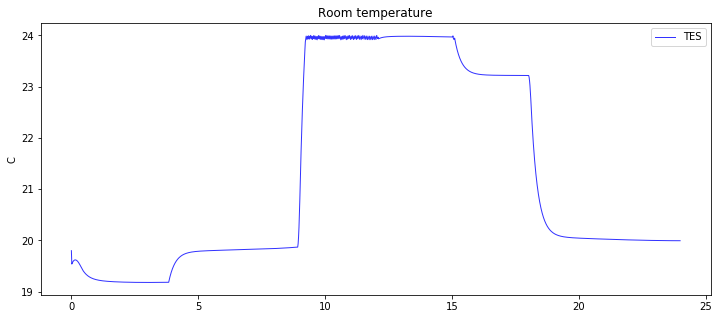

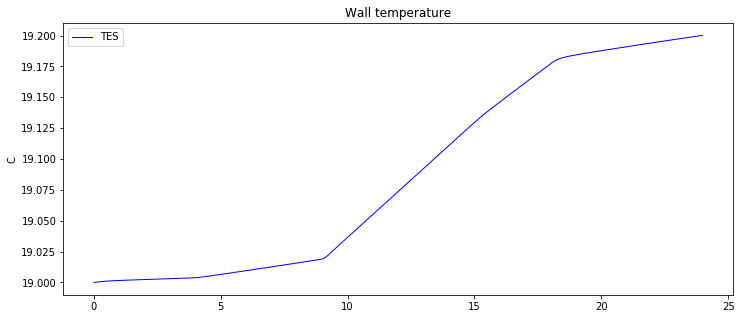

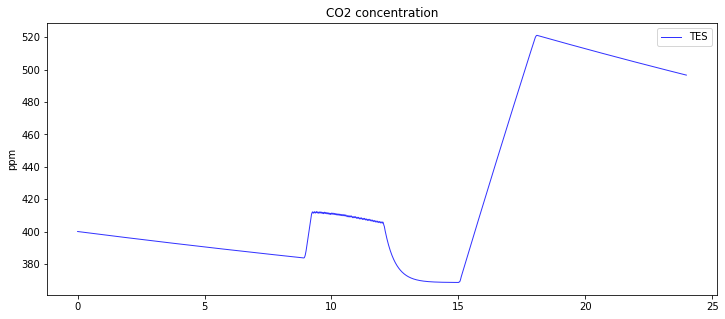

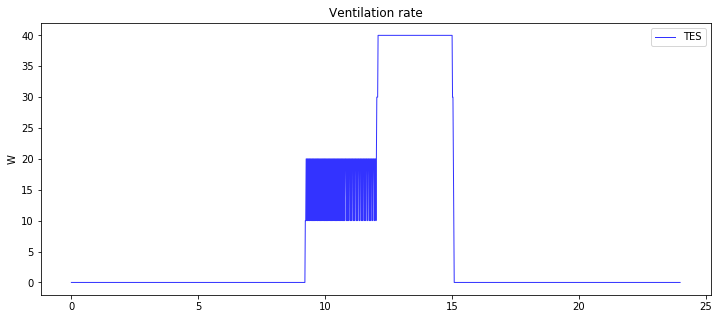

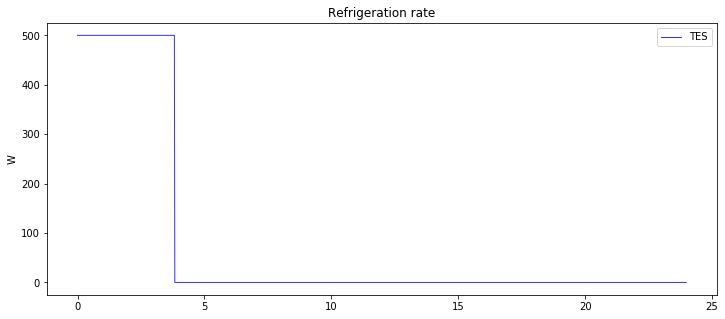

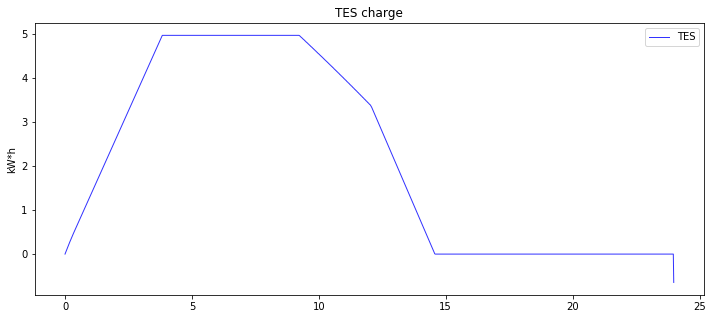

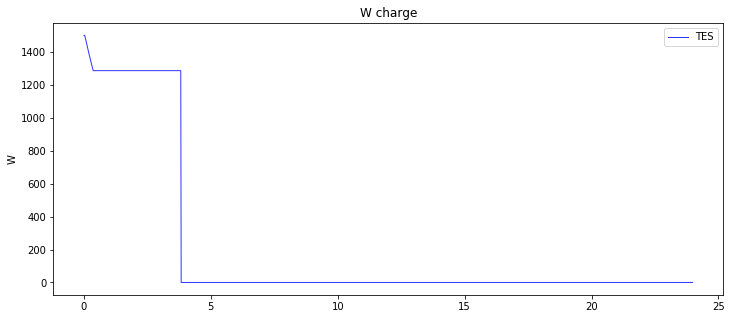

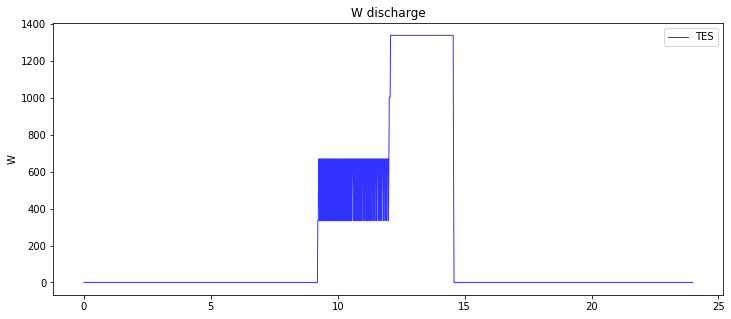

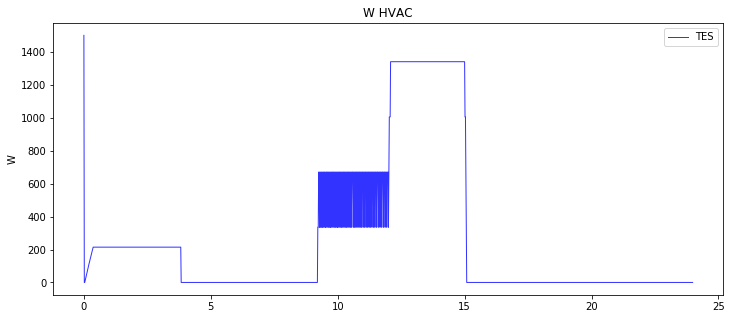

In [65]:

# MPC USING TES - TAKE THIS SCENARIO AS DEFAULT AND TRY TO IMPLEMENT DIFFERENT ENERGY STORAGES AND THEIR COMPARISON

tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 17 # outer air temperature after TES

comp_to_work_MPC_inertia = 115000 #KOSTYL


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')

# TES INPUTS

T_tes_initial = 16
tes_type = 'pcm2' # choose: 'water', 'ice', 'pcm1', 'pcm2'
tes_height = 1 #m
tes_radius = 0.25 #m

# INITIAL PARAMETERS
error = 1000

P_c = 0 * time_t
P_f = 0 * time_t
charge_out = 0 * time_t

P_c_prev = []
P_f_prev = []
charge_out_prev = []

schetchik = 0    

k = 1500 # number of iterations
error = 1000
cost_prev = 1000
# COEFFICIENTS

while schetchik <= k and error > 0.000001:
        
    W_HVAC = []
    W_dis = []
    W_ch = []
    Q = []

    Q.append(0.55 / 100 * P_f[0])
    W_HVAC.append(P_c[0] * COP)
    W_dis.append(dischargetime(time_t[0])*C_out * Q[0] * (T_out[0] - T_output))
    W_ch.append(chargetime(time_t[0]) * W_HVAC[0])
    
#     W_dis.append(0)
#     W_ch.append(0)

    T_room = []
    T_wall = []
    n_CO2 = []
    E_tes = []
    T_tes = []
#     T_room.append(24)
#     T_wall.append(19)
#     n_CO2.append(800)
#     E_tes.append(0)
    
    T_room.append(19.8)
    T_wall.append(19)
    n_CO2.append(400)
    E_tes.append(0)
    T_tes.append(T_tes_initial)
    
    
    comp_to_work = 0
    
    fan_to_work = 0

    for i in range(N-1):
        
        Q.append(0.55 / 100 * P_f[i+1])
        
        W_HVAC.append(P_c[i+1] * COP)
        
#         W_dis.append(-dischargetime(time_t[i+1])*C_out * Q[i+1] * (T_out[i+1] - T_output))
        W_dis.append(-dischargetime(time_t[i+1])*1340/40*P_f[i+1]) # KOSTYL
        
        W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1]*((T_tes[i]+5)/(T_tes_initial+5)) + charge_out[i+1])
        
        comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                        C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec
        
        fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air
        
        
        W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]
        
        T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                         + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

        T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

        n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))
      
        
        E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        
        if 0 < E_tes[i] < tau*W_dis[i]:
            W_dis[i] = E_tes[i] / tau
        elif E_tes[i] <= 0:
            W_dis[i] = 0
            E_tes[i] = 0
            
        T_tes.append(tes_temp(tes_height, tes_radius, E_tes[i], tes_type, T_tes_initial))
        
#         if i % 100 == 5:
#             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

    energy_consumed = 0
    cost = 0
    loss_T = 0
    loss_CO2 = 0
    
    P_c_prev = []
    P_f_prev = []
    charge_out_prev = []
    
    kek = 'Iteration '+ str(schetchik + 1)
    ventu = 'Ventilation rate, ' + kek
    refru = 'Refrigeration rate, ' + kek
       
#     plt.figure(figsize=(5,5))
#     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='Model')
#     plt.title(ventu)
#     plt.ylabel('%')
#     plt.legend()
#     plt.show

#     plt.figure(figsize=(5,5))
#     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='Model')
#     plt.title(refru)
#     plt.ylabel('W')
#     plt.legend()
#     plt.show

    comp_working = 0
    
    for i in range(len(T_room)):
        
        energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000
        
        
        cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
        P_c_prev.append(P_c[i])
        P_f_prev.append(P_f[i])
        if T_room[i] > 24:
            loss_T += (T_room[i] - 24) * tau
        
    for i in range(len(T_room)):
        
        if 0 < time_t[i] < 8:
            if comp_working < comp_to_work_MPC_inertia:
#                 print(comp_working)
#                 print(comp_to_work)
                P_c[i-1] = 500
                P_c[i-1] = max(P_c[i-1],0)
                comp_working += P_c[i-1]
            
#             else:
#                 P_c[i-1] = 0
#         if T_room[i] < T_wall[i] + 0.5:
#                 P_c[i-1] = 0
        
        if 9 < time_t[i] < 18:
            P_c[i] = 0
            P_c[i-1] = 0
            P_c[i-2] = 0
        
        if 9 < time_t[i] < 18:
            if T_room[i] > 24:
                P_f[i-1] += 10
                P_f[i-1] = min(P_f[i-1], 40)
                break
            if T_room[i] < 23.8:
                P_f[i-1] -= 10
                P_f[i-1] = max(P_f[i-1],0)
            if T_room[i] < 23:
                P_f[i-2] -= 10
                P_f[i-2] = max(P_f[i-2],0)
                
#         if 9 < time_t[i] < 18:
#             P_f[i] = 40
        
                    
    if E_tes[N-1] > 1000 and loss_T < 0.5:
        comp_to_work_MPC_inertia -= 500



    
    print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
#     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))

    
    print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
    print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
    
    schetchik += 1
    error = abs(cost - cost_prev)
    cost_prev = cost
    
print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
     ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

print('TES type used: ', tes_type, ', with mass: ', round(tes_mass(tes_type, tes_height, tes_radius),1), ' kg, with total price: ', round(prices_tes(tes_type)*tes_mass(tes_type, tes_height, tes_radius),1), ' rub')


for i in range(len(E_tes)):
    E_tes[i] = E_tes[i]/1000/3600

RUN_RESULTS.append(['MPC WITH TES ', tes_type,' ', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
    
plt.figure(figsize=(12,5))
plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='TES')
#plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Room temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall, color='blue', linewidth=1, label='TES')
#plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
plt.title('Wall temperature')
plt.ylabel('C')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('TES charge')
plt.ylabel('kW*h')
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W charge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W discharge')
plt.ylabel('W')
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='TES')
plt.title('W HVAC')
plt.ylabel('W')
plt.legend()
plt.show 
    
T_room_TES_TYPE = T_room
n_CO2_TES_TYPE = n_CO2
P_f_TES_TYPE = P_f_prev
P_c_TES_TYPE = P_c_prev
T_wall_TES_TYPE = T_wall
W_HVAC_TES_TYPE = W_HVAC
W_ch_TES_TYPE = W_ch
W_dis_TES_TYPE = W_dis
W_CHARGE_TES_TYPE = E_tes

In [65]:
for line in RUN_RESULTS: print(*line)

TYPE OF RUN TOTAL BILLS SUMMARY CONSUMPTION NUMBER OF CYCLES ERROR BY TEMP ERROR BY CO2
USUAL MPC 12.1 2.5 46 0.0 0.0
MPC WITH THERMAL INERTIA 12.2 2.6 47 0.0 0.0
MPC WITH THERMAL ENERGY STORAGE 10.4 2.5 30 0.0 0.0
MPC WITH TES  pcm2   10.6 2.5 22 0.0 0.0


In [66]:
# IMPLEMENTATION FOR 214 DAYS AND TES COMPARISON WAS HED IN OTHER NOTEBOOK (Google Colab)

In [67]:

# Implementation of TES temperature change - implemented
# Do a charge with ambient - implemented charge at night
# Do a func with comparison - implemented
# Do a archive data processing - implemented
# Do a big run for 4 TES with ambient FROM 1 MARCH TO 31 OCTOBER 2019 Moscow - prepare cooling from ambient + charge of TES by (comp + amb): sum_comp < comp_to_work - charge collect by ambient
# Implement different regions - further


<function matplotlib.pyplot.show(*args, **kw)>

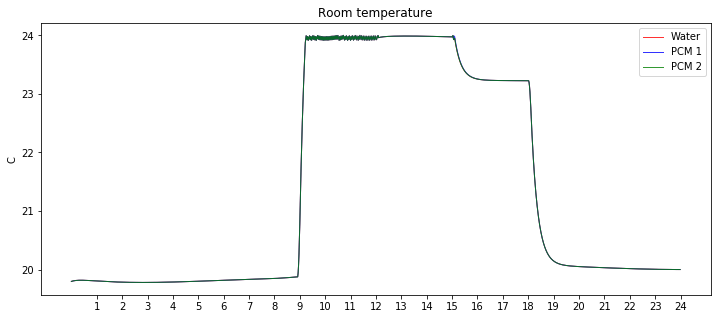

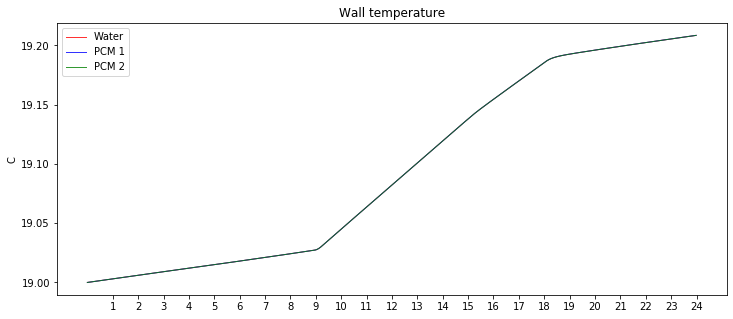

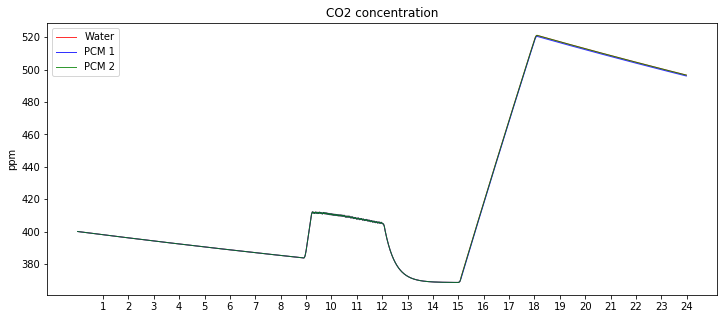

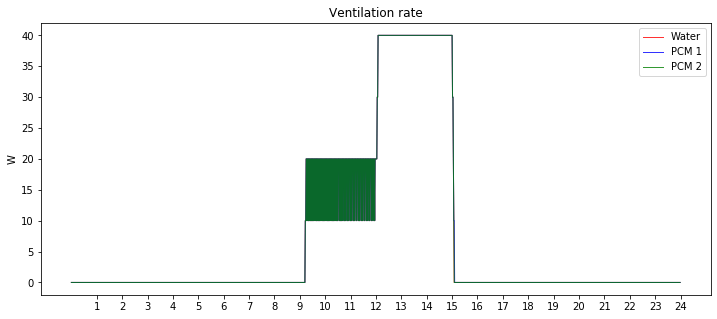

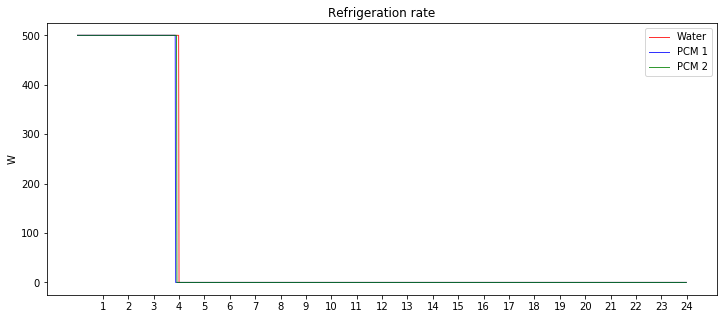

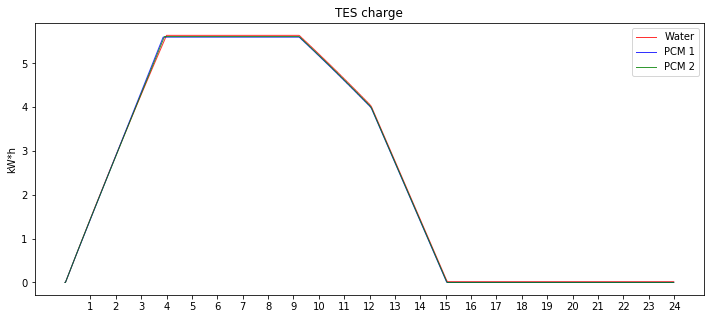

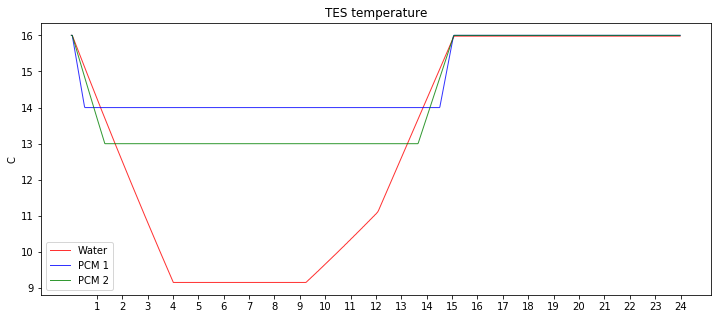

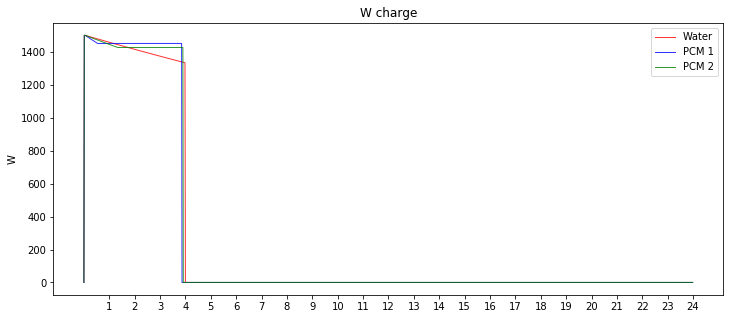

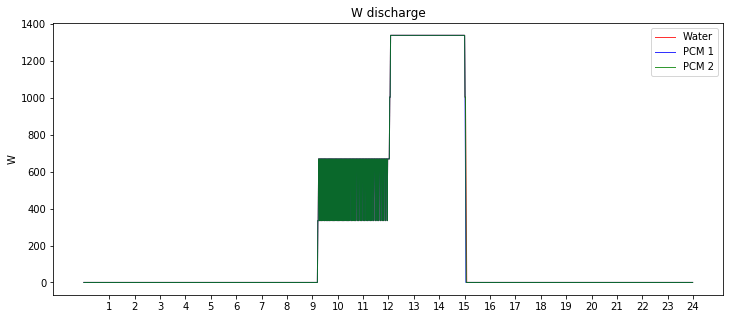

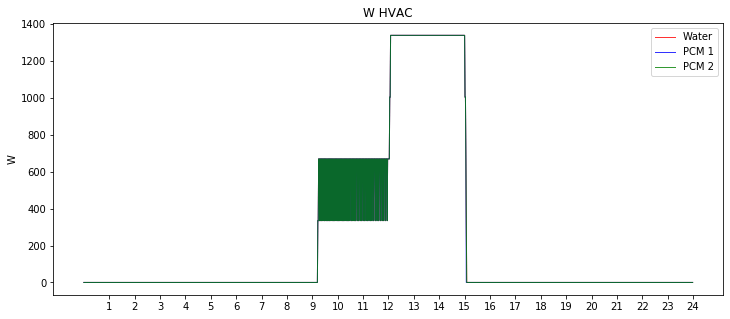

In [31]:
# PRINTED PLOTS
hours = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

plt.figure(figsize=(12,5))
plt.plot(time_t, T_room_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_room_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_room_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Room temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_wall_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_wall_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Wall temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, n_CO2_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, n_CO2_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, P_f_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, P_f_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, P_c_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, P_c_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_CHARGE_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_CHARGE_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_CHARGE_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('TES charge')
plt.ylabel('kW*h')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('TES temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_ch_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_ch_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W charge')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_dis_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_dis_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W discharge')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_HVAC_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_HVAC_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W HVAC')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

In [ ]:
# There is no visible difference if we look at temperatures and other room and control parameters
# But there is significant difference in TES temperatures and charge rates
# We can see, that the best efficiency shown by the fluid with highest melting temperature

# But we can use bigger vessel (tank) for water and increase the efficiency

In [74]:
for line in RUN_RESULTS: print(*line)

TYPE OF RUN TOTAL BILLS SUMMARY CONSUMPTION NUMBER OF CYCLES ERROR BY TEMP ERROR BY CO2
USUAL MPC 12.1 2.5 46 0.0 0.0
MPC WITH THERMAL INERTIA 12.2 2.6 47 0.0 0.0
MPC WITH THERMAL ENERGY STORAGE 10.4 2.5 30 0.0 0.0
MPC WITH TES  pcm2   10.6 2.5 22 0.0 0.0
MPC WITH TES  pcm2   10.6 2.5 22 0.0 0.0
MPC WITH TES water  10.5 2.4 22 0.02226400756451241 0.0
MPC WITH TES pcm1  10.4 2.4 21 0.0 0.0
MPC WITH TES pcm2  10.5 2.4 21 0.0 0.0
